In [1]:
from mesh_to_sdf import sample_sdf_near_surface
import os
from glob import glob
import pymesh

import trimesh
from mpl_toolkits import mplot3d

import matplotlib.image as mpimg
from stl import mesh
import numpy as np
import pyrender
import binvox_rw
import shutil
from PIL import Image

import subprocess
from subprocess import call
import sys

In [2]:
SHAPENET_PATH = '/home/ankbzpx/datasets/'

path_model = SHAPENET_PATH + 'ShapeNet/ShapeNetCore.v1/03001627/'
#3D-R2N2 rendered image
path_render = SHAPENET_PATH + 'ShapeNet/ShapeNetRendering/03001627/'
path_voxel = SHAPENET_PATH + 'ShapeNet/ShapeNetVox32/03001627/'

path_h5 = SHAPENET_PATH + 'ShapeNet/ShapeNetRenderingh5_v1/03001627/'
path_depth = SHAPENET_PATH + 'ShapeNet/ShapeNetDepth/03001627/'

In [3]:
import torch
import torch.nn.functional as F
import h5py

voxsize = 32
from vis_utils import plotFromVoxels, plotImg

# transfrom mesh
from render_utils import RotatePhi, RotateAzimuth, RotateAlongAxis
# transform voxel
from render_utils import get_meshgrid, get_transformed_meshgrid, get_transform_matrix, get_transformed_vox
# transfrom sdf
from render_utils import get_transformed_indices, sdf2Voxel

### Code for rendering depth image

In [6]:
###########################################
# Render the depth image to match 3D-R2N2 #
###########################################

import time

# parameters
F_MM = 35.  # Focal length
PIXEL_ASPECT_RATIO = 1.
CAM_MAX_DIST = 1.75
SENSOR_SIZE_MM = 32.
RESOLUTION_PCT = 100.

img_w = 137
img_h = 137

scale = RESOLUTION_PCT / 100
f_u = F_MM * img_w * scale / SENSOR_SIZE_MM
f_v = F_MM * img_h * scale * PIXEL_ASPECT_RATIO / SENSOR_SIZE_MM
u_0 = img_w * scale / 2
v_0 = img_h * scale / 2


# render
scene = pyrender.Scene()
light = pyrender.DirectionalLight(color=np.ones(3), intensity=4.0)

light_pose = np.array([[0, 0, 1, 0],
                        [0, 1, 0, 0],
                        [1, 0, 0, 0],
                        [0, 0, 0, 1]])

scene.add(light, pose=RotatePhi(75)@RotateAzimuth(45))
pc = pyrender.IntrinsicsCamera(f_u, f_v, u_0, v_0, znear=0.15*CAM_MAX_DIST, zfar=1.15*CAM_MAX_DIST)
nc = pyrender.Node(camera=pc, matrix=np.eye(4))
scene.add_node(nc)
r = pyrender.OffscreenRenderer(137, 137)

# directory
model_dir_list = sorted(glob(path_model + '*/'))
depth_dir_list = sorted(glob(path_depth + '*/'))
#voxel_dir_list = sorted(glob(path_voxel + '*/'))


for idx in range(len(model_dir_list)):
    
    print(idx)
    
    start_time = time.time()
    
    model_list = sorted(glob(model_dir_list[idx] + '*.obj'))[0]
    depth_list = sorted(glob(depth_dir_list[idx] + 'rendering/*.png'))
    
    dir_name = model_dir_list[idx].split('/')[-2]
    
    # Create output folder
    outputFolder = path_depth + dir_name + '/rendering/'
    #print(outputFolder)
    
    if not os.path.exists(outputFolder):
        os.makedirs(outputFolder)
    
    #shutil.copyfile(render_dir_list[idx] + 'rendering/rendering_metadata.txt', outputFolder + 'rendering_metadata.txt')
    #shutil.copyfile(render_dir_list[idx] + 'rendering/renderings.txt', outputFolder + 'renderings.txt')        
    
    with open(depth_dir_list[idx] + 'rendering/rendering_metadata.txt', 'r') as f:
        content = f.readlines()
    
    mesh_py = pymesh.load_mesh(model_list)
    model = trimesh.Trimesh(mesh_py.vertices,mesh_py.faces)
    mesh = pyrender.Mesh.from_trimesh(model)
    
    nm = pyrender.Node(mesh=mesh, matrix=np.eye(4))
    scene.add_node(nm)
    
    for render_idx in range(len(content)):
        
        target_line = content[render_idx][0:-1].split(' ')
        azimuth, elevation, in_plane_rotation, distance, fov = [float(target_line[i]) for i in range(len(target_line))]       
        
        scene.set_pose(nm, pose = RotateAlongAxis(elevation, 0, 1, 0) @ RotateAzimuth(-azimuth) @ RotatePhi(-90))
        
        #print('azimuth: ', azimuth)
        #print('elevation', elevation)
        
        camera_pose = np.array([[0.0, 0.0, 1.0, CAM_MAX_DIST*distance],
                                [1.0, 0.0, -0.0, 0.0],
                                [0.0, 1.0, 0.0, 0.0],
                                [0.0, 0.0, 0.0, 1.0]])
        
        scene.set_pose(nc, pose = camera_pose)
        
        depth_map = r.render(scene, pyrender.constants.RenderFlags.DEPTH_ONLY)
        
        
        # 3D-R2N2 render
        #render = mpimg.imread(render_list[render_idx])
        #plt.figure()
        #plt.subplot(1,2,1)
        #plt.imshow(render)
        
        depth_map = ((depth_map/(CAM_MAX_DIST * 1.15))*255)
        
        #plt.subplot(1,2,2)
        #plt.imshow(depth_map)
        #plt.show()
        
        Image.fromarray(depth_map).convert('L').save(outputFolder + depth_list[render_idx].split('/')[-1])
        
    print("--- %s seconds ---" % (time.time() - start_time))
    
    scene.remove_node(nm)

0
--- 0.0614166259765625 seconds ---
1
--- 0.09527325630187988 seconds ---
2
--- 0.06516170501708984 seconds ---
3
--- 0.06259679794311523 seconds ---
4
--- 0.09167027473449707 seconds ---
5
--- 0.1206200122833252 seconds ---
6
--- 0.13443422317504883 seconds ---
7
--- 0.09821629524230957 seconds ---
8
--- 0.09494352340698242 seconds ---
9
--- 0.12077164649963379 seconds ---
10
--- 0.12099933624267578 seconds ---
11
--- 0.05961322784423828 seconds ---
12
--- 0.052390098571777344 seconds ---
13
--- 0.08219671249389648 seconds ---
14
--- 0.08501791954040527 seconds ---
15
--- 0.15733814239501953 seconds ---
16
--- 0.131439208984375 seconds ---
17
--- 0.10730433464050293 seconds ---
18
--- 0.10316038131713867 seconds ---
19
--- 0.19228434562683105 seconds ---
20
--- 0.06835508346557617 seconds ---
21
--- 0.07311272621154785 seconds ---
22
--- 0.1100003719329834 seconds ---
23
--- 0.07023191452026367 seconds ---
24
--- 0.046468257904052734 seconds ---
25
--- 0.04757833480834961 seconds ---

--- 0.10888862609863281 seconds ---
212
--- 0.07504057884216309 seconds ---
213
--- 0.06696414947509766 seconds ---
214
--- 0.07406830787658691 seconds ---
215
--- 0.08583784103393555 seconds ---
216
--- 0.061715126037597656 seconds ---
217
--- 0.04542255401611328 seconds ---
218
--- 0.22875285148620605 seconds ---
219
--- 0.2301011085510254 seconds ---
220
--- 0.12322735786437988 seconds ---
221
--- 0.08122801780700684 seconds ---
222
--- 0.32024335861206055 seconds ---
223
--- 0.05352163314819336 seconds ---
224
--- 0.0654449462890625 seconds ---
225
--- 0.05476522445678711 seconds ---
226
--- 0.6317269802093506 seconds ---
227
--- 0.11758804321289062 seconds ---
228
--- 0.06236553192138672 seconds ---
229
--- 0.15030217170715332 seconds ---
230
--- 0.05765342712402344 seconds ---
231
--- 0.07635354995727539 seconds ---
232
--- 0.08889651298522949 seconds ---
233
--- 0.05643272399902344 seconds ---
234
--- 0.04134106636047363 seconds ---
235
--- 0.08999967575073242 seconds ---
236
--

--- 0.06332278251647949 seconds ---
417
--- 0.11030220985412598 seconds ---
418
--- 0.11810564994812012 seconds ---
419
--- 0.09627938270568848 seconds ---
420
--- 0.1009666919708252 seconds ---
421
--- 0.06940722465515137 seconds ---
422
--- 0.053766727447509766 seconds ---
423
--- 0.05148482322692871 seconds ---
424
--- 0.052004098892211914 seconds ---
425
--- 0.0464940071105957 seconds ---
426
--- 0.0970602035522461 seconds ---
427
--- 0.16657280921936035 seconds ---
428
--- 0.1090545654296875 seconds ---
429
--- 0.1106119155883789 seconds ---
430
--- 0.05124831199645996 seconds ---
431
--- 0.11033248901367188 seconds ---
432
--- 0.05575275421142578 seconds ---
433
--- 0.16772842407226562 seconds ---
434
--- 0.1906449794769287 seconds ---
435
--- 0.1788334846496582 seconds ---
436
--- 0.19736027717590332 seconds ---
437
--- 0.11701607704162598 seconds ---
438
--- 0.06137800216674805 seconds ---
439
--- 0.08545923233032227 seconds ---
440
--- 0.05951738357543945 seconds ---
441
--- 0

--- 0.13063454627990723 seconds ---
623
--- 0.06351518630981445 seconds ---
624
--- 0.043494462966918945 seconds ---
625
--- 0.04982566833496094 seconds ---
626
--- 0.09288597106933594 seconds ---
627
--- 0.24946141242980957 seconds ---
628
--- 0.0552825927734375 seconds ---
629
--- 0.0383150577545166 seconds ---
630
--- 0.1064305305480957 seconds ---
631
--- 0.13239145278930664 seconds ---
632
--- 0.1336345672607422 seconds ---
633
--- 0.11632442474365234 seconds ---
634
--- 0.09556269645690918 seconds ---
635
--- 0.07540750503540039 seconds ---
636
--- 0.05785632133483887 seconds ---
637
--- 0.04893636703491211 seconds ---
638
--- 0.14473366737365723 seconds ---
639
--- 0.06108522415161133 seconds ---
640
--- 0.05528426170349121 seconds ---
641
--- 0.14746618270874023 seconds ---
642
--- 0.11021637916564941 seconds ---
643
--- 0.05580306053161621 seconds ---
644
--- 0.06855034828186035 seconds ---
645
--- 0.06718182563781738 seconds ---
646
--- 0.04804515838623047 seconds ---
647
---

--- 0.06700730323791504 seconds ---
829
--- 0.10996198654174805 seconds ---
830
--- 0.06268882751464844 seconds ---
831
--- 0.05966520309448242 seconds ---
832
--- 0.14850616455078125 seconds ---
833
--- 0.10350489616394043 seconds ---
834
--- 0.17291021347045898 seconds ---
835
--- 0.05998039245605469 seconds ---
836
--- 0.12137889862060547 seconds ---
837
--- 0.18373656272888184 seconds ---
838
--- 0.07126593589782715 seconds ---
839
--- 0.08147048950195312 seconds ---
840
--- 0.1097714900970459 seconds ---
841
--- 0.11990165710449219 seconds ---
842
--- 0.10308194160461426 seconds ---
843
--- 0.1358661651611328 seconds ---
844
--- 0.05680060386657715 seconds ---
845
--- 0.19674110412597656 seconds ---
846
--- 0.07176613807678223 seconds ---
847
--- 0.10569381713867188 seconds ---
848
--- 0.10363507270812988 seconds ---
849
--- 0.06241273880004883 seconds ---
850
--- 0.08452773094177246 seconds ---
851
--- 0.06458878517150879 seconds ---
852
--- 0.09128761291503906 seconds ---
853
--

--- 0.0557408332824707 seconds ---
1036
--- 0.04734373092651367 seconds ---
1037
--- 0.042668819427490234 seconds ---
1038
--- 0.07449817657470703 seconds ---
1039
--- 0.07148218154907227 seconds ---
1040
--- 0.08038449287414551 seconds ---
1041
--- 0.17342185974121094 seconds ---
1042
--- 0.13397502899169922 seconds ---
1043
--- 0.2104635238647461 seconds ---
1044
--- 0.1062161922454834 seconds ---
1045
--- 0.06428003311157227 seconds ---
1046
--- 0.05231118202209473 seconds ---
1047
--- 0.1093132495880127 seconds ---
1048
--- 0.11381721496582031 seconds ---
1049
--- 0.06226086616516113 seconds ---
1050
--- 0.09866571426391602 seconds ---
1051
--- 0.06516504287719727 seconds ---
1052
--- 0.12948274612426758 seconds ---
1053
--- 0.1130671501159668 seconds ---
1054
--- 0.10241293907165527 seconds ---
1055
--- 0.0570220947265625 seconds ---
1056
--- 0.09873676300048828 seconds ---
1057
--- 0.1061561107635498 seconds ---
1058
--- 0.06407427787780762 seconds ---
1059
--- 0.0464498996734619

--- 0.12323808670043945 seconds ---
1237
--- 0.0895223617553711 seconds ---
1238
--- 0.05834841728210449 seconds ---
1239
--- 0.04415154457092285 seconds ---
1240
--- 0.10781216621398926 seconds ---
1241
--- 0.05282926559448242 seconds ---
1242
--- 0.03446078300476074 seconds ---
1243
--- 0.08160614967346191 seconds ---
1244
--- 0.06848382949829102 seconds ---
1245
--- 0.05272412300109863 seconds ---
1246
--- 0.05583333969116211 seconds ---
1247
--- 0.12015676498413086 seconds ---
1248
--- 0.14864373207092285 seconds ---
1249
--- 0.13701772689819336 seconds ---
1250
--- 0.0816185474395752 seconds ---
1251
--- 0.18807029724121094 seconds ---
1252
--- 0.13526463508605957 seconds ---
1253
--- 0.05669140815734863 seconds ---
1254
--- 0.1548168659210205 seconds ---
1255
--- 0.10996580123901367 seconds ---
1256
--- 0.14296221733093262 seconds ---
1257
--- 0.09270858764648438 seconds ---
1258
--- 0.05525350570678711 seconds ---
1259
--- 0.11877918243408203 seconds ---
1260
--- 0.0548195838928

--- 0.042867422103881836 seconds ---
1440
--- 0.03951096534729004 seconds ---
1441
--- 0.07251358032226562 seconds ---
1442
--- 0.1410210132598877 seconds ---
1443
--- 0.11175012588500977 seconds ---
1444
--- 0.08288240432739258 seconds ---
1445
--- 0.11099696159362793 seconds ---
1446
--- 0.058869361877441406 seconds ---
1447
--- 0.04122495651245117 seconds ---
1448
--- 0.039581298828125 seconds ---
1449
--- 0.07201886177062988 seconds ---
1450
--- 0.1371445655822754 seconds ---
1451
--- 0.08681082725524902 seconds ---
1452
--- 0.1339855194091797 seconds ---
1453
--- 0.34966278076171875 seconds ---
1454
--- 0.1176767349243164 seconds ---
1455
--- 0.1842660903930664 seconds ---
1456
--- 0.056088924407958984 seconds ---
1457
--- 0.09507012367248535 seconds ---
1458
--- 0.09522461891174316 seconds ---
1459
--- 0.06043529510498047 seconds ---
1460
--- 0.1932682991027832 seconds ---
1461
--- 0.11174297332763672 seconds ---
1462
--- 0.12408733367919922 seconds ---
1463
--- 0.180073499679565

--- 0.06963753700256348 seconds ---
1643
--- 0.03944516181945801 seconds ---
1644
--- 0.08134245872497559 seconds ---
1645
--- 0.08640599250793457 seconds ---
1646
--- 0.10290670394897461 seconds ---
1647
--- 0.06357741355895996 seconds ---
1648
--- 0.09961843490600586 seconds ---
1649
--- 0.0637354850769043 seconds ---
1650
--- 0.04876852035522461 seconds ---
1651
--- 0.044997453689575195 seconds ---
1652
--- 0.09247636795043945 seconds ---
1653
--- 0.0714113712310791 seconds ---
1654
--- 0.09675788879394531 seconds ---
1655
--- 0.08410096168518066 seconds ---
1656
--- 0.13479042053222656 seconds ---
1657
--- 0.05424189567565918 seconds ---
1658
--- 0.09613251686096191 seconds ---
1659
--- 0.12317132949829102 seconds ---
1660
--- 0.09825372695922852 seconds ---
1661
--- 0.06281113624572754 seconds ---
1662
--- 0.09081077575683594 seconds ---
1663
--- 0.10438084602355957 seconds ---
1664
--- 0.11504173278808594 seconds ---
1665
--- 0.18466830253601074 seconds ---
1666
--- 0.15412998199

--- 0.09584403038024902 seconds ---
1847
--- 0.16384601593017578 seconds ---
1848
--- 0.058095693588256836 seconds ---
1849
--- 0.03600645065307617 seconds ---
1850
--- 0.03630805015563965 seconds ---
1851
--- 0.037381649017333984 seconds ---
1852
--- 0.03400421142578125 seconds ---
1853
--- 0.07392048835754395 seconds ---
1854
--- 0.11618161201477051 seconds ---
1855
--- 0.08652758598327637 seconds ---
1856
--- 0.21598410606384277 seconds ---
1857
--- 0.059510231018066406 seconds ---
1858
--- 0.09242391586303711 seconds ---
1859
--- 0.04730415344238281 seconds ---
1860
--- 0.04172515869140625 seconds ---
1861
--- 0.06704401969909668 seconds ---
1862
--- 0.13647770881652832 seconds ---
1863
--- 0.05592751502990723 seconds ---
1864
--- 0.0439915657043457 seconds ---
1865
--- 0.05623459815979004 seconds ---
1866
--- 0.05160856246948242 seconds ---
1867
--- 0.14360690116882324 seconds ---
1868
--- 0.16072440147399902 seconds ---
1869
--- 0.06781816482543945 seconds ---
1870
--- 0.11222863

--- 0.10784244537353516 seconds ---
2049
--- 0.05828261375427246 seconds ---
2050
--- 0.09658551216125488 seconds ---
2051
--- 0.10530924797058105 seconds ---
2052
--- 0.12254548072814941 seconds ---
2053
--- 0.22390151023864746 seconds ---
2054
--- 0.060820817947387695 seconds ---
2055
--- 0.0908660888671875 seconds ---
2056
--- 0.06245756149291992 seconds ---
2057
--- 0.08721542358398438 seconds ---
2058
--- 0.14629840850830078 seconds ---
2059
--- 0.1353468894958496 seconds ---
2060
--- 0.10933303833007812 seconds ---
2061
--- 0.05989551544189453 seconds ---
2062
--- 0.056876182556152344 seconds ---
2063
--- 0.05014204978942871 seconds ---
2064
--- 0.052031755447387695 seconds ---
2065
--- 0.12721467018127441 seconds ---
2066
--- 0.06026124954223633 seconds ---
2067
--- 0.12214922904968262 seconds ---
2068
--- 0.09949302673339844 seconds ---
2069
--- 0.05719757080078125 seconds ---
2070
--- 0.17450261116027832 seconds ---
2071
--- 0.11711835861206055 seconds ---
2072
--- 0.059964179

--- 0.1482844352722168 seconds ---
2250
--- 0.2016305923461914 seconds ---
2251
--- 0.09825420379638672 seconds ---
2252
--- 0.05981326103210449 seconds ---
2253
--- 0.05164599418640137 seconds ---
2254
--- 0.11149811744689941 seconds ---
2255
--- 0.052640438079833984 seconds ---
2256
--- 0.047789812088012695 seconds ---
2257
--- 0.15642499923706055 seconds ---
2258
--- 0.05599188804626465 seconds ---
2259
--- 0.06419730186462402 seconds ---
2260
--- 0.07497954368591309 seconds ---
2261
--- 0.1495659351348877 seconds ---
2262
--- 0.09118866920471191 seconds ---
2263
--- 0.08841323852539062 seconds ---
2264
--- 0.26500439643859863 seconds ---
2265
--- 0.14547181129455566 seconds ---
2266
--- 0.056348562240600586 seconds ---
2267
--- 0.11839962005615234 seconds ---
2268
--- 0.09749674797058105 seconds ---
2269
--- 0.1161508560180664 seconds ---
2270
--- 0.13100075721740723 seconds ---
2271
--- 0.08705568313598633 seconds ---
2272
--- 0.06524801254272461 seconds ---
2273
--- 0.14374041557

--- 0.12505507469177246 seconds ---
2452
--- 0.06351399421691895 seconds ---
2453
--- 0.09147024154663086 seconds ---
2454
--- 0.10461926460266113 seconds ---
2455
--- 0.057962656021118164 seconds ---
2456
--- 0.10820126533508301 seconds ---
2457
--- 0.15495824813842773 seconds ---
2458
--- 0.05676770210266113 seconds ---
2459
--- 0.08952140808105469 seconds ---
2460
--- 0.1374959945678711 seconds ---
2461
--- 0.06393837928771973 seconds ---
2462
--- 0.04896354675292969 seconds ---
2463
--- 0.09572100639343262 seconds ---
2464
--- 0.061431884765625 seconds ---
2465
--- 0.10143184661865234 seconds ---
2466
--- 0.16855216026306152 seconds ---
2467
--- 0.10367560386657715 seconds ---
2468
--- 0.11129283905029297 seconds ---
2469
--- 0.2680518627166748 seconds ---
2470
--- 0.12110590934753418 seconds ---
2471
--- 0.0606837272644043 seconds ---
2472
--- 0.0632627010345459 seconds ---
2473
--- 0.08941864967346191 seconds ---
2474
--- 0.12467122077941895 seconds ---
2475
--- 0.097491979598999

--- 0.1088876724243164 seconds ---
2653
--- 0.11630392074584961 seconds ---
2654
--- 0.06676220893859863 seconds ---
2655
--- 0.05734133720397949 seconds ---
2656
--- 0.04980874061584473 seconds ---
2657
--- 0.19521236419677734 seconds ---
2658
--- 0.05460524559020996 seconds ---
2659
--- 0.07778668403625488 seconds ---
2660
--- 0.09574413299560547 seconds ---
2661
--- 0.06192469596862793 seconds ---
2662
--- 0.03874993324279785 seconds ---
2663
--- 0.08695220947265625 seconds ---
2664
--- 0.14162015914916992 seconds ---
2665
--- 0.10984325408935547 seconds ---
2666
--- 0.11282563209533691 seconds ---
2667
--- 0.062044382095336914 seconds ---
2668
--- 0.05853104591369629 seconds ---
2669
--- 0.18105101585388184 seconds ---
2670
--- 0.10071539878845215 seconds ---
2671
--- 0.06372618675231934 seconds ---
2672
--- 0.11521482467651367 seconds ---
2673
--- 0.05826854705810547 seconds ---
2674
--- 0.11761283874511719 seconds ---
2675
--- 0.14299297332763672 seconds ---
2676
--- 0.1061201095

--- 0.08906412124633789 seconds ---
2856
--- 0.05553913116455078 seconds ---
2857
--- 0.08407878875732422 seconds ---
2858
--- 0.17969298362731934 seconds ---
2859
--- 0.054960012435913086 seconds ---
2860
--- 0.09768033027648926 seconds ---
2861
--- 0.052401065826416016 seconds ---
2862
--- 0.08313822746276855 seconds ---
2863
--- 0.10211372375488281 seconds ---
2864
--- 0.07014107704162598 seconds ---
2865
--- 0.05218935012817383 seconds ---
2866
--- 0.048364877700805664 seconds ---
2867
--- 0.12178993225097656 seconds ---
2868
--- 0.07267570495605469 seconds ---
2869
--- 0.09681296348571777 seconds ---
2870
--- 0.10826778411865234 seconds ---
2871
--- 0.10495138168334961 seconds ---
2872
--- 0.06038689613342285 seconds ---
2873
--- 0.04595160484313965 seconds ---
2874
--- 0.11218905448913574 seconds ---
2875
--- 0.09958362579345703 seconds ---
2876
--- 0.1101527214050293 seconds ---
2877
--- 0.2874152660369873 seconds ---
2878
--- 0.11947870254516602 seconds ---
2879
--- 0.166787862

--- 0.17480945587158203 seconds ---
3058
--- 0.10377860069274902 seconds ---
3059
--- 0.0681304931640625 seconds ---
3060
--- 0.13203954696655273 seconds ---
3061
--- 0.06609845161437988 seconds ---
3062
--- 0.04703688621520996 seconds ---
3063
--- 0.052718400955200195 seconds ---
3064
--- 0.09797978401184082 seconds ---
3065
--- 0.05002021789550781 seconds ---
3066
--- 0.03749704360961914 seconds ---
3067
--- 0.03690695762634277 seconds ---
3068
--- 0.10330677032470703 seconds ---
3069
--- 0.18463683128356934 seconds ---
3070
--- 0.06198382377624512 seconds ---
3071
--- 0.0849001407623291 seconds ---
3072
--- 0.05953025817871094 seconds ---
3073
--- 0.1358635425567627 seconds ---
3074
--- 0.19614934921264648 seconds ---
3075
--- 0.05666399002075195 seconds ---
3076
--- 0.04422116279602051 seconds ---
3077
--- 0.04798555374145508 seconds ---
3078
--- 0.15573692321777344 seconds ---
3079
--- 0.13065195083618164 seconds ---
3080
--- 0.12911772727966309 seconds ---
3081
--- 0.132896900177

--- 0.06623435020446777 seconds ---
3259
--- 0.09601736068725586 seconds ---
3260
--- 0.06387734413146973 seconds ---
3261
--- 0.09744453430175781 seconds ---
3262
--- 0.10430669784545898 seconds ---
3263
--- 0.06164145469665527 seconds ---
3264
--- 0.05119466781616211 seconds ---
3265
--- 0.05208158493041992 seconds ---
3266
--- 0.10122895240783691 seconds ---
3267
--- 0.06685495376586914 seconds ---
3268
--- 0.12573742866516113 seconds ---
3269
--- 0.1437242031097412 seconds ---
3270
--- 0.0605626106262207 seconds ---
3271
--- 0.04270458221435547 seconds ---
3272
--- 0.0910336971282959 seconds ---
3273
--- 0.20309114456176758 seconds ---
3274
--- 0.173384428024292 seconds ---
3275
--- 0.11032533645629883 seconds ---
3276
--- 0.05479025840759277 seconds ---
3277
--- 0.04935646057128906 seconds ---
3278
--- 0.047559261322021484 seconds ---
3279
--- 0.09334921836853027 seconds ---
3280
--- 0.11953973770141602 seconds ---
3281
--- 0.1259915828704834 seconds ---
3282
--- 0.053117990493774

--- 0.10444927215576172 seconds ---
3460
--- 0.16483259201049805 seconds ---
3461
--- 0.05782914161682129 seconds ---
3462
--- 0.11222147941589355 seconds ---
3463
--- 0.205763578414917 seconds ---
3464
--- 0.061495065689086914 seconds ---
3465
--- 0.05059337615966797 seconds ---
3466
--- 0.09429478645324707 seconds ---
3467
--- 0.144150972366333 seconds ---
3468
--- 0.12482500076293945 seconds ---
3469
--- 0.11874866485595703 seconds ---
3470
--- 0.29027891159057617 seconds ---
3471
--- 0.11313676834106445 seconds ---
3472
--- 0.12003493309020996 seconds ---
3473
--- 0.22414135932922363 seconds ---
3474
--- 0.10917091369628906 seconds ---
3475
--- 0.06238842010498047 seconds ---
3476
--- 0.10874104499816895 seconds ---
3477
--- 0.07134342193603516 seconds ---
3478
--- 0.20271015167236328 seconds ---
3479
--- 0.2447648048400879 seconds ---
3480
--- 0.06717228889465332 seconds ---
3481
--- 0.052428483963012695 seconds ---
3482
--- 0.0816965103149414 seconds ---
3483
--- 0.14545893669128

--- 0.10367488861083984 seconds ---
3663
--- 0.06491208076477051 seconds ---
3664
--- 0.14879703521728516 seconds ---
3665
--- 0.09283661842346191 seconds ---
3666
--- 0.09975790977478027 seconds ---
3667
--- 0.06744098663330078 seconds ---
3668
--- 0.04955720901489258 seconds ---
3669
--- 0.0505373477935791 seconds ---
3670
--- 0.8594248294830322 seconds ---
3671
--- 0.09561848640441895 seconds ---
3672
--- 0.1143953800201416 seconds ---
3673
--- 0.12625360488891602 seconds ---
3674
--- 0.11277389526367188 seconds ---
3675
--- 0.1044929027557373 seconds ---
3676
--- 0.06183910369873047 seconds ---
3677
--- 0.05244636535644531 seconds ---
3678
--- 0.05632495880126953 seconds ---
3679
--- 0.09097695350646973 seconds ---
3680
--- 0.06170058250427246 seconds ---
3681
--- 0.057419776916503906 seconds ---
3682
--- 0.07573080062866211 seconds ---
3683
--- 0.134169340133667 seconds ---
3684
--- 0.05367469787597656 seconds ---
3685
--- 0.2514474391937256 seconds ---
3686
--- 0.0582818984985351

--- 0.06563997268676758 seconds ---
3866
--- 0.054338932037353516 seconds ---
3867
--- 0.13956904411315918 seconds ---
3868
--- 0.05456686019897461 seconds ---
3869
--- 0.0640401840209961 seconds ---
3870
--- 0.07089376449584961 seconds ---
3871
--- 0.060096025466918945 seconds ---
3872
--- 0.18544673919677734 seconds ---
3873
--- 0.15260624885559082 seconds ---
3874
--- 0.09690618515014648 seconds ---
3875
--- 0.16900205612182617 seconds ---
3876
--- 0.05961108207702637 seconds ---
3877
--- 0.04566621780395508 seconds ---
3878
--- 0.13358139991760254 seconds ---
3879
--- 0.0792241096496582 seconds ---
3880
--- 0.051375627517700195 seconds ---
3881
--- 0.18303871154785156 seconds ---
3882
--- 0.11889314651489258 seconds ---
3883
--- 0.1345376968383789 seconds ---
3884
--- 0.05785632133483887 seconds ---
3885
--- 0.04815840721130371 seconds ---
3886
--- 0.09409880638122559 seconds ---
3887
--- 0.2711145877838135 seconds ---
3888
--- 0.09689950942993164 seconds ---
3889
--- 0.05979752540

--- 0.06187009811401367 seconds ---
4068
--- 0.04167962074279785 seconds ---
4069
--- 0.0376276969909668 seconds ---
4070
--- 0.10270547866821289 seconds ---
4071
--- 0.1382579803466797 seconds ---
4072
--- 0.06392502784729004 seconds ---
4073
--- 0.042246103286743164 seconds ---
4074
--- 0.07684016227722168 seconds ---
4075
--- 0.08659911155700684 seconds ---
4076
--- 0.2355344295501709 seconds ---
4077
--- 0.11396098136901855 seconds ---
4078
--- 0.05944657325744629 seconds ---
4079
--- 0.11076092720031738 seconds ---
4080
--- 0.05856680870056152 seconds ---
4081
--- 0.048448801040649414 seconds ---
4082
--- 0.08077120780944824 seconds ---
4083
--- 0.11864089965820312 seconds ---
4084
--- 0.046784400939941406 seconds ---
4085
--- 0.037549495697021484 seconds ---
4086
--- 0.041338205337524414 seconds ---
4087
--- 0.03401494026184082 seconds ---
4088
--- 0.08444094657897949 seconds ---
4089
--- 0.17164945602416992 seconds ---
4090
--- 0.08843684196472168 seconds ---
4091
--- 0.10544323

--- 0.5070033073425293 seconds ---
4269
--- 0.15639042854309082 seconds ---
4270
--- 0.10445761680603027 seconds ---
4271
--- 0.05702042579650879 seconds ---
4272
--- 0.052398681640625 seconds ---
4273
--- 0.13381409645080566 seconds ---
4274
--- 0.16565895080566406 seconds ---
4275
--- 0.06681656837463379 seconds ---
4276
--- 0.04883575439453125 seconds ---
4277
--- 0.10163664817810059 seconds ---
4278
--- 0.11338996887207031 seconds ---
4279
--- 0.15194082260131836 seconds ---
4280
--- 0.1083672046661377 seconds ---
4281
--- 0.11705279350280762 seconds ---
4282
--- 0.10703563690185547 seconds ---
4283
--- 0.12428832054138184 seconds ---
4284
--- 0.10334277153015137 seconds ---
4285
--- 0.1619265079498291 seconds ---
4286
--- 0.2095627784729004 seconds ---
4287
--- 0.10981440544128418 seconds ---
4288
--- 0.056589365005493164 seconds ---
4289
--- 0.13484621047973633 seconds ---
4290
--- 0.13734078407287598 seconds ---
4291
--- 0.11598634719848633 seconds ---
4292
--- 0.119169235229492

--- 0.2067725658416748 seconds ---
4471
--- 0.12993764877319336 seconds ---
4472
--- 0.24177265167236328 seconds ---
4473
--- 0.09673213958740234 seconds ---
4474
--- 0.12856316566467285 seconds ---
4475
--- 0.1890859603881836 seconds ---
4476
--- 0.11869049072265625 seconds ---
4477
--- 0.05916452407836914 seconds ---
4478
--- 0.056360483169555664 seconds ---
4479
--- 0.05238008499145508 seconds ---
4480
--- 0.05761909484863281 seconds ---
4481
--- 0.0467524528503418 seconds ---
4482
--- 0.08444881439208984 seconds ---
4483
--- 0.059166908264160156 seconds ---
4484
--- 0.08788275718688965 seconds ---
4485
--- 0.10960936546325684 seconds ---
4486
--- 0.10455322265625 seconds ---
4487
--- 0.04987740516662598 seconds ---
4488
--- 0.03863072395324707 seconds ---
4489
--- 0.23920130729675293 seconds ---
4490
--- 0.1073298454284668 seconds ---
4491
--- 0.0646822452545166 seconds ---
4492
--- 0.0612330436706543 seconds ---
4493
--- 0.17665839195251465 seconds ---
4494
--- 0.17303800582885742

--- 0.09322166442871094 seconds ---
4674
--- 0.061391592025756836 seconds ---
4675
--- 0.08432888984680176 seconds ---
4676
--- 0.11190962791442871 seconds ---
4677
--- 0.05338335037231445 seconds ---
4678
--- 0.051935672760009766 seconds ---
4679
--- 0.0498199462890625 seconds ---
4680
--- 0.10153913497924805 seconds ---
4681
--- 0.05913543701171875 seconds ---
4682
--- 0.10276985168457031 seconds ---
4683
--- 0.3189668655395508 seconds ---
4684
--- 0.0593717098236084 seconds ---
4685
--- 0.04678845405578613 seconds ---
4686
--- 0.13468265533447266 seconds ---
4687
--- 0.05829310417175293 seconds ---
4688
--- 0.051483869552612305 seconds ---
4689
--- 0.08063244819641113 seconds ---
4690
--- 0.15092849731445312 seconds ---
4691
--- 0.052112579345703125 seconds ---
4692
--- 0.042502641677856445 seconds ---
4693
--- 0.07808542251586914 seconds ---
4694
--- 0.06268787384033203 seconds ---
4695
--- 0.04136919975280762 seconds ---
4696
--- 0.19730138778686523 seconds ---
4697
--- 0.05832338

--- 0.09032559394836426 seconds ---
4875
--- 0.05522465705871582 seconds ---
4876
--- 0.03790545463562012 seconds ---
4877
--- 0.04300808906555176 seconds ---
4878
--- 0.04017758369445801 seconds ---
4879
--- 0.1159665584564209 seconds ---
4880
--- 0.051744937896728516 seconds ---
4881
--- 0.08379697799682617 seconds ---
4882
--- 0.053217172622680664 seconds ---
4883
--- 0.04679727554321289 seconds ---
4884
--- 0.08524179458618164 seconds ---
4885
--- 0.2642800807952881 seconds ---
4886
--- 0.19164705276489258 seconds ---
4887
--- 0.13371872901916504 seconds ---
4888
--- 0.12677407264709473 seconds ---
4889
--- 0.13369083404541016 seconds ---
4890
--- 0.10019040107727051 seconds ---
4891
--- 0.05848836898803711 seconds ---
4892
--- 0.09308409690856934 seconds ---
4893
--- 0.06593632698059082 seconds ---
4894
--- 0.05199623107910156 seconds ---
4895
--- 0.04678463935852051 seconds ---
4896
--- 0.08420038223266602 seconds ---
4897
--- 0.1322336196899414 seconds ---
4898
--- 0.11803865432

--- 0.17662453651428223 seconds ---
5075
--- 0.0540313720703125 seconds ---
5076
--- 0.044922828674316406 seconds ---
5077
--- 0.03716778755187988 seconds ---
5078
--- 0.07161116600036621 seconds ---
5079
--- 0.06645464897155762 seconds ---
5080
--- 0.0977938175201416 seconds ---
5081
--- 0.12141609191894531 seconds ---
5082
--- 0.12977862358093262 seconds ---
5083
--- 0.1617591381072998 seconds ---
5084
--- 0.11113452911376953 seconds ---
5085
--- 0.06339359283447266 seconds ---
5086
--- 0.12978649139404297 seconds ---
5087
--- 0.0665137767791748 seconds ---
5088
--- 0.09542703628540039 seconds ---
5089
--- 0.14471721649169922 seconds ---
5090
--- 0.05886077880859375 seconds ---
5091
--- 0.10237979888916016 seconds ---
5092
--- 0.12949299812316895 seconds ---
5093
--- 0.05319643020629883 seconds ---
5094
--- 0.1059420108795166 seconds ---
5095
--- 0.10594964027404785 seconds ---
5096
--- 0.06101536750793457 seconds ---
5097
--- 0.08333539962768555 seconds ---
5098
--- 0.06883406639099

--- 0.08654499053955078 seconds ---
5276
--- 0.12619924545288086 seconds ---
5277
--- 0.09049749374389648 seconds ---
5278
--- 0.09846830368041992 seconds ---
5279
--- 0.12340712547302246 seconds ---
5280
--- 0.13367414474487305 seconds ---
5281
--- 0.06596207618713379 seconds ---
5282
--- 0.05713939666748047 seconds ---
5283
--- 0.08596587181091309 seconds ---
5284
--- 0.059221506118774414 seconds ---
5285
--- 0.10477519035339355 seconds ---
5286
--- 0.06015372276306152 seconds ---
5287
--- 0.04731035232543945 seconds ---
5288
--- 0.0816490650177002 seconds ---
5289
--- 0.15871715545654297 seconds ---
5290
--- 0.0622553825378418 seconds ---
5291
--- 0.09319758415222168 seconds ---
5292
--- 0.05240201950073242 seconds ---
5293
--- 0.046212196350097656 seconds ---
5294
--- 0.03519177436828613 seconds ---
5295
--- 0.0383906364440918 seconds ---
5296
--- 0.03717780113220215 seconds ---
5297
--- 0.15077781677246094 seconds ---
5298
--- 0.06671309471130371 seconds ---
5299
--- 0.03848958015

--- 0.2506697177886963 seconds ---
5478
--- 0.13435769081115723 seconds ---
5479
--- 0.15054702758789062 seconds ---
5480
--- 0.1156926155090332 seconds ---
5481
--- 0.15202951431274414 seconds ---
5482
--- 0.06311845779418945 seconds ---
5483
--- 0.12084817886352539 seconds ---
5484
--- 0.3436615467071533 seconds ---
5485
--- 0.05524325370788574 seconds ---
5486
--- 0.046526432037353516 seconds ---
5487
--- 0.11346316337585449 seconds ---
5488
--- 0.060373544692993164 seconds ---
5489
--- 0.05018353462219238 seconds ---
5490
--- 0.05013847351074219 seconds ---
5491
--- 0.04948544502258301 seconds ---
5492
--- 0.09821081161499023 seconds ---
5493
--- 0.09641909599304199 seconds ---
5494
--- 0.06616330146789551 seconds ---
5495
--- 0.040276527404785156 seconds ---
5496
--- 0.07911300659179688 seconds ---
5497
--- 0.05383586883544922 seconds ---
5498
--- 0.09628963470458984 seconds ---
5499
--- 0.09720754623413086 seconds ---
5500
--- 0.1854236125946045 seconds ---
5501
--- 0.13798904418

--- 0.12414121627807617 seconds ---
5680
--- 0.12211799621582031 seconds ---
5681
--- 0.10540199279785156 seconds ---
5682
--- 0.061631202697753906 seconds ---
5683
--- 0.14923763275146484 seconds ---
5684
--- 0.06006932258605957 seconds ---
5685
--- 0.04774355888366699 seconds ---
5686
--- 0.09013628959655762 seconds ---
5687
--- 0.11247873306274414 seconds ---
5688
--- 0.058305978775024414 seconds ---
5689
--- 0.10066699981689453 seconds ---
5690
--- 0.06761717796325684 seconds ---
5691
--- 0.0471036434173584 seconds ---
5692
--- 0.10837316513061523 seconds ---
5693
--- 0.0919044017791748 seconds ---
5694
--- 0.05323290824890137 seconds ---
5695
--- 0.04247617721557617 seconds ---
5696
--- 0.04164576530456543 seconds ---
5697
--- 0.08420300483703613 seconds ---
5698
--- 0.06315279006958008 seconds ---
5699
--- 0.038817644119262695 seconds ---
5700
--- 0.08383917808532715 seconds ---
5701
--- 0.11785650253295898 seconds ---
5702
--- 0.09914708137512207 seconds ---
5703
--- 0.053214788

--- 0.06363797187805176 seconds ---
5882
--- 0.0840153694152832 seconds ---
5883
--- 0.10296869277954102 seconds ---
5884
--- 0.061997413635253906 seconds ---
5885
--- 0.039353132247924805 seconds ---
5886
--- 0.03642106056213379 seconds ---
5887
--- 0.03679394721984863 seconds ---
5888
--- 0.17960309982299805 seconds ---
5889
--- 0.14859223365783691 seconds ---
5890
--- 0.05263471603393555 seconds ---
5891
--- 0.08936309814453125 seconds ---
5892
--- 0.05257892608642578 seconds ---
5893
--- 0.03869128227233887 seconds ---
5894
--- 0.03844809532165527 seconds ---
5895
--- 0.10622906684875488 seconds ---
5896
--- 0.2145555019378662 seconds ---
5897
--- 0.05818891525268555 seconds ---
5898
--- 0.08790969848632812 seconds ---
5899
--- 0.09555673599243164 seconds ---
5900
--- 0.1378934383392334 seconds ---
5901
--- 0.1996455192565918 seconds ---
5902
--- 0.11115431785583496 seconds ---
5903
--- 0.10329079627990723 seconds ---
5904
--- 0.1048424243927002 seconds ---
5905
--- 0.0654571056365

--- 0.15461421012878418 seconds ---
6083
--- 0.06734681129455566 seconds ---
6084
--- 0.061910390853881836 seconds ---
6085
--- 0.10205817222595215 seconds ---
6086
--- 0.06324338912963867 seconds ---
6087
--- 0.14427399635314941 seconds ---
6088
--- 0.10928010940551758 seconds ---
6089
--- 0.12341666221618652 seconds ---
6090
--- 0.10812616348266602 seconds ---
6091
--- 0.11101698875427246 seconds ---
6092
--- 0.1075899600982666 seconds ---
6093
--- 0.07178258895874023 seconds ---
6094
--- 0.060189247131347656 seconds ---
6095
--- 0.1751718521118164 seconds ---
6096
--- 0.10974884033203125 seconds ---
6097
--- 0.10982203483581543 seconds ---
6098
--- 0.1121218204498291 seconds ---
6099
--- 0.06772804260253906 seconds ---
6100
--- 0.1958632469177246 seconds ---
6101
--- 0.06124091148376465 seconds ---
6102
--- 0.2696096897125244 seconds ---
6103
--- 0.05812716484069824 seconds ---
6104
--- 0.1066896915435791 seconds ---
6105
--- 0.13801264762878418 seconds ---
6106
--- 0.29970169067382

--- 0.04939770698547363 seconds ---
6285
--- 0.04947161674499512 seconds ---
6286
--- 0.048407554626464844 seconds ---
6287
--- 0.046155452728271484 seconds ---
6288
--- 0.12366557121276855 seconds ---
6289
--- 0.06437516212463379 seconds ---
6290
--- 0.04103827476501465 seconds ---
6291
--- 0.03861737251281738 seconds ---
6292
--- 0.12699437141418457 seconds ---
6293
--- 0.10475945472717285 seconds ---
6294
--- 0.4253087043762207 seconds ---
6295
--- 0.10599017143249512 seconds ---
6296
--- 0.13886690139770508 seconds ---
6297
--- 0.10068368911743164 seconds ---
6298
--- 0.05992460250854492 seconds ---
6299
--- 0.19309782981872559 seconds ---
6300
--- 0.06186246871948242 seconds ---
6301
--- 0.051595449447631836 seconds ---
6302
--- 0.09962868690490723 seconds ---
6303
--- 0.10850954055786133 seconds ---
6304
--- 0.1464693546295166 seconds ---
6305
--- 0.060577392578125 seconds ---
6306
--- 0.05044245719909668 seconds ---
6307
--- 0.04817771911621094 seconds ---
6308
--- 0.09226608276

--- 0.1253800392150879 seconds ---
6486
--- 0.13928484916687012 seconds ---
6487
--- 0.05978536605834961 seconds ---
6488
--- 0.15414118766784668 seconds ---
6489
--- 0.06489372253417969 seconds ---
6490
--- 0.09055423736572266 seconds ---
6491
--- 0.06857728958129883 seconds ---
6492
--- 0.0903921127319336 seconds ---
6493
--- 0.06593465805053711 seconds ---
6494
--- 0.08498835563659668 seconds ---
6495
--- 0.17905664443969727 seconds ---
6496
--- 0.06067371368408203 seconds ---
6497
--- 0.08584213256835938 seconds ---
6498
--- 0.2267894744873047 seconds ---
6499
--- 0.06208324432373047 seconds ---
6500
--- 0.048766374588012695 seconds ---
6501
--- 0.047196149826049805 seconds ---
6502
--- 0.04610872268676758 seconds ---
6503
--- 0.08921599388122559 seconds ---
6504
--- 0.06295442581176758 seconds ---
6505
--- 0.09175872802734375 seconds ---
6506
--- 0.14969396591186523 seconds ---
6507
--- 0.13291549682617188 seconds ---
6508
--- 0.06259679794311523 seconds ---
6509
--- 0.10731863975

--- 0.05173349380493164 seconds ---
6690
--- 0.09161019325256348 seconds ---
6691
--- 0.2589707374572754 seconds ---
6692
--- 0.05464816093444824 seconds ---
6693
--- 0.040567874908447266 seconds ---
6694
--- 0.20321059226989746 seconds ---
6695
--- 0.09209346771240234 seconds ---
6696
--- 0.11904597282409668 seconds ---
6697
--- 0.10170841217041016 seconds ---
6698
--- 0.06305170059204102 seconds ---
6699
--- 0.12220287322998047 seconds ---
6700
--- 0.051213979721069336 seconds ---
6701
--- 0.05087018013000488 seconds ---
6702
--- 0.047821760177612305 seconds ---
6703
--- 0.049294471740722656 seconds ---
6704
--- 0.08408069610595703 seconds ---
6705
--- 0.06085658073425293 seconds ---
6706
--- 0.09247207641601562 seconds ---
6707
--- 0.05291175842285156 seconds ---
6708
--- 0.046338558197021484 seconds ---
6709
--- 0.09390711784362793 seconds ---
6710
--- 0.05994558334350586 seconds ---
6711
--- 0.04662895202636719 seconds ---
6712
--- 0.07440590858459473 seconds ---
6713
--- 0.140723

In [4]:
# https://github.com/darylclimb/cvml_project/blob/master/projections/inverse_projection/geometry_utils.py

def pixel_coord_np(width, height):
    """
    Pixel in homogenous coordinate
    Returns:
        Pixel coordinate:       [3, width * height]
    """
    x = np.linspace(0, width - 1, width).astype(np.int)
    y = np.linspace(0, height - 1, height).astype(np.int)
    [x, y] = np.meshgrid(x, y)
    return np.vstack((x.flatten(), y.flatten(), np.ones_like(x.flatten())))

In [5]:
# parameters
F_MM = 35.  # Focal length
PIXEL_ASPECT_RATIO = 1.
CAM_MAX_DIST = 1.75
SENSOR_SIZE_MM = 32.
RESOLUTION_PCT = 100.

img_w = 137
img_h = 137

scale = RESOLUTION_PCT / 100
f_u = F_MM * img_w * scale / SENSOR_SIZE_MM
f_v = F_MM * img_h * scale * PIXEL_ASPECT_RATIO / SENSOR_SIZE_MM
u_0 = img_w * scale / 2
v_0 = img_h * scale / 2

switch_axis = np.array([[1, 0, 0, 0],
                        [0, 0, 1, 0],
                        [0, -1, 0, 0],
                        [0, 0, 0, 1]])

K = np.array([[ f_u    ,  0.    , u_0    ,  0.    ],
              [ 0.     ,  f_v   , v_0    ,  0.    ],
              [ 0.     ,  0.    , 1      ,  0     ],
              [ 0.     ,  0.    , 0.     ,  1.    ]])

K_inv = np.linalg.inv(K)

pixel_coords = pixel_coord_np(img_w, img_h)

0.89830163136


<IPython.core.display.Javascript object>


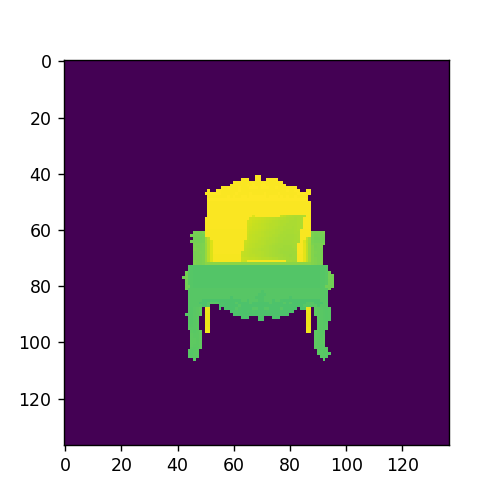

In [9]:
# render
scene = pyrender.Scene()
light = pyrender.DirectionalLight(color=np.ones(3), intensity=4.0)

light_pose = np.array([[0, 0, 1, 0],
                        [0, 1, 0, 0],
                        [1, 0, 0, 0],
                        [0, 0, 0, 1]])

scene.add(light, pose=RotatePhi(75)@RotateAzimuth(45))
pc = pyrender.IntrinsicsCamera(f_u, f_v, u_0, v_0, znear=0.15*CAM_MAX_DIST, zfar=1.15*CAM_MAX_DIST)
nc = pyrender.Node(camera=pc, matrix=np.eye(4))
scene.add_node(nc)
r = pyrender.OffscreenRenderer(137, 137)


# test function to check the transformed voxel with corresponding depth image
%matplotlib notebook

with open(SHAPENET_PATH + 'ShapeNet/fileList/03001627_test.lst', 'r') as f:
    index_dir = f.read().splitlines()

idx = 0
render_idx = 9


model_dir = path_model + index_dir[idx] + '/'
depth_dir = path_depth + index_dir[idx] + '/'
voxel_dir = path_voxel + index_dir[idx] + '/'


depth_list = sorted(glob(depth_dir + 'rendering/*.png'))
voxel_list = sorted(glob(voxel_dir + '*.binvox'))
model_list = sorted(glob(model_dir + '*.obj'))[0]

mesh_py = pymesh.load_mesh(model_list)
model = trimesh.Trimesh(mesh_py.vertices,mesh_py.faces)
mesh = pyrender.Mesh.from_trimesh(model)


nm = pyrender.Node(mesh=mesh, matrix=np.eye(4))
scene.add_node(nm)


with open(depth_dir + 'rendering/rendering_metadata.txt', 'r') as f:
        content = f.readlines()

with open(voxel_list[0], 'rb') as f:
    voxel = binvox_rw.read_as_3d_array(f).data

vox_torch = torch.tensor(voxel, dtype=torch.float).unsqueeze(0).unsqueeze(0)
target_line = content[render_idx][0:-1].split(' ')
azimuth, elevation, in_plane_rotation, distance, fov = [float(target_line[i]) for i in range(len(target_line))]

print(distance)

target_vox = (get_transformed_vox(vox_torch, azimuth, elevation) > 0.125).float()

depth_img = Image.open(depth_list[render_idx])

#plotImg(depth_img)
#plotFromVoxels(target_vox.numpy()[0])
#plotFromVoxels(sdf_vox.numpy()[0] == 0)

scene.set_pose(nm, pose = RotateAlongAxis(0, 0, 1, 0) @ RotateAzimuth(-0) @ RotatePhi(-90))

camera_pose = np.array([[0.0, 0.0, 1.0, CAM_MAX_DIST*distance],
                        [1.0, 0.0, -0.0, 0.0],
                        [0.0, 1.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 1.0]])

scene.set_pose(nc, pose = camera_pose)

#pyrender.Viewer(scene, use_raymond_lighting=True)

depth_map = r.render(scene, pyrender.constants.RenderFlags.DEPTH_ONLY)

depth_map = depth_map/(CAM_MAX_DIST * 1.15)

plotImg(depth_map)

scene.remove_node(nm)

In [11]:
cam_coords = K_inv[:3, :3] @ pixel_coords * depth_map.flatten()
cam_coords = cam_coords[:, np.where(np.logical_and(cam_coords[2] > 0.15/1.15, cam_coords[2] < 1))[0]]
cam_coords[2] -= distance/1.15
#cam_coords = cam_coords*ratio

In [17]:
np.min(cam_coords[0])

-0.12577251318970364

In [20]:
np.max(cam_coords[2])

0.12016482184870891

In [21]:
np.min(cam_coords[2])

-0.13066547085301228

### Code for discrete model dataset

In [6]:
import skimage

In [7]:
from scipy.ndimage.morphology import binary_dilation, binary_erosion

In [8]:
def get_trimap(vox_torch):
    
    voxel = vox_torch[0].numpy()
    
    background = (1 - binary_dilation(voxel)).astype(bool)
    foreground = binary_erosion(voxel).astype(bool)
    unknown = (1-(background | foreground))
    
    trimap = 0*background.astype(int) + 1*unknown.astype(int) + 2*foreground.astype(int)
    
    return torch.from_numpy(trimap).unsqueeze(0)

In [ ]:
#################################################
# transform voxel and generate discrete dataset #
#################################################

import time

with open(SHAPENET_PATH + 'ShapeNet/fileList/03001627_test.lst', 'r') as f:
    index_dir = f.read().splitlines()

if not os.path.exists(path_h5):
    os.makedirs(path_h5)

hf = h5py.File(path_h5 + 'data_demo.h5', 'w')

idx_ls = np.arange(100)

for idx in idx_ls:
    
    depth_dir = path_depth + index_dir[idx] + '/'
    voxel_dir = path_voxel + index_dir[idx] + '/'
    model_dir = path_model + index_dir[idx] + '/'
    
    start_time = time.time()
    print(idx)
    
    depth_list = sorted(glob(depth_dir + 'rendering/*.png'))
    voxel_list = sorted(glob(voxel_dir + '*.binvox'))
    model_list = sorted(glob(model_dir + '*.obj'))
    
    mesh_py = pymesh.load_mesh(model_list[0])
    radius = np.max(np.linalg.norm(mesh_py.vertices, axis = 1))
    bound = np.max(np.abs(mesh_py.bbox))
    
    scale = radius/bound
    
    with open(voxel_list[0], 'rb') as f:
        voxel = binvox_rw.read_as_3d_array(f).data
        
    vox_torch = torch.tensor(voxel, dtype=torch.float).unsqueeze(0).unsqueeze(0)
    
    dir_name = depth_dir.split('/')[-2]
    
    with open(depth_dir + 'rendering/rendering_metadata.txt', 'r') as f:
        content = f.readlines()
    
    for render_idx in range(len(content)):
        
        g = hf.create_group(dir_name + '_' + str(render_idx))
    
        target_line = content[render_idx][0:-1].split(' ')
        azimuth, elevation, in_plane_rotation, distance, fov = [float(target_line[i]) for i in range(len(target_line))]
        
        depth_img = skimage.io.imread(depth_list[render_idx])/255
        
        target_vox = (get_transformed_vox(vox_torch, azimuth, elevation, scale) > 0.125).float()
        
        trimap = get_trimap(target_vox)
        
        depth_img = Image.open(depth_list[render_idx])
        
        transformed_vertices = get_transformed_indices(mesh_py.vertices, azimuth, elevation, 1)
        gt_radius = np.max(np.linalg.norm(transformed_vertices, axis = 1))
        
        g.create_dataset('depth_img',data=depth_img, compression='gzip')
        g.create_dataset('azimuth',data=azimuth)
        g.create_dataset('elevation',data=elevation)
        g.create_dataset('distance',data=distance)
        g.create_dataset('target_vox',data=target_vox, compression='gzip')
        g.create_dataset('trimap',data=trimap, compression='gzip')
        g.create_dataset('gt_mesh_vertices',data=transformed_vertices/gt_radius, compression='gzip')
        g.create_dataset('gt_mesh_faces',data=mesh_py.faces, compression='gzip')
        
    print("--- %s seconds ---" % (time.time() - start_time))
    
hf.close()

0
--- 3.056514263153076 seconds ---
1


array([[-0.246842 , -0.254646 , -0.0366207],
       [ 0.171549 , -0.254446 ,  0.0746207],
       [-0.246842 , -0.254646 ,  0.0746207],
       ...,
       [-0.240807 , -0.326325 ,  0.280418 ],
       [-0.240807 , -0.310667 ,  0.280418 ],
       [-0.240807 , -0.310667 ,  0.169177 ]])

array([[   0,    6,    3],
       [   6,    0,    5],
       [   6,    7,    3],
       ...,
       [2579, 2582, 2580],
       [2582, 2580, 2581],
       [2581, 2580, 2582]], dtype=int32)

<IPython.core.display.Javascript object>


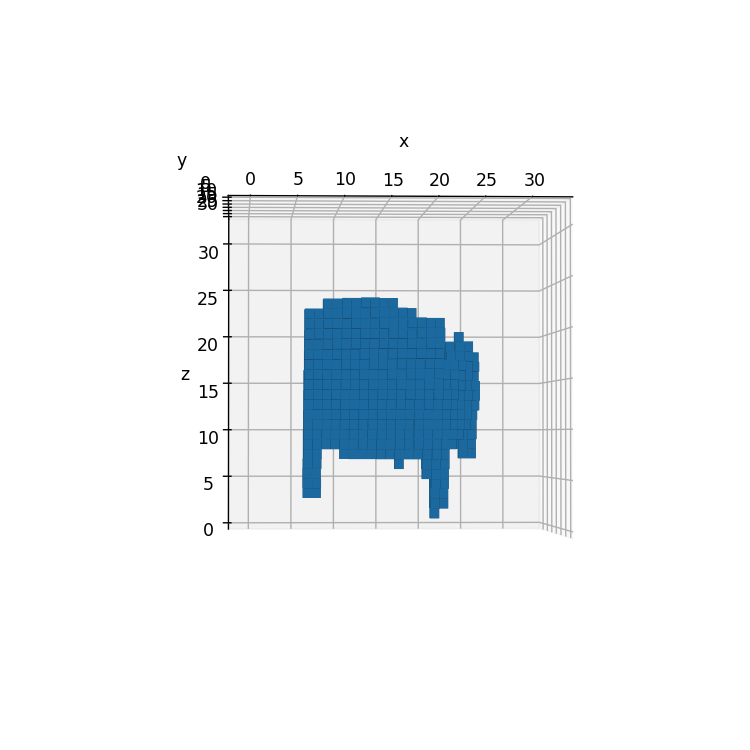

In [139]:
plotFromVoxels(target_vox[0])

## UNET

In [44]:
#################################################
# transform voxel and generate discrete dataset #
#################################################

import time

with open(SHAPENET_PATH + 'ShapeNet/fileList/03001627_train.lst', 'r') as f:
    index_dir = f.read().splitlines()

if not os.path.exists(path_h5):
    os.makedirs(path_h5)

hf = h5py.File(path_h5 + 'unet_trimap.h5', 'w')


for idx in range(len(index_dir)):
    
    depth_dir = path_depth + index_dir[idx] + '/'
    voxel_dir = path_voxel + index_dir[idx] + '/'
    
    start_time = time.time()
    print(idx)
    
    depth_list = sorted(glob(depth_dir + 'rendering/*.png'))
    voxel_list = sorted(glob(voxel_dir + '*.binvox'))
    
    with open(voxel_list[0], 'rb') as f:
        voxel = binvox_rw.read_as_3d_array(f).data
        
    vox_torch = torch.tensor(voxel, dtype=torch.float).unsqueeze(0).unsqueeze(0)
    
    dir_name = depth_dir.split('/')[-2]
    
    with open(depth_dir + 'rendering/rendering_metadata.txt', 'r') as f:
        content = f.readlines()
    
    for render_idx in range(len(content)):
        
        g = hf.create_group(dir_name + '_' + str(render_idx))
    
        target_line = content[render_idx][0:-1].split(' ')
        azimuth, elevation, in_plane_rotation, distance, fov = [float(target_line[i]) for i in range(len(target_line))]
        
        target_vox = (get_transformed_vox(vox_torch, azimuth, elevation) > 0.125).float()
        trimap = get_trimap(target_vox)
        
        depth_img = Image.open(depth_list[render_idx])
        
        g.create_dataset('model_id',data=dir_name)
        g.create_dataset('depth_img',data=depth_img, compression='gzip')
        g.create_dataset('target_vox',data=target_vox, compression='gzip')
        g.create_dataset('trimap',data=trimap, compression='gzip')
        
    print("--- %s seconds ---" % (time.time() - start_time))
    
hf.close()

0
--- 2.7745542526245117 seconds ---
1
--- 0.17372536659240723 seconds ---
2
--- 0.2613499164581299 seconds ---
3
--- 0.18099546432495117 seconds ---
4
--- 0.18945646286010742 seconds ---
5
--- 0.17823100090026855 seconds ---
6
--- 0.18067216873168945 seconds ---
7
--- 0.17970919609069824 seconds ---
8
--- 0.22778916358947754 seconds ---
9
--- 0.18697428703308105 seconds ---
10
--- 0.2430408000946045 seconds ---
11
--- 0.20696592330932617 seconds ---
12
--- 0.74556565284729 seconds ---
13
--- 0.1923825740814209 seconds ---
14
--- 0.20775556564331055 seconds ---
15
--- 0.23433184623718262 seconds ---
16
--- 0.21955037117004395 seconds ---
17
--- 0.19851374626159668 seconds ---
18
--- 0.20119667053222656 seconds ---
19
--- 0.21520543098449707 seconds ---
20
--- 0.19135499000549316 seconds ---
21
--- 0.19402456283569336 seconds ---
22
--- 0.17724299430847168 seconds ---
23
--- 0.18450641632080078 seconds ---
24
--- 0.20505404472351074 seconds ---
25
--- 0.2141587734222412 seconds ---
26
-

--- 0.2530100345611572 seconds ---
211
--- 0.23515081405639648 seconds ---
212
--- 0.22569608688354492 seconds ---
213
--- 0.23966526985168457 seconds ---
214
--- 0.29249048233032227 seconds ---
215
--- 0.2771782875061035 seconds ---
216
--- 0.23323607444763184 seconds ---
217
--- 0.21764826774597168 seconds ---
218
--- 0.20645427703857422 seconds ---
219
--- 0.21688389778137207 seconds ---
220
--- 0.20220232009887695 seconds ---
221
--- 0.24583888053894043 seconds ---
222
--- 0.40903496742248535 seconds ---
223
--- 0.4393017292022705 seconds ---
224
--- 0.4398691654205322 seconds ---
225
--- 0.43646955490112305 seconds ---
226
--- 0.4472784996032715 seconds ---
227
--- 0.4433283805847168 seconds ---
228
--- 0.44821810722351074 seconds ---
229
--- 0.43162965774536133 seconds ---
230
--- 0.4370601177215576 seconds ---
231
--- 0.43291163444519043 seconds ---
232
--- 0.30956435203552246 seconds ---
233
--- 0.2593972682952881 seconds ---
234
--- 0.264190673828125 seconds ---
235
--- 0.2588

--- 0.2694540023803711 seconds ---
419
--- 0.2566099166870117 seconds ---
420
--- 0.2549324035644531 seconds ---
421
--- 0.2554891109466553 seconds ---
422
--- 0.26569247245788574 seconds ---
423
--- 0.27042365074157715 seconds ---
424
--- 0.2601020336151123 seconds ---
425
--- 0.26540350914001465 seconds ---
426
--- 0.26703310012817383 seconds ---
427
--- 0.26238369941711426 seconds ---
428
--- 0.25874948501586914 seconds ---
429
--- 0.26034092903137207 seconds ---
430
--- 0.2634623050689697 seconds ---
431
--- 0.26723742485046387 seconds ---
432
--- 0.2611563205718994 seconds ---
433
--- 0.255495548248291 seconds ---
434
--- 0.2734551429748535 seconds ---
435
--- 0.26746106147766113 seconds ---
436
--- 0.2668485641479492 seconds ---
437
--- 0.27398228645324707 seconds ---
438
--- 0.2591288089752197 seconds ---
439
--- 0.2178950309753418 seconds ---
440
--- 0.24872374534606934 seconds ---
441
--- 0.2312300205230713 seconds ---
442
--- 0.2620358467102051 seconds ---
443
--- 0.261893987

--- 0.2525157928466797 seconds ---
627
--- 0.2563338279724121 seconds ---
628
--- 0.258542537689209 seconds ---
629
--- 0.25363612174987793 seconds ---
630
--- 0.25246119499206543 seconds ---
631
--- 0.2565131187438965 seconds ---
632
--- 0.2533895969390869 seconds ---
633
--- 0.2519693374633789 seconds ---
634
--- 0.2540872097015381 seconds ---
635
--- 0.2534365653991699 seconds ---
636
--- 0.3355851173400879 seconds ---
637
--- 0.43650341033935547 seconds ---
638
--- 0.26218152046203613 seconds ---
639
--- 0.24911999702453613 seconds ---
640
--- 0.2532997131347656 seconds ---
641
--- 0.25361061096191406 seconds ---
642
--- 0.2505455017089844 seconds ---
643
--- 0.24999237060546875 seconds ---
644
--- 0.2509348392486572 seconds ---
645
--- 0.2550084590911865 seconds ---
646
--- 0.25286173820495605 seconds ---
647
--- 0.25170469284057617 seconds ---
648
--- 0.25145983695983887 seconds ---
649
--- 0.2509794235229492 seconds ---
650
--- 0.2574028968811035 seconds ---
651
--- 0.2547142505

--- 0.3579261302947998 seconds ---
836
--- 0.20644307136535645 seconds ---
837
--- 0.21266579627990723 seconds ---
838
--- 0.22216176986694336 seconds ---
839
--- 0.2115483283996582 seconds ---
840
--- 0.21942496299743652 seconds ---
841
--- 0.21268391609191895 seconds ---
842
--- 0.25307655334472656 seconds ---
843
--- 0.2515416145324707 seconds ---
844
--- 0.2585735321044922 seconds ---
845
--- 0.2528820037841797 seconds ---
846
--- 0.25562334060668945 seconds ---
847
--- 0.25415873527526855 seconds ---
848
--- 0.25048160552978516 seconds ---
849
--- 0.24936771392822266 seconds ---
850
--- 0.25610780715942383 seconds ---
851
--- 0.2515292167663574 seconds ---
852
--- 0.2502140998840332 seconds ---
853
--- 0.2551586627960205 seconds ---
854
--- 0.25153183937072754 seconds ---
855
--- 0.2587320804595947 seconds ---
856
--- 0.25887060165405273 seconds ---
857
--- 0.2559053897857666 seconds ---
858
--- 0.258068323135376 seconds ---
859
--- 0.2547764778137207 seconds ---
860
--- 0.2548763

--- 0.2108604907989502 seconds ---
1043
--- 0.21636199951171875 seconds ---
1044
--- 0.21020197868347168 seconds ---
1045
--- 0.2143237590789795 seconds ---
1046
--- 0.21082282066345215 seconds ---
1047
--- 0.21637272834777832 seconds ---
1048
--- 0.21080470085144043 seconds ---
1049
--- 0.21160340309143066 seconds ---
1050
--- 0.22166204452514648 seconds ---
1051
--- 0.21053051948547363 seconds ---
1052
--- 0.2152872085571289 seconds ---
1053
--- 0.21640419960021973 seconds ---
1054
--- 0.21115970611572266 seconds ---
1055
--- 0.21711087226867676 seconds ---
1056
--- 0.21419668197631836 seconds ---
1057
--- 0.21118950843811035 seconds ---
1058
--- 0.2150735855102539 seconds ---
1059
--- 0.21109580993652344 seconds ---
1060
--- 0.22475051879882812 seconds ---
1061
--- 0.20833396911621094 seconds ---
1062
--- 0.21751761436462402 seconds ---
1063
--- 0.22200250625610352 seconds ---
1064
--- 0.21832823753356934 seconds ---
1065
--- 0.2131965160369873 seconds ---
1066
--- 0.214067935943603

--- 0.25565648078918457 seconds ---
1246
--- 0.23177742958068848 seconds ---
1247
--- 0.22007346153259277 seconds ---
1248
--- 0.21651935577392578 seconds ---
1249
--- 0.22073054313659668 seconds ---
1250
--- 0.21695446968078613 seconds ---
1251
--- 0.2594277858734131 seconds ---
1252
--- 0.252063512802124 seconds ---
1253
--- 0.251190185546875 seconds ---
1254
--- 0.25104618072509766 seconds ---
1255
--- 0.2520573139190674 seconds ---
1256
--- 0.25655674934387207 seconds ---
1257
--- 0.249924898147583 seconds ---
1258
--- 0.2520143985748291 seconds ---
1259
--- 0.25418901443481445 seconds ---
1260
--- 0.2492678165435791 seconds ---
1261
--- 0.25339484214782715 seconds ---
1262
--- 0.24843645095825195 seconds ---
1263
--- 0.24953436851501465 seconds ---
1264
--- 0.2518336772918701 seconds ---
1265
--- 0.25412464141845703 seconds ---
1266
--- 0.2500269412994385 seconds ---
1267
--- 0.2577207088470459 seconds ---
1268
--- 0.24583864212036133 seconds ---
1269
--- 0.2498013973236084 second

--- 0.2549881935119629 seconds ---
1449
--- 0.25151562690734863 seconds ---
1450
--- 0.25186824798583984 seconds ---
1451
--- 0.25267529487609863 seconds ---
1452
--- 0.2508063316345215 seconds ---
1453
--- 0.2556741237640381 seconds ---
1454
--- 0.25521230697631836 seconds ---
1455
--- 0.25051188468933105 seconds ---
1456
--- 0.2518019676208496 seconds ---
1457
--- 0.25161242485046387 seconds ---
1458
--- 0.2541658878326416 seconds ---
1459
--- 0.2557082176208496 seconds ---
1460
--- 0.2517828941345215 seconds ---
1461
--- 0.25243282318115234 seconds ---
1462
--- 0.24881744384765625 seconds ---
1463
--- 0.2521941661834717 seconds ---
1464
--- 0.25403666496276855 seconds ---
1465
--- 0.2513132095336914 seconds ---
1466
--- 0.24816179275512695 seconds ---
1467
--- 0.2554001808166504 seconds ---
1468
--- 0.2522468566894531 seconds ---
1469
--- 0.2523012161254883 seconds ---
1470
--- 0.2578442096710205 seconds ---
1471
--- 0.25020337104797363 seconds ---
1472
--- 0.25382423400878906 secon

--- 0.21679282188415527 seconds ---
1652
--- 0.22198152542114258 seconds ---
1653
--- 0.22484731674194336 seconds ---
1654
--- 0.2129535675048828 seconds ---
1655
--- 0.21780014038085938 seconds ---
1656
--- 0.21217608451843262 seconds ---
1657
--- 0.21606945991516113 seconds ---
1658
--- 0.44734907150268555 seconds ---
1659
--- 0.4415476322174072 seconds ---
1660
--- 0.43320322036743164 seconds ---
1661
--- 0.43672895431518555 seconds ---
1662
--- 0.435335636138916 seconds ---
1663
--- 0.44130587577819824 seconds ---
1664
--- 0.43519067764282227 seconds ---
1665
--- 0.44048237800598145 seconds ---
1666
--- 0.4374704360961914 seconds ---
1667
--- 0.4346499443054199 seconds ---
1668
--- 0.4401853084564209 seconds ---
1669
--- 0.43711423873901367 seconds ---
1670
--- 0.43543577194213867 seconds ---
1671
--- 0.43991827964782715 seconds ---
1672
--- 0.4372129440307617 seconds ---
1673
--- 0.33632755279541016 seconds ---
1674
--- 0.2541477680206299 seconds ---
1675
--- 0.3421008586883545 se

--- 0.21639084815979004 seconds ---
1855
--- 0.21943306922912598 seconds ---
1856
--- 0.2181835174560547 seconds ---
1857
--- 0.21236205101013184 seconds ---
1858
--- 0.22421860694885254 seconds ---
1859
--- 0.21497464179992676 seconds ---
1860
--- 0.21410107612609863 seconds ---
1861
--- 0.25670433044433594 seconds ---
1862
--- 0.2572906017303467 seconds ---
1863
--- 0.259533166885376 seconds ---
1864
--- 0.2568624019622803 seconds ---
1865
--- 0.25421714782714844 seconds ---
1866
--- 0.25356292724609375 seconds ---
1867
--- 0.2535226345062256 seconds ---
1868
--- 0.2554655075073242 seconds ---
1869
--- 0.25140810012817383 seconds ---
1870
--- 0.25442051887512207 seconds ---
1871
--- 0.2559211254119873 seconds ---
1872
--- 0.25483131408691406 seconds ---
1873
--- 0.253368616104126 seconds ---
1874
--- 0.253662109375 seconds ---
1875
--- 0.25201845169067383 seconds ---
1876
--- 0.25596117973327637 seconds ---
1877
--- 0.25467848777770996 seconds ---
1878
--- 0.25534892082214355 seconds

--- 0.21545195579528809 seconds ---
2058
--- 0.21746230125427246 seconds ---
2059
--- 0.21554160118103027 seconds ---
2060
--- 0.2206408977508545 seconds ---
2061
--- 0.2156381607055664 seconds ---
2062
--- 0.21420812606811523 seconds ---
2063
--- 0.21830463409423828 seconds ---
2064
--- 0.21291279792785645 seconds ---
2065
--- 0.21373867988586426 seconds ---
2066
--- 0.2515294551849365 seconds ---
2067
--- 0.2522125244140625 seconds ---
2068
--- 0.25887465476989746 seconds ---
2069
--- 0.2553870677947998 seconds ---
2070
--- 0.4380664825439453 seconds ---
2071
--- 0.25051045417785645 seconds ---
2072
--- 0.21506667137145996 seconds ---
2073
--- 0.2117319107055664 seconds ---
2074
--- 0.2154371738433838 seconds ---
2075
--- 0.21661639213562012 seconds ---
2076
--- 0.21964335441589355 seconds ---
2077
--- 0.22857046127319336 seconds ---
2078
--- 0.21345782279968262 seconds ---
2079
--- 0.21817708015441895 seconds ---
2080
--- 0.22431015968322754 seconds ---
2081
--- 0.21687865257263184 

--- 0.2617831230163574 seconds ---
2261
--- 0.25423359870910645 seconds ---
2262
--- 0.24831676483154297 seconds ---
2263
--- 0.24918460845947266 seconds ---
2264
--- 0.25023317337036133 seconds ---
2265
--- 0.2505631446838379 seconds ---
2266
--- 0.25197911262512207 seconds ---
2267
--- 0.24938201904296875 seconds ---
2268
--- 0.25566840171813965 seconds ---
2269
--- 0.2517979145050049 seconds ---
2270
--- 0.2511255741119385 seconds ---
2271
--- 0.24968290328979492 seconds ---
2272
--- 0.24984264373779297 seconds ---
2273
--- 0.25188136100769043 seconds ---
2274
--- 0.2518649101257324 seconds ---
2275
--- 0.24792790412902832 seconds ---
2276
--- 0.2505040168762207 seconds ---
2277
--- 0.28652477264404297 seconds ---
2278
--- 0.427187442779541 seconds ---
2279
--- 0.46140480041503906 seconds ---
2280
--- 0.21829819679260254 seconds ---
2281
--- 0.21838784217834473 seconds ---
2282
--- 0.21226716041564941 seconds ---
2283
--- 0.21678948402404785 seconds ---
2284
--- 0.2138218879699707 s

--- 0.25071239471435547 seconds ---
2463
--- 0.2518434524536133 seconds ---
2464
--- 0.2562413215637207 seconds ---
2465
--- 0.2501504421234131 seconds ---
2466
--- 0.25257349014282227 seconds ---
2467
--- 0.2503499984741211 seconds ---
2468
--- 0.25425195693969727 seconds ---
2469
--- 0.24957036972045898 seconds ---
2470
--- 0.24994564056396484 seconds ---
2471
--- 0.2536911964416504 seconds ---
2472
--- 0.25459980964660645 seconds ---
2473
--- 0.2495427131652832 seconds ---
2474
--- 0.2510652542114258 seconds ---
2475
--- 0.24899792671203613 seconds ---
2476
--- 0.2514641284942627 seconds ---
2477
--- 0.24970078468322754 seconds ---
2478
--- 0.252730131149292 seconds ---
2479
--- 0.25331950187683105 seconds ---
2480
--- 0.25760674476623535 seconds ---
2481
--- 0.2497730255126953 seconds ---
2482
--- 0.25356245040893555 seconds ---
2483
--- 0.2516055107116699 seconds ---
2484
--- 0.25241684913635254 seconds ---
2485
--- 0.25218725204467773 seconds ---
2486
--- 0.2528407573699951 secon

--- 0.24981427192687988 seconds ---
2665
--- 0.2495262622833252 seconds ---
2666
--- 0.24868035316467285 seconds ---
2667
--- 0.2489478588104248 seconds ---
2668
--- 0.25022435188293457 seconds ---
2669
--- 0.25157666206359863 seconds ---
2670
--- 0.2501790523529053 seconds ---
2671
--- 0.25006818771362305 seconds ---
2672
--- 0.25001955032348633 seconds ---
2673
--- 0.24853873252868652 seconds ---
2674
--- 0.24881410598754883 seconds ---
2675
--- 0.2519538402557373 seconds ---
2676
--- 0.2536146640777588 seconds ---
2677
--- 0.25070738792419434 seconds ---
2678
--- 0.25178074836730957 seconds ---
2679
--- 0.21155738830566406 seconds ---
2680
--- 0.21464872360229492 seconds ---
2681
--- 0.21434354782104492 seconds ---
2682
--- 0.2157607078552246 seconds ---
2683
--- 0.21532464027404785 seconds ---
2684
--- 0.22208333015441895 seconds ---
2685
--- 0.21456050872802734 seconds ---
2686
--- 0.2138516902923584 seconds ---
2687
--- 0.21227335929870605 seconds ---
2688
--- 0.21734309196472168

--- 0.2583913803100586 seconds ---
2868
--- 0.25012731552124023 seconds ---
2869
--- 0.25223851203918457 seconds ---
2870
--- 0.2535209655761719 seconds ---
2871
--- 0.25289273262023926 seconds ---
2872
--- 0.25187087059020996 seconds ---
2873
--- 0.2669670581817627 seconds ---
2874
--- 0.22243785858154297 seconds ---
2875
--- 0.2124485969543457 seconds ---
2876
--- 0.21104073524475098 seconds ---
2877
--- 0.21127796173095703 seconds ---
2878
--- 0.21521258354187012 seconds ---
2879
--- 0.21336007118225098 seconds ---
2880
--- 0.4233224391937256 seconds ---
2881
--- 0.42888855934143066 seconds ---
2882
--- 0.43527770042419434 seconds ---
2883
--- 0.4282867908477783 seconds ---
2884
--- 0.4296731948852539 seconds ---
2885
--- 0.42943716049194336 seconds ---
2886
--- 0.43097376823425293 seconds ---
2887
--- 0.22124052047729492 seconds ---
2888
--- 0.20813584327697754 seconds ---
2889
--- 0.24752473831176758 seconds ---
2890
--- 0.20698094367980957 seconds ---
2891
--- 0.21992731094360352

--- 0.24900603294372559 seconds ---
3070
--- 0.2497110366821289 seconds ---
3071
--- 0.2461376190185547 seconds ---
3072
--- 0.24747776985168457 seconds ---
3073
--- 0.24703717231750488 seconds ---
3074
--- 0.24766802787780762 seconds ---
3075
--- 0.24646711349487305 seconds ---
3076
--- 0.24970149993896484 seconds ---
3077
--- 0.25348687171936035 seconds ---
3078
--- 0.2523207664489746 seconds ---
3079
--- 0.2479112148284912 seconds ---
3080
--- 0.3845810890197754 seconds ---
3081
--- 0.43132686614990234 seconds ---
3082
--- 0.44008636474609375 seconds ---
3083
--- 0.43293213844299316 seconds ---
3084
--- 0.43947815895080566 seconds ---
3085
--- 0.43605971336364746 seconds ---
3086
--- 0.2455906867980957 seconds ---
3087
--- 0.2501697540283203 seconds ---
3088
--- 0.2553215026855469 seconds ---
3089
--- 0.2585761547088623 seconds ---
3090
--- 0.24984478950500488 seconds ---
3091
--- 0.2502155303955078 seconds ---
3092
--- 0.2516655921936035 seconds ---
3093
--- 0.24996685981750488 sec

--- 0.2146892547607422 seconds ---
3273
--- 0.22305870056152344 seconds ---
3274
--- 0.21119117736816406 seconds ---
3275
--- 0.21778225898742676 seconds ---
3276
--- 0.2482929229736328 seconds ---
3277
--- 0.2478940486907959 seconds ---
3278
--- 0.24956607818603516 seconds ---
3279
--- 0.2490401268005371 seconds ---
3280
--- 0.2520570755004883 seconds ---
3281
--- 0.25256848335266113 seconds ---
3282
--- 0.2512838840484619 seconds ---
3283
--- 0.25279712677001953 seconds ---
3284
--- 0.25623607635498047 seconds ---
3285
--- 0.2557361125946045 seconds ---
3286
--- 0.25261783599853516 seconds ---
3287
--- 0.2502579689025879 seconds ---
3288
--- 0.2531399726867676 seconds ---
3289
--- 0.2540113925933838 seconds ---
3290
--- 0.2503941059112549 seconds ---
3291
--- 0.2503347396850586 seconds ---
3292
--- 0.2517409324645996 seconds ---
3293
--- 0.25241732597351074 seconds ---
3294
--- 0.25174689292907715 seconds ---
3295
--- 0.2515223026275635 seconds ---
3296
--- 0.25806379318237305 second

--- 0.43552374839782715 seconds ---
3476
--- 0.43805384635925293 seconds ---
3477
--- 0.4345273971557617 seconds ---
3478
--- 0.43472862243652344 seconds ---
3479
--- 0.44012928009033203 seconds ---
3480
--- 0.4337441921234131 seconds ---
3481
--- 0.33776378631591797 seconds ---
3482
--- 0.21053671836853027 seconds ---
3483
--- 0.2515103816986084 seconds ---
3484
--- 0.25370073318481445 seconds ---
3485
--- 0.25205230712890625 seconds ---
3486
--- 0.2502274513244629 seconds ---
3487
--- 0.24876117706298828 seconds ---
3488
--- 0.2488088607788086 seconds ---
3489
--- 0.2516813278198242 seconds ---
3490
--- 0.251758337020874 seconds ---
3491
--- 0.2549138069152832 seconds ---
3492
--- 0.2545650005340576 seconds ---
3493
--- 0.2541821002960205 seconds ---
3494
--- 0.2510652542114258 seconds ---
3495
--- 0.24982690811157227 seconds ---
3496
--- 0.2507047653198242 seconds ---
3497
--- 0.2503845691680908 seconds ---
3498
--- 0.24982976913452148 seconds ---
3499
--- 0.28052377700805664 second

--- 0.21637201309204102 seconds ---
3679
--- 0.21669721603393555 seconds ---
3680
--- 0.21218347549438477 seconds ---
3681
--- 0.2189326286315918 seconds ---
3682
--- 0.21451425552368164 seconds ---
3683
--- 0.2836787700653076 seconds ---
3684
--- 0.4372875690460205 seconds ---
3685
--- 0.4388883113861084 seconds ---
3686
--- 0.4372844696044922 seconds ---
3687
--- 0.4348268508911133 seconds ---
3688
--- 0.4351379871368408 seconds ---
3689
--- 0.43134236335754395 seconds ---
3690
--- 0.461578369140625 seconds ---
3691
--- 0.44708967208862305 seconds ---
3692
--- 0.4363741874694824 seconds ---
3693
--- 0.43187570571899414 seconds ---
3694
--- 0.439272403717041 seconds ---
3695
--- 0.43251776695251465 seconds ---
3696
--- 0.4346122741699219 seconds ---
3697
--- 0.43435120582580566 seconds ---
3698
--- 0.4332246780395508 seconds ---
3699
--- 0.43533968925476074 seconds ---
3700
--- 0.4321634769439697 seconds ---
3701
--- 0.4335196018218994 seconds ---
3702
--- 0.43347883224487305 seconds 

--- 0.24890565872192383 seconds ---
3881
--- 0.3237345218658447 seconds ---
3882
--- 0.41834306716918945 seconds ---
3883
--- 0.42085790634155273 seconds ---
3884
--- 0.4264814853668213 seconds ---
3885
--- 0.4189131259918213 seconds ---
3886
--- 0.41918230056762695 seconds ---
3887
--- 0.4202873706817627 seconds ---
3888
--- 0.4205038547515869 seconds ---
3889
--- 0.4260852336883545 seconds ---
3890
--- 0.42565250396728516 seconds ---
3891
--- 0.42985963821411133 seconds ---
3892
--- 0.42807507514953613 seconds ---
3893
--- 0.3408341407775879 seconds ---
3894
--- 0.2506403923034668 seconds ---
3895
--- 0.2603890895843506 seconds ---
3896
--- 0.2549738883972168 seconds ---
3897
--- 0.25106072425842285 seconds ---
3898
--- 0.25699496269226074 seconds ---
3899
--- 0.2539792060852051 seconds ---
3900
--- 0.2538726329803467 seconds ---
3901
--- 0.25048375129699707 seconds ---
3902
--- 0.3276364803314209 seconds ---
3903
--- 0.435260534286499 seconds ---
3904
--- 0.41786861419677734 seconds

--- 0.4347870349884033 seconds ---
4083
--- 0.4396090507507324 seconds ---
4084
--- 0.42493748664855957 seconds ---
4085
--- 0.42690348625183105 seconds ---
4086
--- 0.2731504440307617 seconds ---
4087
--- 0.2162783145904541 seconds ---
4088
--- 0.21182560920715332 seconds ---
4089
--- 0.21765828132629395 seconds ---
4090
--- 0.21593308448791504 seconds ---
4091
--- 0.22502636909484863 seconds ---
4092
--- 0.21584606170654297 seconds ---
4093
--- 0.22037363052368164 seconds ---
4094
--- 0.2150557041168213 seconds ---
4095
--- 0.2250199317932129 seconds ---
4096
--- 0.2166285514831543 seconds ---
4097
--- 0.22054648399353027 seconds ---
4098
--- 0.2167668342590332 seconds ---
4099
--- 0.23638677597045898 seconds ---
4100
--- 0.4476196765899658 seconds ---
4101
--- 0.44341087341308594 seconds ---
4102
--- 0.264542818069458 seconds ---
4103
--- 0.21759915351867676 seconds ---
4104
--- 0.21496939659118652 seconds ---
4105
--- 0.22514557838439941 seconds ---
4106
--- 0.2202308177947998 seco

--- 0.2171781063079834 seconds ---
4285
--- 0.2232809066772461 seconds ---
4286
--- 0.21715378761291504 seconds ---
4287
--- 0.22772479057312012 seconds ---
4288
--- 0.21593642234802246 seconds ---
4289
--- 0.22359752655029297 seconds ---
4290
--- 0.2164306640625 seconds ---
4291
--- 0.22577118873596191 seconds ---
4292
--- 0.21604681015014648 seconds ---
4293
--- 0.25020384788513184 seconds ---
4294
--- 0.25326013565063477 seconds ---
4295
--- 0.25858259201049805 seconds ---
4296
--- 0.4723646640777588 seconds ---
4297
--- 0.44310641288757324 seconds ---
4298
--- 0.3429288864135742 seconds ---
4299
--- 0.255479097366333 seconds ---
4300
--- 0.2570168972015381 seconds ---
4301
--- 0.4389302730560303 seconds ---
4302
--- 0.43537211418151855 seconds ---
4303
--- 0.4382028579711914 seconds ---
4304
--- 0.439328670501709 seconds ---
4305
--- 0.43894243240356445 seconds ---
4306
--- 0.4381980895996094 seconds ---
4307
--- 0.43059349060058594 seconds ---
4308
--- 0.44261693954467773 seconds 

--- 0.4422171115875244 seconds ---
4488
--- 0.4428741931915283 seconds ---
4489
--- 0.43775391578674316 seconds ---
4490
--- 0.44486474990844727 seconds ---
4491
--- 0.4394192695617676 seconds ---
4492
--- 0.4424784183502197 seconds ---
4493
--- 0.34087204933166504 seconds ---
4494
--- 0.21710538864135742 seconds ---
4495
--- 0.22063136100769043 seconds ---
4496
--- 0.21900725364685059 seconds ---
4497
--- 0.21826672554016113 seconds ---
4498
--- 0.22072839736938477 seconds ---
4499
--- 0.21313858032226562 seconds ---
4500
--- 0.21683549880981445 seconds ---
4501
--- 0.21433162689208984 seconds ---
4502
--- 0.22379612922668457 seconds ---
4503
--- 0.2429797649383545 seconds ---
4504
--- 0.216264009475708 seconds ---
4505
--- 0.2228987216949463 seconds ---
4506
--- 0.21785449981689453 seconds ---
4507
--- 0.21470284461975098 seconds ---
4508
--- 0.2183094024658203 seconds ---
4509
--- 0.44707798957824707 seconds ---
4510
--- 0.4447035789489746 seconds ---
4511
--- 0.4402585029602051 sec

--- 0.2865874767303467 seconds ---
4691
--- 0.43689870834350586 seconds ---
4692
--- 0.43232154846191406 seconds ---
4693
--- 0.44402194023132324 seconds ---
4694
--- 0.3498268127441406 seconds ---
4695
--- 0.2134838104248047 seconds ---
4696
--- 0.21747565269470215 seconds ---
4697
--- 0.21522736549377441 seconds ---
4698
--- 0.21729445457458496 seconds ---
4699
--- 0.21243762969970703 seconds ---
4700
--- 0.21968650817871094 seconds ---
4701
--- 0.21606111526489258 seconds ---
4702
--- 0.2243351936340332 seconds ---
4703
--- 0.2125391960144043 seconds ---
4704
--- 0.21756339073181152 seconds ---
4705
--- 0.21285390853881836 seconds ---
4706
--- 0.21754980087280273 seconds ---
4707
--- 0.21243739128112793 seconds ---
4708
--- 0.21177148818969727 seconds ---
4709
--- 0.21891117095947266 seconds ---
4710
--- 0.21700334548950195 seconds ---
4711
--- 0.21902871131896973 seconds ---
4712
--- 0.21419334411621094 seconds ---
4713
--- 0.21578192710876465 seconds ---
4714
--- 0.215173482894897

--- 0.4383866786956787 seconds ---
4894
--- 0.44110846519470215 seconds ---
4895
--- 0.44104790687561035 seconds ---
4896
--- 0.43555712699890137 seconds ---
4897
--- 0.44167327880859375 seconds ---
4898
--- 0.4404585361480713 seconds ---
4899
--- 0.4405970573425293 seconds ---
4900
--- 0.4415409564971924 seconds ---
4901
--- 0.44158172607421875 seconds ---
4902
--- 0.44123411178588867 seconds ---
4903
--- 0.44185876846313477 seconds ---
4904
--- 0.3186225891113281 seconds ---
4905
--- 0.2529482841491699 seconds ---
4906
--- 0.25483036041259766 seconds ---
4907
--- 0.2596297264099121 seconds ---
4908
--- 0.25635576248168945 seconds ---
4909
--- 0.25945448875427246 seconds ---
4910
--- 0.2627696990966797 seconds ---
4911
--- 0.26267099380493164 seconds ---
4912
--- 0.26218438148498535 seconds ---
4913
--- 0.2594766616821289 seconds ---
4914
--- 0.25722670555114746 seconds ---
4915
--- 0.25448083877563477 seconds ---
4916
--- 0.25587010383605957 seconds ---
4917
--- 0.2575197219848633 se

--- 0.2535738945007324 seconds ---
5097
--- 0.2593393325805664 seconds ---
5098
--- 0.2539229393005371 seconds ---
5099
--- 0.2534353733062744 seconds ---
5100
--- 0.25776195526123047 seconds ---
5101
--- 0.2541835308074951 seconds ---
5102
--- 0.2572007179260254 seconds ---
5103
--- 0.25687098503112793 seconds ---
5104
--- 0.25714993476867676 seconds ---
5105
--- 0.2627296447753906 seconds ---
5106
--- 0.25804877281188965 seconds ---
5107
--- 0.2571601867675781 seconds ---
5108
--- 0.2560708522796631 seconds ---
5109
--- 0.2537832260131836 seconds ---
5110
--- 0.25499916076660156 seconds ---
5111
--- 0.25348353385925293 seconds ---
5112
--- 0.2575821876525879 seconds ---
5113
--- 0.2592782974243164 seconds ---
5114
--- 0.261549711227417 seconds ---
5115
--- 0.2575054168701172 seconds ---
5116
--- 0.26302409172058105 seconds ---
5117
--- 0.25838255882263184 seconds ---
5118
--- 0.2545595169067383 seconds ---
5119
--- 0.2548820972442627 seconds ---
5120
--- 0.25669240951538086 seconds -

### Code for sampling sdf from mesh

In [18]:
# convert sdf to voxel
def sdf2Voxel_new(sample_pt, sample_sdf_val, fill = 0, voxsize = 32):
    
    sample_pt = ((sample_pt + np.array([0.5, 0.5, 0.5]))* voxsize).astype(int)
    sample_pt = np.clip(sample_pt, 0, voxsize-1)
    
    v = fill * np.ones((voxsize, voxsize, voxsize))
    v[sample_pt[:,0], sample_pt[:,1], sample_pt[:,2]] = sample_sdf_val
    
    return v

In [9]:
f59627a077dcc2566c63b8b48495261a

NameError: name 'f59627a077dcc2566c63b8b48495261a' is not defined

In [10]:
['1b7bef12c554c1244c686b8271245d1b',
 '586b90e4b5e0530935836c728d324152',
 'e8e586ccf4dcac74cad9a65dbad13fea',
 'f59627a077dcc2566c63b8b48495261a',
 '98cb91189f35e5f57c311bdc1462c34a',
 '36ced137933c36a3ff085529822a7226',
 '108b9cb292fd811cf51f77a6d7299806',
 'a6bdde9da1322bd5116162acefe23592',
 '4f0fc7761771d073fe2cac60a76c70a',
 '6ae92754a0a90af09eb811e8e20749ae',
 '352aae8597fc6ac679c251b4a7838829',
 'c5c4e6110fbbf5d3d83578ca09f86027',
 '106e9487a1d47ff1a09cb462b3e723e2',
 'b7316f361054c8501962281db2f162a0',
 'f2aa3808b870ba95429b498f2f24a42',
 '64f885f39752807c6c63b8b48495261a']

['1b7bef12c554c1244c686b8271245d1b',
 '586b90e4b5e0530935836c728d324152',
 'e8e586ccf4dcac74cad9a65dbad13fea',
 'f59627a077dcc2566c63b8b48495261a',
 '98cb91189f35e5f57c311bdc1462c34a',
 '36ced137933c36a3ff085529822a7226',
 '108b9cb292fd811cf51f77a6d7299806',
 'a6bdde9da1322bd5116162acefe23592',
 '4f0fc7761771d073fe2cac60a76c70a',
 '6ae92754a0a90af09eb811e8e20749ae',
 '352aae8597fc6ac679c251b4a7838829',
 'c5c4e6110fbbf5d3d83578ca09f86027',
 '106e9487a1d47ff1a09cb462b3e723e2',
 'b7316f361054c8501962281db2f162a0',
 'f2aa3808b870ba95429b498f2f24a42',
 '64f885f39752807c6c63b8b48495261a']

In [ ]:
'df2b3ab36704f9e944ebbc705ad8c07'

In [9]:
model_dir_list = sorted(glob(path_model + '*/'))

idx = 0
model_list = sorted(glob(model_dir_list[idx] + '*.obj'))[0]

#model_dir = path_model + '98cb91189f35e5f57c311bdc1462c34a/'
#model_list = sorted(glob(model_dir + '*.obj'))[0]

mesh_py = pymesh.load_mesh(model_list)
mesh = trimesh.Trimesh(mesh_py.vertices, mesh_py.faces)

In [10]:
# https://github.com/marian42/mesh_to_sdf

#from mesh_to_sdf import sample_sdf_near_surface
import time
#import trimesh
#import pyrender
#import numpy as np

start_time = time.time()

points, sdf = sample_sdf_near_surface(mesh, number_of_points=10*32768, sign_method='depth', scan_count=4)

print(sdf[sdf < 0].shape[0]/10/32768)

pos_idx = np.where(sdf > 0)[0]

pos_idx_1 = pos_idx[len(pos_idx) - int(32768/4):]
pos_idx_2 = np.random.choice(pos_idx[:len(pos_idx)-int(32768/4)], int(32768/4), replace=False)
pos_idx = np.concatenate((pos_idx_1, pos_idx_2))

neg_idx = np.where(sdf <= 0)[0]

if len(neg_idx) >= int(32768/2):
    neg_idx = neg_idx[len(neg_idx) - int(32768/2):]
elif len(neg_idx) < int(32768/2):
    print('Smaller')
    neg_idx = np.random.choice(neg_idx, int(32768/2), replace=True)

sample_idx = np.concatenate((neg_idx, pos_idx))
sample_idx = np.random.choice(sample_idx, 32768, replace=False)
points = points[sample_idx,:]
sdf = sdf[sample_idx]


#points = points[sdf>0]
#sdf = sdf[sdf>0]

colors = np.zeros(points.shape)
colors[sdf < 0, 2] = 1
colors[sdf > 0, 0] = 1
cloud = pyrender.Mesh.from_points(points, colors=colors)
scene = pyrender.Scene()
scene.add(cloud)
viewer = pyrender.Viewer(scene, use_raymond_lighting=True, point_size=2)

0.3925537109375


<IPython.core.display.Javascript object>


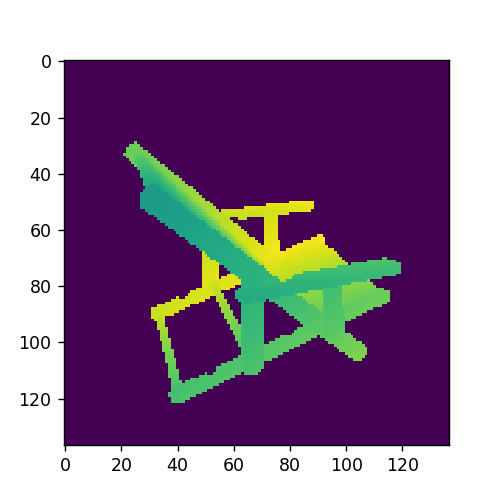

<IPython.core.display.Javascript object>


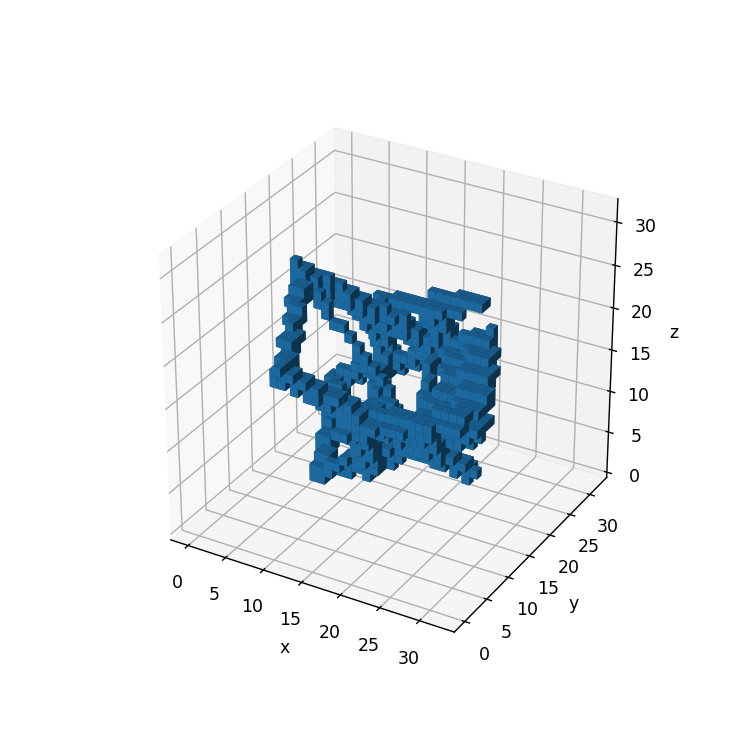

<IPython.core.display.Javascript object>


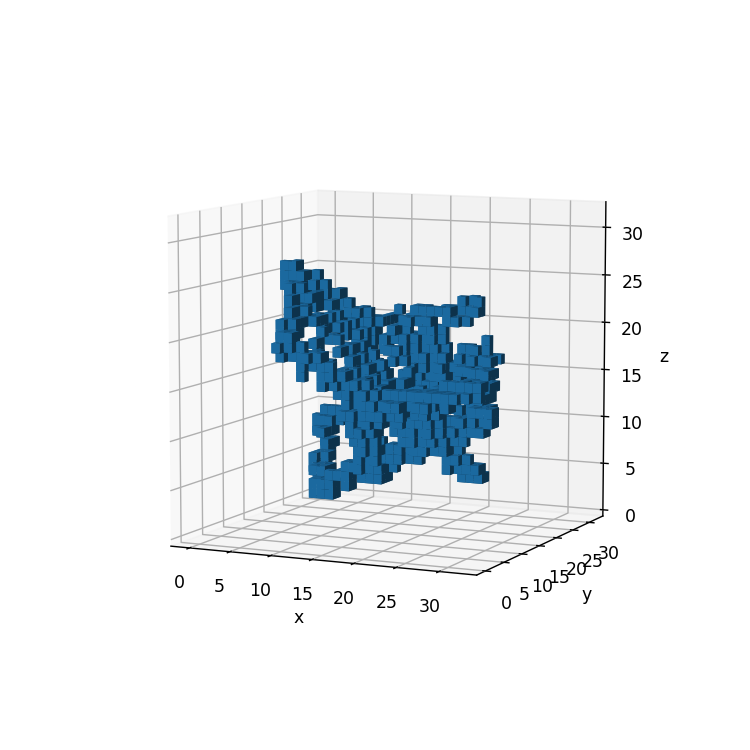

In [13]:
sample_size = 32768

# convert transformed sdf into voxel and compare it with ground-truth voxel

%matplotlib notebook 

# directory
model_dir_list = sorted(glob(path_model + '*/'))
depth_dir_list = sorted(glob(path_depth + '*/'))
voxel_dir_list = sorted(glob(path_voxel + '*/'))

idx = 100
render_idx = 2

depth_list = sorted(glob(depth_dir_list[idx] + 'rendering/*.png'))

model_list = sorted(glob(model_dir_list[idx] + '*.obj'))[0]
mesh_py = pymesh.load_mesh(model_list)

radius = np.max(np.linalg.norm(mesh_py.vertices, axis = 1))
bound = np.max(np.abs(mesh_py.bbox))
vox_scale = radius/bound

mesh = trimesh.Trimesh(mesh_py.vertices,mesh_py.faces)

#(-1, 1)
sample_pt, sample_sdf_val = sample_sdf_near_surface(mesh, number_of_points=10*sample_size, sign_method='depth', scan_count=4)


pos_idx = np.where(sample_sdf_val > 0)[0]

pos_idx_1 = pos_idx[len(pos_idx) - int(sample_size/4):]
pos_idx_2 = np.random.choice(pos_idx[:len(pos_idx)-int(sample_size/4)], int(sample_size/4), replace=False)
pos_idx = np.concatenate((pos_idx_1, pos_idx_2))
neg_idx = np.where(sample_sdf_val <= 0)[0]

if len(neg_idx) >= int(sample_size/2):
    neg_idx = neg_idx[len(neg_idx) - int(sample_size/2):]
elif len(neg_idx) < int(sample_size/2):
    print('Smaller')
    neg_idx = np.random.choice(neg_idx, int(sample_size/2), replace=True)

sample_idx = np.concatenate((neg_idx, pos_idx))
sample_idx = np.random.choice(sample_idx, sample_size, replace=False)
sample_pt = sample_pt[sample_idx,:]
sample_sdf_val = sample_sdf_val[sample_idx]

# normalize (-0.5, 0.5)
sample_pt = sample_pt/2
sample_pt = np.clip(sample_pt, -0.5, 0.5)

voxel_binvox = glob(voxel_dir_list[idx] + '*.binvox')[0]
with open(voxel_binvox, 'rb') as f:
    voxel = binvox_rw.read_as_3d_array(f).data
vox_torch = torch.tensor(voxel, dtype=torch.float).unsqueeze(0).unsqueeze(0)
    
dir_name = depth_dir_list[idx].split('/')[-2]
    
with open(depth_dir_list[idx] + 'rendering/rendering_metadata.txt', 'r') as f:
    content = f.readlines()

target_line = content[render_idx][0:-1].split(' ')
azimuth, elevation, in_plane_rotation, distance, fov = [float(target_line[i]) for i in range(len(target_line))]

depth_img = Image.open(depth_list[render_idx])
target_vox = get_transformed_vox(vox_torch, azimuth, elevation, vox_scale) > 0.125

sample_pt_rot = get_transformed_indices(sample_pt, azimuth, elevation, 1)

plotImg(depth_img)

plotFromVoxels(target_vox.numpy()[0])

v = sdf2Voxel(sample_pt_rot, sample_sdf_val)
plotFromVoxels(v < 0)

In [ ]:
    unique, unique_idx = np.unique(rescaled_pt[sorted_idx, :], axis = 0, return_index=True)
    _, unique_idx_rev = np.unique(rescaled_pt[sorted_idx_re, :], axis = 0, return_index=True)
    
    

array([0.5716593], dtype=float32)

In [188]:
sorted_rescaled_pt.shape

(32768, 3)

array([False, False, False, ..., False, False, False])

In [180]:
.shape

(7443, 3)

In [167]:
np.where(pair_max == unique[:, 0])

(array([], dtype=int64),)

In [239]:
#from scipy.spatial import KDTree

def get_extrema_product(sample_pt_rot, sample_sdf_val, vox_size = 32):
    
    vox_size= 32

    rescaled_pt = np.clip(((sample_pt_rot + 0.5)*(vox_size-1)).astype(int), 0, vox_size-1)
    unique = np.unique(rescaled_pt, axis = 0)
    count = unique.shape[0]

    max_v = [np.nan]*count
    min_v = [np.nan]*count

    for i in range(count):
        vals = sample_sdf_val[np.sum(rescaled_pt == np.tile(unique[i, :], (32768, 1)), axis = 1) == 3]

        max_v[i] = np.max(vals)
        min_v[i] = np.min(vals)
    
    maximum = np.ones((vox_size, vox_size, vox_size))*max(max_v)
    minimum = np.ones((vox_size, vox_size, vox_size))*max(min_v)
    maximum[tuple(unique[:, 0]), tuple(unique[:, 1]), tuple(unique[:, 2])] = max_v
    minimum[tuple(unique[:, 0]), tuple(unique[:, 1]), tuple(unique[:, 2])] = min_v
    
#     mask = np.ones((vox_size, vox_size, vox_size))
#     idx = np.nonzero(maximum)
#     mask[idx[0], idx[1], idx[2]] = 0
#     mask = mask.astype(bool)
    
#     x, y, z = np.mgrid[0:vox_size, 0:vox_size, 0:vox_size]

#     xyzgood = np.array((x[~mask],y[~mask], z[~mask])).T
#     xyzbad = np.array((x[mask],y[mask], z[mask])).T

#     maximum[mask] = maximum[~mask][KDTree(xyzgood).query(xyzbad)[1]]
#     minimum[mask] = minimum[~mask][KDTree(xyzgood).query(xyzbad)[1]]
    
    return maximum*minimum

In [243]:
#################################################
# Transfrom sdf and generate continuous dataset #
#################################################

import time


with open(SHAPENET_PATH + 'ShapeNet/fileList/03001627_train.lst', 'r') as f:
    index_dir = f.read().splitlines()

if not os.path.exists(path_h5):
    os.makedirs(path_h5)

hf = h5py.File(path_h5 + 'unet_core.h5', 'a', libver='latest')

for idx in range(len(index_dir)):
    
    model_dir = path_model + index_dir[idx] + '/'
    depth_dir = path_depth + index_dir[idx] + '/'
    voxel_dir = path_voxel + index_dir[idx] + '/model.binvox'
    
    
    with open(voxel_dir, 'rb') as f:
        voxel = binvox_rw.read_as_3d_array(f).data
        
    vox_torch = torch.tensor(voxel, dtype=torch.float).unsqueeze(0).unsqueeze(0)
    
    
    
    depth_list = sorted(glob(depth_dir + 'rendering/*.png'))
    
    print("Model idx: ", idx)
    start_time = time.time()
    
    model_list = sorted(glob(model_dir + '*.obj'))[0]
    mesh_py = pymesh.load_mesh(model_list)
    
    radius = np.max(np.linalg.norm(mesh_py.vertices, axis = 1))
    bound = np.max(np.abs(mesh_py.bbox))
    scale = radius/bound
    
    mesh = trimesh.Trimesh(mesh_py.vertices,mesh_py.faces)
    
    #(-1, 1)
    sample_pt, sample_sdf_val = sample_sdf_near_surface(mesh, number_of_points=10*sample_size, sign_method='depth', scan_count=4)
    
    # there is a small chance of incorrect sample size
    while sample_pt.shape[0] != 10*sample_size:
        print("wrong size, resampling")
        sample_pt, sample_sdf_val = sample_sdf_near_surface(mesh, number_of_points=10*sample_size, sign_method='depth', scan_count=4)
    
    
    
    pos_idx = np.where(sample_sdf_val > 0)[0]

    pos_idx_1 = pos_idx[len(pos_idx) - int(sample_size/4):]
    pos_idx_2 = np.random.choice(pos_idx[:len(pos_idx)-int(sample_size/4)], int(sample_size/4), replace=False)
    pos_idx = np.concatenate((pos_idx_1, pos_idx_2))

    neg_idx = np.where(sample_sdf_val <= 0)[0]

    if len(neg_idx) >= int(sample_size/2):
        neg_idx = neg_idx[len(neg_idx) - int(sample_size/2):]
    elif len(neg_idx) < int(sample_size/2):
        print('Smaller')
        neg_idx = np.random.choice(neg_idx, int(sample_size/2), replace=True)
    
    
    
    sample_idx = np.concatenate((neg_idx, pos_idx))
    sample_idx = np.random.choice(sample_idx, sample_size, replace=False)
    sample_pt = sample_pt[sample_idx,:]
    sample_sdf_val = sample_sdf_val[sample_idx]
    sample_sdf_val = np.sign(sample_sdf_val)*np.power(np.abs(sample_sdf_val), 0.25)
    
    # normalize (-0.5, 0.5)
    sample_pt = sample_pt/2
    sample_pt = np.clip(sample_pt, -0.5, 0.5)
    
    dir_name = depth_dir.split('/')[-2]
        
    with open(depth_dir + 'rendering/rendering_metadata.txt', 'r') as f:
        content = f.readlines()
        
    #print("---before rendering %s seconds ---" % (time.time() - start_time))
    
    render_idx = 0
    
    target_line = content[render_idx][0:-1].split(' ')
    azimuth, elevation, in_plane_rotation, distance, fov = [float(target_line[i]) for i in range(len(target_line))]
    target_vox = (get_transformed_vox(vox_torch, azimuth, elevation, scale) > 0.125).float()
    
    depth_img = skimage.io.imread(depth_list[render_idx])/255
    
    sample_pt_rot = get_transformed_indices(sample_pt, azimuth, elevation, 1)
    
    product = torch.from_numpy(get_extrema_product(sample_pt_rot, sample_sdf_val)).float().unsqueeze(0)
    
    g = hf.create_group(dir_name + '_' + str(render_idx) + '_' + str(i))
        
    g.create_dataset('depth_img',data=depth_img)
        
    g.create_dataset('product',data=product)
    g.create_dataset('target_vox',data=target_vox)
        
    print("--- %s seconds ---" % (time.time() - start_time))
    
hf.close()

Model idx:  0
--- 6.243086576461792 seconds ---
Model idx:  1
--- 5.4364001750946045 seconds ---
Model idx:  2
--- 6.1606574058532715 seconds ---
Model idx:  3
--- 5.3888843059539795 seconds ---
Model idx:  4
--- 5.660664796829224 seconds ---
Model idx:  5
--- 6.127585172653198 seconds ---
Model idx:  6
--- 5.8720080852508545 seconds ---
Model idx:  7
--- 5.167773723602295 seconds ---
Model idx:  8
--- 5.412534236907959 seconds ---
Model idx:  9
--- 5.820818662643433 seconds ---
Model idx:  10
--- 6.347004175186157 seconds ---
Model idx:  11
--- 5.557012557983398 seconds ---
Model idx:  12
--- 5.711599826812744 seconds ---
Model idx:  13
--- 5.714249849319458 seconds ---
Model idx:  14
--- 5.406538724899292 seconds ---
Model idx:  15
--- 5.295554876327515 seconds ---
Model idx:  16
--- 5.410729169845581 seconds ---
Model idx:  17
--- 5.437490463256836 seconds ---
Model idx:  18
--- 5.374248504638672 seconds ---
Model idx:  19
--- 6.534576892852783 seconds ---
Model idx:  20
--- 5.21904

--- 6.947557210922241 seconds ---
Model idx:  167
--- 5.544281005859375 seconds ---
Model idx:  168
--- 5.724146604537964 seconds ---
Model idx:  169
--- 5.245632171630859 seconds ---
Model idx:  170
--- 6.079361200332642 seconds ---
Model idx:  171
--- 5.47218132019043 seconds ---
Model idx:  172
--- 5.450589179992676 seconds ---
Model idx:  173
--- 6.460024356842041 seconds ---
Model idx:  174
--- 5.212075233459473 seconds ---
Model idx:  175
--- 5.234710216522217 seconds ---
Model idx:  176
--- 6.758598566055298 seconds ---
Model idx:  177
--- 5.196918725967407 seconds ---
Model idx:  178
--- 5.203579664230347 seconds ---
Model idx:  179
--- 5.635874032974243 seconds ---
Model idx:  180
--- 5.414238929748535 seconds ---
Model idx:  181
--- 5.412217140197754 seconds ---
Model idx:  182
--- 5.090760946273804 seconds ---
Model idx:  183
--- 5.9406514167785645 seconds ---
Model idx:  184
--- 6.978452444076538 seconds ---
Model idx:  185
--- 5.439407825469971 seconds ---
Model idx:  186


--- 5.710169792175293 seconds ---
Model idx:  331
--- 6.129143714904785 seconds ---
Model idx:  332
--- 5.1867640018463135 seconds ---
Model idx:  333
--- 5.4966535568237305 seconds ---
Model idx:  334
--- 5.550193786621094 seconds ---
Model idx:  335
--- 5.051364421844482 seconds ---
Model idx:  336
--- 5.687401294708252 seconds ---
Model idx:  337
--- 5.5741119384765625 seconds ---
Model idx:  338
--- 5.194438934326172 seconds ---
Model idx:  339
--- 5.444280624389648 seconds ---
Model idx:  340
--- 5.8941810131073 seconds ---
Model idx:  341
--- 5.466305732727051 seconds ---
Model idx:  342
--- 5.381689548492432 seconds ---
Model idx:  343
--- 5.579034805297852 seconds ---
Model idx:  344
--- 6.273633718490601 seconds ---
Model idx:  345
--- 6.4701738357543945 seconds ---
Model idx:  346
--- 5.800379276275635 seconds ---
Model idx:  347
--- 6.6044793128967285 seconds ---
Model idx:  348
--- 6.134866714477539 seconds ---
Model idx:  349
--- 6.612281799316406 seconds ---
Model idx:  3

--- 6.501626014709473 seconds ---
Model idx:  495
--- 5.839238882064819 seconds ---
Model idx:  496
--- 5.2446746826171875 seconds ---
Model idx:  497
--- 5.847980737686157 seconds ---
Model idx:  498
--- 5.588972568511963 seconds ---
Model idx:  499
--- 6.0236616134643555 seconds ---
Model idx:  500
--- 5.497434377670288 seconds ---
Model idx:  501
--- 6.084508180618286 seconds ---
Model idx:  502
--- 5.223669528961182 seconds ---
Model idx:  503
--- 5.384010553359985 seconds ---
Model idx:  504
--- 6.798481225967407 seconds ---
Model idx:  505
--- 7.685230016708374 seconds ---
Model idx:  506
--- 5.437768220901489 seconds ---
Model idx:  507
--- 6.39617919921875 seconds ---
Model idx:  508
--- 4.983803987503052 seconds ---
Model idx:  509
--- 5.878567934036255 seconds ---
Model idx:  510
--- 6.576732158660889 seconds ---
Model idx:  511
--- 5.835633277893066 seconds ---
Model idx:  512
--- 5.249072551727295 seconds ---
Model idx:  513
--- 5.852052450180054 seconds ---
Model idx:  514

--- 5.665071487426758 seconds ---
Model idx:  659
--- 7.3181471824646 seconds ---
Model idx:  660
--- 5.816792011260986 seconds ---
Model idx:  661
--- 6.254705905914307 seconds ---
Model idx:  662
--- 5.623225688934326 seconds ---
Model idx:  663
--- 5.428269147872925 seconds ---
Model idx:  664
--- 5.2849040031433105 seconds ---
Model idx:  665
--- 5.684204816818237 seconds ---
Model idx:  666
--- 5.088313579559326 seconds ---
Model idx:  667
--- 5.5054333209991455 seconds ---
Model idx:  668
--- 5.270346403121948 seconds ---
Model idx:  669
--- 5.430604934692383 seconds ---
Model idx:  670
--- 6.624825954437256 seconds ---
Model idx:  671
--- 5.546592712402344 seconds ---
Model idx:  672
--- 5.688803434371948 seconds ---
Model idx:  673
--- 5.802550554275513 seconds ---
Model idx:  674
--- 5.34113335609436 seconds ---
Model idx:  675
--- 5.7925498485565186 seconds ---
Model idx:  676
--- 5.110613584518433 seconds ---
Model idx:  677
--- 7.14250922203064 seconds ---
Model idx:  678
-

--- 5.750932216644287 seconds ---
Model idx:  823
--- 5.152682542800903 seconds ---
Model idx:  824
--- 7.33982515335083 seconds ---
Model idx:  825
--- 6.497575998306274 seconds ---
Model idx:  826
--- 5.671885967254639 seconds ---
Model idx:  827
--- 6.492804050445557 seconds ---
Model idx:  828
--- 5.984607458114624 seconds ---
Model idx:  829
--- 6.6053431034088135 seconds ---
Model idx:  830
--- 5.525720834732056 seconds ---
Model idx:  831
--- 5.8163440227508545 seconds ---
Model idx:  832
--- 5.55000376701355 seconds ---
Model idx:  833
--- 5.8347532749176025 seconds ---
Model idx:  834
--- 4.9948813915252686 seconds ---
Model idx:  835
--- 9.999052047729492 seconds ---
Model idx:  836
--- 6.868006706237793 seconds ---
Model idx:  837
--- 5.876516342163086 seconds ---
Model idx:  838
--- 6.69372820854187 seconds ---
Model idx:  839
--- 5.5908427238464355 seconds ---
Model idx:  840
--- 5.406482219696045 seconds ---
Model idx:  841
--- 5.676832675933838 seconds ---
Model idx:  84

--- 6.282373428344727 seconds ---
Model idx:  987
--- 5.87406587600708 seconds ---
Model idx:  988
--- 5.724779844284058 seconds ---
Model idx:  989
--- 5.437657356262207 seconds ---
Model idx:  990
--- 5.548791170120239 seconds ---
Model idx:  991
--- 7.249139785766602 seconds ---
Model idx:  992
--- 5.140231132507324 seconds ---
Model idx:  993
--- 6.03171443939209 seconds ---
Model idx:  994
--- 5.630599737167358 seconds ---
Model idx:  995
--- 5.615043878555298 seconds ---
Model idx:  996
--- 5.414228916168213 seconds ---
Model idx:  997
--- 5.991109371185303 seconds ---
Model idx:  998
--- 6.616808652877808 seconds ---
Model idx:  999
--- 5.647318601608276 seconds ---
Model idx:  1000
--- 8.61394453048706 seconds ---
Model idx:  1001
--- 6.025867700576782 seconds ---
Model idx:  1002
--- 5.3929595947265625 seconds ---
Model idx:  1003
--- 6.2830774784088135 seconds ---
Model idx:  1004
--- 9.448432445526123 seconds ---
Model idx:  1005
--- 6.660784959793091 seconds ---
Model idx: 

--- 5.545974254608154 seconds ---
Model idx:  1148
--- 6.740170001983643 seconds ---
Model idx:  1149
--- 6.748086214065552 seconds ---
Model idx:  1150
--- 6.196563720703125 seconds ---
Model idx:  1151
--- 7.703563690185547 seconds ---
Model idx:  1152
--- 5.747642517089844 seconds ---
Model idx:  1153
--- 5.578691720962524 seconds ---
Model idx:  1154
--- 5.640972375869751 seconds ---
Model idx:  1155
--- 5.58919095993042 seconds ---
Model idx:  1156
--- 5.549645662307739 seconds ---
Model idx:  1157
--- 6.190504550933838 seconds ---
Model idx:  1158
--- 5.893573760986328 seconds ---
Model idx:  1159
--- 5.805855751037598 seconds ---
Model idx:  1160
--- 5.417051792144775 seconds ---
Model idx:  1161
--- 6.979560375213623 seconds ---
Model idx:  1162
--- 5.5949671268463135 seconds ---
Model idx:  1163
--- 5.739328622817993 seconds ---
Model idx:  1164
--- 6.1626293659210205 seconds ---
Model idx:  1165
--- 5.423107147216797 seconds ---
Model idx:  1166
--- 5.452276945114136 seconds 

--- 5.488729000091553 seconds ---
Model idx:  1309
--- 5.237443447113037 seconds ---
Model idx:  1310
--- 6.52294135093689 seconds ---
Model idx:  1311
--- 5.241214752197266 seconds ---
Model idx:  1312
--- 5.699141025543213 seconds ---
Model idx:  1313
--- 5.497797012329102 seconds ---
Model idx:  1314
--- 6.014586448669434 seconds ---
Model idx:  1315
--- 6.238300800323486 seconds ---
Model idx:  1316
--- 5.369789123535156 seconds ---
Model idx:  1317
--- 5.5197765827178955 seconds ---
Model idx:  1318
--- 5.605098247528076 seconds ---
Model idx:  1319
--- 6.654141187667847 seconds ---
Model idx:  1320
--- 5.234817266464233 seconds ---
Model idx:  1321
--- 5.668925762176514 seconds ---
Model idx:  1322
--- 5.752201557159424 seconds ---
Model idx:  1323
--- 5.541671991348267 seconds ---
Model idx:  1324
--- 5.614478826522827 seconds ---
Model idx:  1325
--- 5.7805140018463135 seconds ---
Model idx:  1326
--- 6.060433387756348 seconds ---
Model idx:  1327
--- 5.294457912445068 seconds 

--- 5.305767059326172 seconds ---
Model idx:  1470
--- 5.119482517242432 seconds ---
Model idx:  1471
--- 5.420638561248779 seconds ---
Model idx:  1472
--- 5.244165658950806 seconds ---
Model idx:  1473
--- 5.06038236618042 seconds ---
Model idx:  1474
--- 5.905802488327026 seconds ---
Model idx:  1475
--- 5.439580678939819 seconds ---
Model idx:  1476
--- 5.518989562988281 seconds ---
Model idx:  1477
--- 5.490955114364624 seconds ---
Model idx:  1478
--- 6.217151641845703 seconds ---
Model idx:  1479
--- 5.310441017150879 seconds ---
Model idx:  1480
--- 5.694538116455078 seconds ---
Model idx:  1481
--- 5.16168212890625 seconds ---
Model idx:  1482
--- 5.324415683746338 seconds ---
Model idx:  1483
--- 5.187761068344116 seconds ---
Model idx:  1484
--- 5.374044418334961 seconds ---
Model idx:  1485
--- 5.391247510910034 seconds ---
Model idx:  1486
--- 5.11282205581665 seconds ---
Model idx:  1487
--- 5.334303140640259 seconds ---
Model idx:  1488
--- 5.912238359451294 seconds ---


--- 5.1827392578125 seconds ---
Model idx:  1631
--- 5.665531873703003 seconds ---
Model idx:  1632
--- 5.927521705627441 seconds ---
Model idx:  1633
--- 5.379235029220581 seconds ---
Model idx:  1634
--- 5.194039821624756 seconds ---
Model idx:  1635
--- 5.677748441696167 seconds ---
Model idx:  1636
--- 5.721456289291382 seconds ---
Model idx:  1637
--- 5.891205549240112 seconds ---
Model idx:  1638
--- 6.233214616775513 seconds ---
Model idx:  1639
--- 5.19852089881897 seconds ---
Model idx:  1640
--- 5.8208770751953125 seconds ---
Model idx:  1641
--- 6.0282933712005615 seconds ---
Model idx:  1642
--- 7.382233619689941 seconds ---
Model idx:  1643
--- 5.995270252227783 seconds ---
Model idx:  1644
--- 5.684732437133789 seconds ---
Model idx:  1645
--- 5.499451398849487 seconds ---
Model idx:  1646
--- 5.894084930419922 seconds ---
Model idx:  1647
--- 5.217156648635864 seconds ---
Model idx:  1648
--- 5.668131113052368 seconds ---
Model idx:  1649
--- 8.794842004776001 seconds --

--- 5.530578374862671 seconds ---
Model idx:  1792
--- 5.480058431625366 seconds ---
Model idx:  1793
--- 5.609119176864624 seconds ---
Model idx:  1794
--- 5.651097536087036 seconds ---
Model idx:  1795
--- 5.132814168930054 seconds ---
Model idx:  1796
--- 5.890370607376099 seconds ---
Model idx:  1797
--- 5.243076801300049 seconds ---
Model idx:  1798
--- 5.493277549743652 seconds ---
Model idx:  1799
--- 5.185557842254639 seconds ---
Model idx:  1800
--- 5.871764898300171 seconds ---
Model idx:  1801
--- 5.6514623165130615 seconds ---
Model idx:  1802
--- 5.968475580215454 seconds ---
Model idx:  1803
--- 5.19880485534668 seconds ---
Model idx:  1804
--- 5.4632408618927 seconds ---
Model idx:  1805
--- 5.894247531890869 seconds ---
Model idx:  1806
--- 5.3690290451049805 seconds ---
Model idx:  1807
--- 7.478979587554932 seconds ---
Model idx:  1808
--- 5.930819749832153 seconds ---
Model idx:  1809
--- 5.435711860656738 seconds ---
Model idx:  1810
--- 6.844985485076904 seconds --

--- 5.2082555294036865 seconds ---
Model idx:  1953
--- 5.055788040161133 seconds ---
Model idx:  1954
--- 5.327053070068359 seconds ---
Model idx:  1955
--- 5.380754470825195 seconds ---
Model idx:  1956
--- 5.324092388153076 seconds ---
Model idx:  1957
--- 5.311306476593018 seconds ---
Model idx:  1958
--- 5.832159996032715 seconds ---
Model idx:  1959
--- 6.200805187225342 seconds ---
Model idx:  1960
--- 5.227215766906738 seconds ---
Model idx:  1961
--- 5.853673934936523 seconds ---
Model idx:  1962
--- 5.756047248840332 seconds ---
Model idx:  1963
--- 5.009313344955444 seconds ---
Model idx:  1964
--- 5.867582321166992 seconds ---
Model idx:  1965
--- 5.58146071434021 seconds ---
Model idx:  1966
--- 6.613597393035889 seconds ---
Model idx:  1967
--- 5.1510374546051025 seconds ---
Model idx:  1968
--- 5.3002848625183105 seconds ---
Model idx:  1969
--- 5.2085349559783936 seconds ---
Model idx:  1970
--- 5.049615383148193 seconds ---
Model idx:  1971
--- 5.8130669593811035 secon

--- 7.227850437164307 seconds ---
Model idx:  2114
--- 5.275825262069702 seconds ---
Model idx:  2115
--- 4.79025411605835 seconds ---
Model idx:  2116
--- 5.986298322677612 seconds ---
Model idx:  2117
--- 4.880120515823364 seconds ---
Model idx:  2118
--- 5.241882562637329 seconds ---
Model idx:  2119
--- 5.799941301345825 seconds ---
Model idx:  2120
--- 5.828028440475464 seconds ---
Model idx:  2121
--- 6.350119590759277 seconds ---
Model idx:  2122
--- 5.906424522399902 seconds ---
Model idx:  2123
--- 5.653985500335693 seconds ---
Model idx:  2124
--- 6.035038471221924 seconds ---
Model idx:  2125
--- 9.601582288742065 seconds ---
Model idx:  2126
--- 5.642909526824951 seconds ---
Model idx:  2127
--- 5.231682538986206 seconds ---
Model idx:  2128
--- 5.771888256072998 seconds ---
Model idx:  2129
--- 5.2909324169158936 seconds ---
Model idx:  2130
--- 5.171598672866821 seconds ---
Model idx:  2131
--- 5.287769794464111 seconds ---
Model idx:  2132
--- 7.3854758739471436 seconds 

--- 5.6384804248809814 seconds ---
Model idx:  2275
--- 5.508220195770264 seconds ---
Model idx:  2276
--- 5.675022125244141 seconds ---
Model idx:  2277
--- 6.468089818954468 seconds ---
Model idx:  2278
--- 5.349073886871338 seconds ---
Model idx:  2279
--- 5.283506631851196 seconds ---
Model idx:  2280
--- 5.490629434585571 seconds ---
Model idx:  2281
--- 5.752759695053101 seconds ---
Model idx:  2282
--- 5.602386474609375 seconds ---
Model idx:  2283
--- 5.745872497558594 seconds ---
Model idx:  2284
--- 5.411728382110596 seconds ---
Model idx:  2285
--- 5.721555233001709 seconds ---
Model idx:  2286
--- 5.972483158111572 seconds ---
Model idx:  2287
--- 5.885098934173584 seconds ---
Model idx:  2288
--- 5.732494831085205 seconds ---
Model idx:  2289
--- 6.912609815597534 seconds ---
Model idx:  2290
--- 5.606931686401367 seconds ---
Model idx:  2291
--- 5.30902886390686 seconds ---
Model idx:  2292
--- 5.525527715682983 seconds ---
Model idx:  2293
--- 6.031507968902588 seconds -

--- 5.834003448486328 seconds ---
Model idx:  2436
--- 5.712881326675415 seconds ---
Model idx:  2437
--- 6.3008928298950195 seconds ---
Model idx:  2438
--- 5.223236799240112 seconds ---
Model idx:  2439
--- 6.162233352661133 seconds ---
Model idx:  2440
--- 5.33174991607666 seconds ---
Model idx:  2441
--- 5.818450927734375 seconds ---
Model idx:  2442
--- 5.586184024810791 seconds ---
Model idx:  2443
--- 5.722336769104004 seconds ---
Model idx:  2444
--- 7.1474597454071045 seconds ---
Model idx:  2445
--- 5.788002967834473 seconds ---
Model idx:  2446
--- 5.6424829959869385 seconds ---
Model idx:  2447
--- 6.478094577789307 seconds ---
Model idx:  2448
--- 7.67849063873291 seconds ---
Model idx:  2449
--- 5.323129653930664 seconds ---
Model idx:  2450
--- 5.503664255142212 seconds ---
Model idx:  2451
--- 5.491903066635132 seconds ---
Model idx:  2452
--- 6.12400484085083 seconds ---
Model idx:  2453
--- 5.322261810302734 seconds ---
Model idx:  2454
--- 5.3936448097229 seconds ---

--- 5.838684558868408 seconds ---
Model idx:  2597
--- 7.275222539901733 seconds ---
Model idx:  2598
--- 5.62262487411499 seconds ---
Model idx:  2599
--- 5.56423544883728 seconds ---
Model idx:  2600
--- 5.744801759719849 seconds ---
Model idx:  2601
--- 5.654628753662109 seconds ---
Model idx:  2602
--- 5.8013527393341064 seconds ---
Model idx:  2603
--- 6.727592706680298 seconds ---
Model idx:  2604
--- 5.366732597351074 seconds ---
Model idx:  2605
--- 5.333182334899902 seconds ---
Model idx:  2606
--- 9.154125928878784 seconds ---
Model idx:  2607
--- 5.347131013870239 seconds ---
Model idx:  2608
--- 7.578545093536377 seconds ---
Model idx:  2609
--- 5.162759065628052 seconds ---
Model idx:  2610
--- 5.595209121704102 seconds ---
Model idx:  2611
--- 5.436158180236816 seconds ---
Model idx:  2612
--- 5.5237061977386475 seconds ---
Model idx:  2613
--- 5.380471229553223 seconds ---
Model idx:  2614
--- 5.356210708618164 seconds ---
Model idx:  2615
--- 5.532742261886597 seconds -

--- 6.273538827896118 seconds ---
Model idx:  2758
--- 5.398269414901733 seconds ---
Model idx:  2759
--- 5.745629787445068 seconds ---
Model idx:  2760
--- 5.8446362018585205 seconds ---
Model idx:  2761
--- 5.701172828674316 seconds ---
Model idx:  2762
--- 5.627093076705933 seconds ---
Model idx:  2763
--- 5.570573806762695 seconds ---
Model idx:  2764
--- 5.3843913078308105 seconds ---
Model idx:  2765
--- 5.2857255935668945 seconds ---
Model idx:  2766
--- 5.381888389587402 seconds ---
Model idx:  2767
--- 5.807757139205933 seconds ---
Model idx:  2768
--- 5.328683853149414 seconds ---
Model idx:  2769
--- 5.418916463851929 seconds ---
Model idx:  2770
--- 5.246422290802002 seconds ---
Model idx:  2771
--- 6.095707178115845 seconds ---
Model idx:  2772
--- 6.150542497634888 seconds ---
Model idx:  2773
--- 7.079696416854858 seconds ---
Model idx:  2774
--- 5.884572267532349 seconds ---
Model idx:  2775
--- 5.715529918670654 seconds ---
Model idx:  2776
--- 5.8342554569244385 secon

--- 5.6418232917785645 seconds ---
Model idx:  2919
--- 6.145960807800293 seconds ---
Model idx:  2920
--- 5.59578537940979 seconds ---
Model idx:  2921
--- 5.611961126327515 seconds ---
Model idx:  2922
--- 6.296184062957764 seconds ---
Model idx:  2923
--- 5.598361015319824 seconds ---
Model idx:  2924
--- 5.877048015594482 seconds ---
Model idx:  2925
--- 5.914927959442139 seconds ---
Model idx:  2926
--- 5.649006366729736 seconds ---
Model idx:  2927
--- 5.4449076652526855 seconds ---
Model idx:  2928
--- 6.153078556060791 seconds ---
Model idx:  2929
--- 5.271543025970459 seconds ---
Model idx:  2930
--- 5.568865060806274 seconds ---
Model idx:  2931
--- 5.762026071548462 seconds ---
Model idx:  2932
--- 5.9342567920684814 seconds ---
Model idx:  2933
--- 5.614141225814819 seconds ---
Model idx:  2934
--- 5.7254908084869385 seconds ---
Model idx:  2935
--- 8.124853134155273 seconds ---
Model idx:  2936
--- 5.970804929733276 seconds ---
Model idx:  2937
--- 5.999615907669067 second

--- 5.0258400440216064 seconds ---
Model idx:  3080
--- 5.1385719776153564 seconds ---
Model idx:  3081
--- 5.949376821517944 seconds ---
Model idx:  3082
--- 5.7878334522247314 seconds ---
Model idx:  3083
--- 6.134937524795532 seconds ---
Model idx:  3084
--- 5.30403995513916 seconds ---
Model idx:  3085
--- 6.354043006896973 seconds ---
Model idx:  3086
--- 6.147071361541748 seconds ---
Model idx:  3087
--- 6.147199869155884 seconds ---
Model idx:  3088
--- 5.803065061569214 seconds ---
Model idx:  3089
--- 7.098968982696533 seconds ---
Model idx:  3090
--- 5.673657655715942 seconds ---
Model idx:  3091
--- 6.149442911148071 seconds ---
Model idx:  3092
--- 5.508240461349487 seconds ---
Model idx:  3093
--- 5.514942646026611 seconds ---
Model idx:  3094
--- 5.490346908569336 seconds ---
Model idx:  3095
--- 5.493078708648682 seconds ---
Model idx:  3096
--- 5.509416341781616 seconds ---
Model idx:  3097
--- 6.021823167800903 seconds ---
Model idx:  3098
--- 5.4346022605896 seconds -

--- 6.9328649044036865 seconds ---
Model idx:  3241
--- 6.487495422363281 seconds ---
Model idx:  3242
--- 5.910010576248169 seconds ---
Model idx:  3243
--- 5.034897804260254 seconds ---
Model idx:  3244
--- 6.689759016036987 seconds ---
Model idx:  3245
--- 6.553078651428223 seconds ---
Model idx:  3246
--- 6.414587020874023 seconds ---
Model idx:  3247
--- 6.44573974609375 seconds ---
Model idx:  3248
--- 7.815426349639893 seconds ---
Model idx:  3249
--- 5.836283445358276 seconds ---
Model idx:  3250
--- 6.49689245223999 seconds ---
Model idx:  3251
--- 7.4204795360565186 seconds ---
Model idx:  3252
--- 6.438019037246704 seconds ---
Model idx:  3253
--- 5.950824975967407 seconds ---
Model idx:  3254
--- 5.382040500640869 seconds ---
Model idx:  3255
--- 6.28643012046814 seconds ---
Model idx:  3256
--- 6.799028635025024 seconds ---
Model idx:  3257
--- 5.543128967285156 seconds ---
Model idx:  3258
--- 5.030000686645508 seconds ---
Model idx:  3259
--- 6.230863571166992 seconds --

--- 6.00227689743042 seconds ---
Model idx:  3402
--- 8.115554571151733 seconds ---
Model idx:  3403
--- 5.644566774368286 seconds ---
Model idx:  3404
--- 6.643831729888916 seconds ---
Model idx:  3405
--- 6.357415437698364 seconds ---
Model idx:  3406
--- 5.80462121963501 seconds ---
Model idx:  3407
--- 5.396568059921265 seconds ---
Model idx:  3408
--- 6.292845964431763 seconds ---
Model idx:  3409
--- 5.926124572753906 seconds ---
Model idx:  3410
--- 5.609018325805664 seconds ---
Model idx:  3411
--- 5.942824840545654 seconds ---
Model idx:  3412
--- 5.861610412597656 seconds ---
Model idx:  3413
--- 9.116132736206055 seconds ---
Model idx:  3414
--- 5.905630350112915 seconds ---
Model idx:  3415
--- 5.4883739948272705 seconds ---
Model idx:  3416
--- 7.973171949386597 seconds ---
Model idx:  3417
--- 6.92795205116272 seconds ---
Model idx:  3418
--- 5.492382049560547 seconds ---
Model idx:  3419
--- 6.838529348373413 seconds ---
Model idx:  3420
--- 5.9052581787109375 seconds --

--- 5.1894495487213135 seconds ---
Model idx:  3563
--- 5.349199295043945 seconds ---
Model idx:  3564
--- 5.069931983947754 seconds ---
Model idx:  3565
--- 5.4231345653533936 seconds ---
Model idx:  3566
--- 5.406543731689453 seconds ---
Model idx:  3567
--- 5.1289520263671875 seconds ---
Model idx:  3568
--- 5.615293025970459 seconds ---
Model idx:  3569
--- 6.579662322998047 seconds ---
Model idx:  3570
--- 5.26261043548584 seconds ---
Model idx:  3571
--- 5.206285715103149 seconds ---
Model idx:  3572
--- 4.950876235961914 seconds ---
Model idx:  3573
--- 6.169873237609863 seconds ---
Model idx:  3574
--- 4.890003442764282 seconds ---
Model idx:  3575
--- 6.739744186401367 seconds ---
Model idx:  3576
--- 6.0037150382995605 seconds ---
Model idx:  3577
--- 6.2912139892578125 seconds ---
Model idx:  3578
--- 5.449200868606567 seconds ---
Model idx:  3579
--- 6.530621528625488 seconds ---
Model idx:  3580
--- 5.616997480392456 seconds ---
Model idx:  3581
--- 5.209285736083984 secon

--- 5.122942924499512 seconds ---
Model idx:  3724
--- 5.273393154144287 seconds ---
Model idx:  3725
--- 5.373394250869751 seconds ---
Model idx:  3726
--- 5.84231972694397 seconds ---
Model idx:  3727
--- 5.2343621253967285 seconds ---
Model idx:  3728
--- 5.10509729385376 seconds ---
Model idx:  3729
--- 5.18985390663147 seconds ---
Model idx:  3730
--- 5.436096668243408 seconds ---
Model idx:  3731
--- 5.245570182800293 seconds ---
Model idx:  3732
--- 4.9812633991241455 seconds ---
Model idx:  3733
--- 5.095372676849365 seconds ---
Model idx:  3734
--- 5.145613193511963 seconds ---
Model idx:  3735
--- 5.3230884075164795 seconds ---
Model idx:  3736
--- 5.359530448913574 seconds ---
Model idx:  3737
--- 6.704437732696533 seconds ---
Model idx:  3738
--- 5.217210054397583 seconds ---
Model idx:  3739
--- 4.95380711555481 seconds ---
Model idx:  3740
--- 5.34456467628479 seconds ---
Model idx:  3741
--- 5.101527214050293 seconds ---
Model idx:  3742
--- 5.3389809131622314 seconds --

--- 5.1135430335998535 seconds ---
Model idx:  3885
--- 5.2338926792144775 seconds ---
Model idx:  3886
--- 6.412761688232422 seconds ---
Model idx:  3887
--- 6.781564474105835 seconds ---
Model idx:  3888
--- 5.456749439239502 seconds ---
Model idx:  3889
--- 5.290278911590576 seconds ---
Model idx:  3890
--- 5.857720136642456 seconds ---
Model idx:  3891
--- 7.000406503677368 seconds ---
Model idx:  3892
--- 7.1422624588012695 seconds ---
Model idx:  3893
--- 5.837732553482056 seconds ---
Model idx:  3894
--- 5.766390562057495 seconds ---
Model idx:  3895
--- 5.556873798370361 seconds ---
Model idx:  3896
--- 7.970596790313721 seconds ---
Model idx:  3897
--- 6.256805658340454 seconds ---
Model idx:  3898
--- 6.08626389503479 seconds ---
Model idx:  3899
--- 6.607759237289429 seconds ---
Model idx:  3900
--- 6.134287357330322 seconds ---
Model idx:  3901
--- 7.914607763290405 seconds ---
Model idx:  3902
--- 6.005735158920288 seconds ---
Model idx:  3903
--- 6.9249427318573 seconds -

--- 6.398858308792114 seconds ---
Model idx:  4046
--- 6.182259798049927 seconds ---
Model idx:  4047
--- 6.4597508907318115 seconds ---
Model idx:  4048
--- 5.380009651184082 seconds ---
Model idx:  4049
--- 5.608925819396973 seconds ---
Model idx:  4050
--- 5.57725715637207 seconds ---
Model idx:  4051
--- 5.259463548660278 seconds ---
Model idx:  4052
--- 6.0474841594696045 seconds ---
Model idx:  4053
--- 6.932191610336304 seconds ---
Model idx:  4054
--- 6.420569181442261 seconds ---
Model idx:  4055
--- 6.340255498886108 seconds ---
Model idx:  4056
--- 6.611196517944336 seconds ---
Model idx:  4057
--- 6.513750791549683 seconds ---
Model idx:  4058
--- 6.646923065185547 seconds ---
Model idx:  4059
--- 6.501032114028931 seconds ---
Model idx:  4060
--- 6.052124500274658 seconds ---
Model idx:  4061
--- 5.809250354766846 seconds ---
Model idx:  4062
--- 8.133352041244507 seconds ---
Model idx:  4063
--- 5.833247184753418 seconds ---
Model idx:  4064
--- 5.8970348834991455 seconds

--- 6.339125394821167 seconds ---
Model idx:  4207
--- 6.457158803939819 seconds ---
Model idx:  4208
--- 6.222486972808838 seconds ---
Model idx:  4209
--- 6.44342041015625 seconds ---
Model idx:  4210
--- 5.584306955337524 seconds ---
Model idx:  4211
--- 6.1410605907440186 seconds ---
Model idx:  4212
--- 6.481337785720825 seconds ---
Model idx:  4213
--- 6.972678184509277 seconds ---
Model idx:  4214
--- 6.19273567199707 seconds ---
Model idx:  4215
--- 5.81406569480896 seconds ---
Model idx:  4216
--- 6.138634443283081 seconds ---
Model idx:  4217
--- 6.387086391448975 seconds ---
Model idx:  4218
--- 6.508214473724365 seconds ---
Model idx:  4219
--- 5.831125497817993 seconds ---
Model idx:  4220
--- 6.483174085617065 seconds ---
Model idx:  4221
--- 6.466651439666748 seconds ---
Model idx:  4222
--- 5.916100263595581 seconds ---
Model idx:  4223
--- 7.004678964614868 seconds ---
Model idx:  4224
--- 5.968355655670166 seconds ---
Model idx:  4225
--- 6.700117349624634 seconds ---

--- 6.171467065811157 seconds ---
Model idx:  4368
--- 6.261446237564087 seconds ---
Model idx:  4369
--- 5.96125054359436 seconds ---
Model idx:  4370
--- 6.092348098754883 seconds ---
Model idx:  4371
--- 6.849113464355469 seconds ---
Model idx:  4372
--- 7.691842794418335 seconds ---
Model idx:  4373
--- 5.981291770935059 seconds ---
Model idx:  4374
--- 5.995971202850342 seconds ---
Model idx:  4375
--- 5.783929109573364 seconds ---
Model idx:  4376
--- 6.094688415527344 seconds ---
Model idx:  4377
--- 6.4865882396698 seconds ---
Model idx:  4378
--- 5.575912237167358 seconds ---
Model idx:  4379
--- 5.387068748474121 seconds ---
Model idx:  4380
--- 6.164401292800903 seconds ---
Model idx:  4381
--- 6.056971073150635 seconds ---
Model idx:  4382
--- 7.249871015548706 seconds ---
Model idx:  4383
--- 6.4126198291778564 seconds ---
Model idx:  4384
--- 5.822149753570557 seconds ---
Model idx:  4385
--- 6.500631093978882 seconds ---
Model idx:  4386
--- 6.668313503265381 seconds ---

--- 5.773510694503784 seconds ---
Model idx:  4529
--- 5.883981704711914 seconds ---
Model idx:  4530
--- 6.742465019226074 seconds ---
Model idx:  4531
--- 6.430377006530762 seconds ---
Model idx:  4532
--- 5.853557109832764 seconds ---
Model idx:  4533
--- 6.550062417984009 seconds ---
Model idx:  4534
--- 5.877209901809692 seconds ---
Model idx:  4535
--- 6.735533952713013 seconds ---
Model idx:  4536
--- 6.45295524597168 seconds ---
Model idx:  4537
--- 6.259337663650513 seconds ---
Model idx:  4538
--- 6.504477262496948 seconds ---
Model idx:  4539
--- 6.160002946853638 seconds ---
Model idx:  4540
--- 6.552884340286255 seconds ---
Model idx:  4541
--- 6.06647801399231 seconds ---
Model idx:  4542
--- 5.15466833114624 seconds ---
Model idx:  4543
--- 5.240581274032593 seconds ---
Model idx:  4544
--- 7.0773091316223145 seconds ---
Model idx:  4545
--- 5.7724854946136475 seconds ---
Model idx:  4546
--- 5.639691591262817 seconds ---
Model idx:  4547
--- 6.243176698684692 seconds --

--- 6.648877859115601 seconds ---
Model idx:  4690
--- 6.293554782867432 seconds ---
Model idx:  4691
--- 5.175101280212402 seconds ---
Model idx:  4692
--- 5.321997880935669 seconds ---
Model idx:  4693
--- 5.786036014556885 seconds ---
Model idx:  4694
--- 5.258716344833374 seconds ---
Model idx:  4695
--- 5.62326455116272 seconds ---
Model idx:  4696
--- 5.667492866516113 seconds ---
Model idx:  4697
--- 5.277113437652588 seconds ---
Model idx:  4698
--- 5.359851121902466 seconds ---
Model idx:  4699
--- 5.48556113243103 seconds ---
Model idx:  4700
--- 5.136483907699585 seconds ---
Model idx:  4701
--- 5.17357325553894 seconds ---
Model idx:  4702
--- 5.5909264087677 seconds ---
Model idx:  4703
--- 5.056839227676392 seconds ---
Model idx:  4704
--- 5.116275787353516 seconds ---
Model idx:  4705
--- 5.471407651901245 seconds ---
Model idx:  4706
--- 4.976457118988037 seconds ---
Model idx:  4707
--- 5.759968519210815 seconds ---
Model idx:  4708
--- 5.4530189037323 seconds ---
Mode

--- 5.164880037307739 seconds ---
Model idx:  4851
--- 5.2324652671813965 seconds ---
Model idx:  4852
--- 5.514267683029175 seconds ---
Model idx:  4853
--- 5.429127216339111 seconds ---
Model idx:  4854
--- 5.216212034225464 seconds ---
Model idx:  4855
--- 5.368201971054077 seconds ---
Model idx:  4856
--- 5.275547981262207 seconds ---
Model idx:  4857
--- 5.465483903884888 seconds ---
Model idx:  4858
--- 5.2580554485321045 seconds ---
Model idx:  4859
--- 5.501010179519653 seconds ---
Model idx:  4860
--- 5.057954549789429 seconds ---
Model idx:  4861
--- 5.134045839309692 seconds ---
Model idx:  4862
--- 6.102069616317749 seconds ---
Model idx:  4863
--- 5.176307439804077 seconds ---
Model idx:  4864
--- 6.3767571449279785 seconds ---
Model idx:  4865
--- 5.22607421875 seconds ---
Model idx:  4866
--- 6.72424578666687 seconds ---
Model idx:  4867
--- 6.554044723510742 seconds ---
Model idx:  4868
--- 5.426445722579956 seconds ---
Model idx:  4869
--- 5.6788411140441895 seconds --

--- 5.555764675140381 seconds ---
Model idx:  5012
--- 5.483924865722656 seconds ---
Model idx:  5013
--- 6.510954141616821 seconds ---
Model idx:  5014
--- 5.6187660694122314 seconds ---
Model idx:  5015
--- 7.573703765869141 seconds ---
Model idx:  5016
--- 5.882599830627441 seconds ---
Model idx:  5017
--- 6.799059867858887 seconds ---
Model idx:  5018
--- 5.833827018737793 seconds ---
Model idx:  5019
--- 6.994203567504883 seconds ---
Model idx:  5020
--- 5.977776050567627 seconds ---
Model idx:  5021
--- 5.585209846496582 seconds ---
Model idx:  5022
--- 7.15243935585022 seconds ---
Model idx:  5023
--- 6.002063274383545 seconds ---
Model idx:  5024
--- 5.231229066848755 seconds ---
Model idx:  5025
--- 5.333353042602539 seconds ---
Model idx:  5026
--- 5.337649345397949 seconds ---
Model idx:  5027
--- 5.917410135269165 seconds ---
Model idx:  5028
--- 5.467909812927246 seconds ---
Model idx:  5029
--- 5.1925132274627686 seconds ---
Model idx:  5030
--- 5.748067140579224 seconds 

--- 5.938282489776611 seconds ---
Model idx:  5173
--- 5.927778244018555 seconds ---
Model idx:  5174
--- 5.730715036392212 seconds ---
Model idx:  5175
--- 5.484068393707275 seconds ---
Model idx:  5176
--- 6.446135759353638 seconds ---
Model idx:  5177
--- 5.723382949829102 seconds ---
Model idx:  5178
--- 5.921647787094116 seconds ---
Model idx:  5179
--- 6.110012769699097 seconds ---
Model idx:  5180
--- 5.804964780807495 seconds ---
Model idx:  5181
--- 5.526443004608154 seconds ---
Model idx:  5182
--- 5.084871292114258 seconds ---
Model idx:  5183
--- 5.38111138343811 seconds ---
Model idx:  5184
--- 5.092453718185425 seconds ---
Model idx:  5185
--- 5.91472864151001 seconds ---
Model idx:  5186
--- 5.939757585525513 seconds ---
Model idx:  5187
--- 5.877046585083008 seconds ---
Model idx:  5188
--- 5.950818300247192 seconds ---
Model idx:  5189
--- 5.666363954544067 seconds ---
Model idx:  5190
--- 5.962158679962158 seconds ---
Model idx:  5191
--- 5.475126028060913 seconds ---

In [236]:
product = get_extrema_product(sample_pt_rot, sample_sdf_val)

<IPython.core.display.Javascript object>


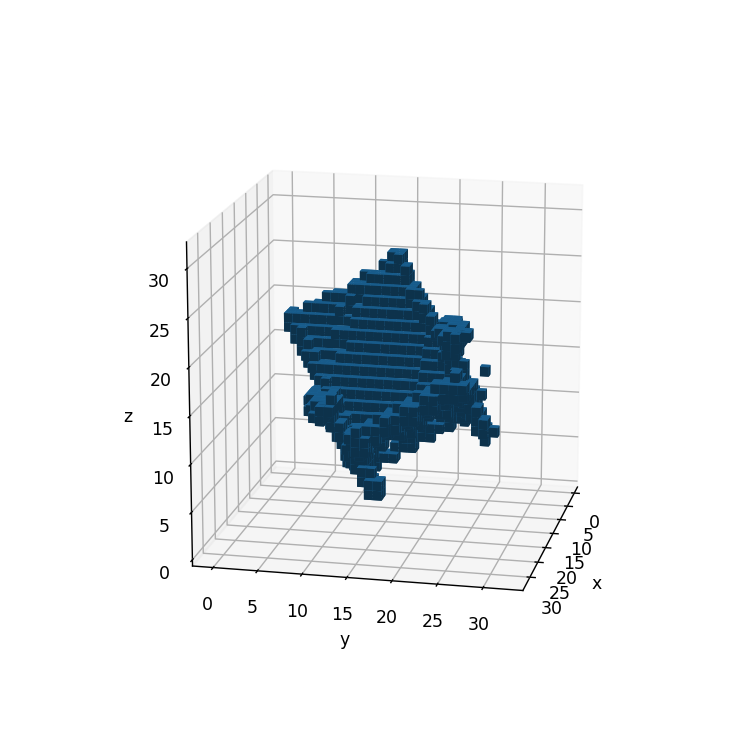

In [237]:
plotFromVoxels(product < 0)

In [ ]:

x,y=np.mgrid[0:a.shape[0],0:a.shape[1]]

xygood = np.array((x[~a.mask],y[~a.mask])).T
xybad = np.array((x[a.mask],y[a.mask])).T

a[a.mask] = a[~a.mask][KDTree(xygood).query(xybad)[1]]

print a
  [[0 1 2 3 4 5 6 7 8 9]
  [10 11 12 13 14 15 16 17 18 19]
  [20 21 22 13 14 15 16 17 28 29]
  [30 31 32 32 44 45 46 38 38 39]
  [40 41 42 43 44 45 46 47 48 49]
  [50 51 52 53 54 55 56 57 58 59]
  [60 61 62 63 64 65 66 67 68 69]
  [70 71 72 73 74 75 76 77 78 79]
  [80 81 82 83 84 85 86 87 78 89]
  [90 91 92 93 94 95 96 97 98 99]]

In [34]:
sample_pt_rot.shape

(32768, 3)

In [35]:
sample_pt = torch.from_numpy(sample_pt_rot).reshape(-1, 2048, 3)

In [36]:
sample_pt.shape

torch.Size([16, 2048, 3])

In [37]:
vox_res = 32

In [38]:
# advanced indexing 2x2x2 context from voxel
def getContext(sample_pt_query, vox):
    
    # sample_pt bxmx3
    # vox bxcxdimxdimxdim
    
    channel_size = vox.shape[1]
    batch_size, sample_size, _ = sample_pt_query.shape
    meshgrid_base = torch.Tensor(np.meshgrid(np.arange(0, batch_size), np.arange(0, channel_size), np.arange(0, 2), np.arange(0, 2), np.arange(0, 2))).int()
    context = torch.empty((batch_size, sample_size, channel_size, 2, 2, 2))

    for j in range(context.shape[1]):
        context[:, j, :, :, :, :] = vox[
                    meshgrid_base[0].long(),
                    meshgrid_base[1].long(),
                    (meshgrid_base[2] + sample_pt_query[:, j, 0].reshape(1, -1, 1, 1, 1)).long(), 
                    (meshgrid_base[3] + sample_pt_query[:, j, 1].reshape(1, -1, 1, 1, 1)).long(), 
                    (meshgrid_base[4] + sample_pt_query[:, j, 2].reshape(1, -1, 1, 1, 1)).long()
                ].transpose(0, 1)
    
    # b x c x m x 2 x 2 x 2
    return context.transpose(1, 2)

In [39]:
def trilinearInterpolation(context, dx, dy, dz):
    
    v0 = context[:, :, :, 0, 0, 0]*(1-dx)*(1-dy)*(1-dz)
    v1 = context[:, :, :, 1, 0, 0]*dx*(1-dy)*(1-dz)
    v2 = context[:, :, :, 0, 1, 0]*(1-dx)*dy*(1-dz)
    v3 = context[:, :, :, 1, 1, 0]*dx*dy*(1-dz)
    v4 = context[:, :, :, 0, 0, 1]*(1-dx)*(1-dy)*dz
    v5 = context[:, :, :, 1, 0, 1]*dx*(1-dy)*dz
    v6 = context[:, :, :, 0, 1, 1]*(1-dx)*dy*dz
    v7 = context[:, :, :, 1, 1, 1]*dx*dy*dz
    
    # b x c x m 1
    return v0 + v1 + v2 + v3 + v4 + v5 + v6 + v7

In [40]:
sample_pt_normalized = sample_pt + torch.tensor([0.5, 0.5, 0.5])
# (0, 63)
sample_pt_scale = torch.clamp(sample_pt_normalized* (vox_res-1), 0, (vox_res-1)-1e-5)
# (0, 62]
sample_pt_query = torch.clamp((sample_pt_scale).int(), 0, (vox_res-2))
sample_pt_distance = sample_pt_scale - sample_pt_query
    
vox_feature = target_vox.squeeze(0).repeat(16, 1, 1, 1, 1).detach().cpu()

context = getContext(sample_pt_query, vox_feature)

dx = sample_pt_distance[:, :, 0].unsqueeze(1)
dy = sample_pt_distance[:, :, 1].unsqueeze(1)
dz = sample_pt_distance[:, :, 2].unsqueeze(1)
# local feature

con = trilinearInterpolation(context, dx, dy, dz).reshape(-1, )

In [41]:
con.shape

torch.Size([32768])

<IPython.core.display.Javascript object>


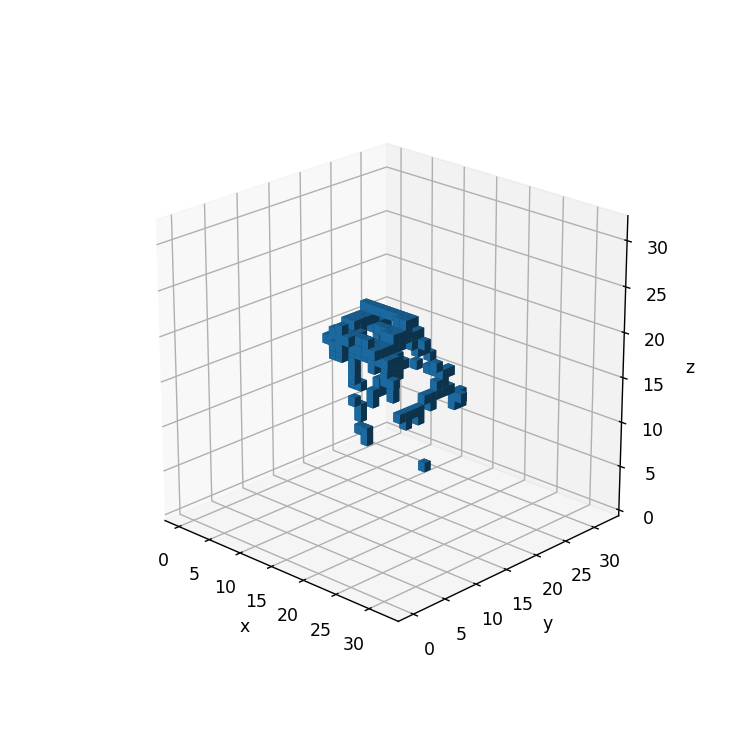

In [42]:
v_con = sdf2Voxel_new(sample_pt_rot, con.numpy())
plotFromVoxels(v_con > 0.5)

### Code for continuous model dataset

In [12]:
sample_size  = 32768

In [13]:
def getBound(sample_pt, sample_sdf_val):
    
    inner = sample_pt[sample_sdf_val <= 0]
    ls = []
    
    ls.append(np.abs(np.max(inner[:, 0])))
    ls.append(np.abs(np.min(inner[:, 0])))
    ls.append(np.abs(np.max(inner[:, 1])))
    ls.append(np.abs(np.min(inner[:, 1])))
    ls.append(np.abs(np.max(inner[:, 2])))
    ls.append(np.abs(np.min(inner[:, 2])))
    
    return np.max(ls)

In [14]:
#################################################
# Transfrom sdf and generate continuous dataset #
#################################################

import time


with open(SHAPENET_PATH + 'ShapeNet/fileList/03001627_train.lst', 'r') as f:
    index_dir = f.read().splitlines()

if not os.path.exists(path_h5):
    os.makedirs(path_h5)

hf = h5py.File(path_h5 + 'sdf_train_core.h5', 'a', libver='latest')

for idx in range(len(index_dir)):
    
    model_dir = path_model + index_dir[idx] + '/'
    depth_dir = path_depth + index_dir[idx] + '/'
    voxel_dir = path_voxel + index_dir[idx] + '/model.binvox'
    
    
    with open(voxel_dir, 'rb') as f:
        voxel = binvox_rw.read_as_3d_array(f).data
        
    vox_torch = torch.tensor(voxel, dtype=torch.float).unsqueeze(0).unsqueeze(0)
    
    
    
    depth_list = sorted(glob(depth_dir + 'rendering/*.png'))
    
    print("Model idx: ", idx)
    start_time = time.time()
    
    model_list = sorted(glob(model_dir + '*.obj'))[0]
    mesh_py = pymesh.load_mesh(model_list)
    
    radius = np.max(np.linalg.norm(mesh_py.vertices, axis = 1))
    bound = np.max(np.abs(mesh_py.bbox))
    scale = radius/bound
    
    mesh = trimesh.Trimesh(mesh_py.vertices,mesh_py.faces)
    
    #(-1, 1)
    sample_pt, sample_sdf_val = sample_sdf_near_surface(mesh, number_of_points=10*sample_size, sign_method='depth', scan_count=4)
    
    # there is a small chance of incorrect sample size
    while sample_pt.shape[0] != 10*sample_size:
        print("wrong size, resampling")
        sample_pt, sample_sdf_val = sample_sdf_near_surface(mesh, number_of_points=10*sample_size, sign_method='depth', scan_count=4)
    
    
    
    pos_idx = np.where(sample_sdf_val > 0)[0]

    pos_idx_1 = pos_idx[len(pos_idx) - int(sample_size/4):]
    pos_idx_2 = np.random.choice(pos_idx[:len(pos_idx)-int(sample_size/4)], int(sample_size/4), replace=False)
    pos_idx = np.concatenate((pos_idx_1, pos_idx_2))

    neg_idx = np.where(sample_sdf_val <= 0)[0]

    if len(neg_idx) >= int(sample_size/2):
        neg_idx = neg_idx[len(neg_idx) - int(sample_size/2):]
    elif len(neg_idx) < int(sample_size/2):
        print('Smaller')
        neg_idx = np.random.choice(neg_idx, int(sample_size/2), replace=True)
    
    
    
    sample_idx = np.concatenate((neg_idx, pos_idx))
    sample_idx = np.random.choice(sample_idx, sample_size, replace=False)
    sample_pt = sample_pt[sample_idx,:]
    sample_sdf_val = sample_sdf_val[sample_idx]
    
    # normalize (-0.5, 0.5)
    sample_pt = sample_pt/2
    sample_pt = np.clip(sample_pt, -0.5, 0.5)
    
    dir_name = depth_dir.split('/')[-2]
        
    with open(depth_dir + 'rendering/rendering_metadata.txt', 'r') as f:
        content = f.readlines()
        
    #print("---before rendering %s seconds ---" % (time.time() - start_time))
    
    render_idx = 0
    
    target_line = content[render_idx][0:-1].split(' ')
    azimuth, elevation, in_plane_rotation, distance, fov = [float(target_line[i]) for i in range(len(target_line))]
    target_vox = (get_transformed_vox(vox_torch, azimuth, elevation, scale) > 0.125).float()
    
    depth_img = skimage.io.imread(depth_list[render_idx])/255
    
    sample_pt_rot = get_transformed_indices(sample_pt, azimuth, elevation, 1)
    
    for i in range(16):
        
        start = 2048*i
        end = 2048*(i+1)
        
        g = hf.create_group(dir_name + '_' + str(render_idx) + '_' + str(i))
        
        g.create_dataset('depth_img',data=depth_img)
        
        sample_pt_batch = sample_pt_rot[start:end, :]
        sample_sdf_batch = sample_sdf_val[start:end]
        
        if sample_pt_batch.shape[0] != 2048 or sample_sdf_batch.shape[0] != 2048:
            print("Error, wrong batch size")
            break
        
        g.create_dataset('sample_pt',data=sample_pt_batch)
        g.create_dataset('sample_sdf',data=sample_sdf_batch)
        g.create_dataset('target_vox',data=target_vox)
        
    print("--- %s seconds ---" % (time.time() - start_time))
    
hf.close()

Model idx:  0
--- 2.4268686771392822 seconds ---
Model idx:  1
--- 1.3774652481079102 seconds ---
Model idx:  2
--- 1.6757822036743164 seconds ---
Model idx:  3
--- 1.1536498069763184 seconds ---
Model idx:  4
--- 1.3349034786224365 seconds ---
Model idx:  5
--- 2.174739122390747 seconds ---
Model idx:  6
--- 1.5031847953796387 seconds ---
Model idx:  7
--- 1.3017387390136719 seconds ---
Model idx:  8
--- 1.6804578304290771 seconds ---
Model idx:  9
--- 1.4126663208007812 seconds ---
Model idx:  10
--- 2.4744341373443604 seconds ---
Model idx:  11
--- 1.7241191864013672 seconds ---
Model idx:  12
--- 1.748544454574585 seconds ---
Model idx:  13
--- 1.5481054782867432 seconds ---
Model idx:  14
--- 1.703303575515747 seconds ---
Model idx:  15
--- 1.5194416046142578 seconds ---
Model idx:  16
--- 1.407926321029663 seconds ---
Model idx:  17
--- 1.8099815845489502 seconds ---
Model idx:  18
--- 1.4919288158416748 seconds ---
Model idx:  19
--- 2.5454294681549072 seconds ---
Model idx:  20

--- 1.3536288738250732 seconds ---
Model idx:  165
--- 2.693721294403076 seconds ---
Model idx:  166
--- 2.7763631343841553 seconds ---
Model idx:  167
--- 1.329329490661621 seconds ---
Model idx:  168
--- 1.3856394290924072 seconds ---
Model idx:  169
--- 1.4061596393585205 seconds ---
Model idx:  170
--- 2.106905937194824 seconds ---
Model idx:  171
--- 1.8186101913452148 seconds ---
Model idx:  172
--- 1.516082525253296 seconds ---
Model idx:  173
--- 2.348015785217285 seconds ---
Model idx:  174
--- 1.2291181087493896 seconds ---
Model idx:  175
--- 1.3912692070007324 seconds ---
Model idx:  176
--- 2.8539977073669434 seconds ---
Model idx:  177
--- 1.338127851486206 seconds ---
Model idx:  178
--- 1.2990272045135498 seconds ---
Model idx:  179
--- 1.82669997215271 seconds ---
Model idx:  180
--- 1.242568016052246 seconds ---
Model idx:  181
--- 1.2503464221954346 seconds ---
Model idx:  182
--- 1.1969287395477295 seconds ---
Model idx:  183
--- 2.0833542346954346 seconds ---
Model

--- 2.3172733783721924 seconds ---
Model idx:  327
--- 1.2032017707824707 seconds ---
Model idx:  328
--- 1.6646888256072998 seconds ---
Model idx:  329
--- 2.2041611671447754 seconds ---
Model idx:  330
--- 1.5081210136413574 seconds ---
Model idx:  331
--- 1.7194788455963135 seconds ---
Model idx:  332
--- 1.191631555557251 seconds ---
Model idx:  333
--- 1.4883062839508057 seconds ---
Model idx:  334
--- 1.548964262008667 seconds ---
Model idx:  335
--- 1.252124309539795 seconds ---
Model idx:  336
--- 1.754882574081421 seconds ---
Model idx:  337
--- 1.469761848449707 seconds ---
Model idx:  338
--- 1.3452117443084717 seconds ---
Model idx:  339
--- 1.4607295989990234 seconds ---
Model idx:  340
--- 2.1037657260894775 seconds ---
Model idx:  341
--- 1.689206600189209 seconds ---
Model idx:  342
--- 1.3185760974884033 seconds ---
Model idx:  343
--- 1.4785683155059814 seconds ---
Model idx:  344
--- 1.5919601917266846 seconds ---
Model idx:  345
--- 2.536837100982666 seconds ---
Mod

--- 5.985509395599365 seconds ---
Model idx:  489
--- 1.2714202404022217 seconds ---
Model idx:  490
--- 1.5141346454620361 seconds ---
Model idx:  491
--- 1.1022849082946777 seconds ---
Model idx:  492
--- 1.6224133968353271 seconds ---
Model idx:  493
--- 1.534813642501831 seconds ---
Model idx:  494
--- 2.510205030441284 seconds ---
Model idx:  495
--- 1.559891939163208 seconds ---
Model idx:  496
--- 1.4278297424316406 seconds ---
Model idx:  497
--- 1.7458295822143555 seconds ---
Model idx:  498
--- 1.4534530639648438 seconds ---
Model idx:  499
--- 1.8097484111785889 seconds ---
Model idx:  500
--- 1.325052261352539 seconds ---
Model idx:  501
--- 1.9288966655731201 seconds ---
Model idx:  502
--- 1.257936716079712 seconds ---
Model idx:  503
--- 1.5487515926361084 seconds ---
Model idx:  504
--- 3.1815195083618164 seconds ---
Model idx:  505
--- 3.7244913578033447 seconds ---
Model idx:  506
--- 1.4771146774291992 seconds ---
Model idx:  507
--- 1.9431548118591309 seconds ---
Mo

--- 3.345820903778076 seconds ---
Model idx:  651
--- 1.499927043914795 seconds ---
Model idx:  652
--- 1.2670376300811768 seconds ---
Model idx:  653
--- 2.0426201820373535 seconds ---
Model idx:  654
--- 2.395232677459717 seconds ---
Model idx:  655
--- 1.719721794128418 seconds ---
Model idx:  656
--- 1.3530139923095703 seconds ---
Model idx:  657
--- 2.2097764015197754 seconds ---
Model idx:  658
--- 1.2302939891815186 seconds ---
Model idx:  659
--- 2.966780185699463 seconds ---
Model idx:  660
--- 1.836338758468628 seconds ---
Model idx:  661
--- 2.4235339164733887 seconds ---
Model idx:  662
--- 1.635179042816162 seconds ---
Model idx:  663
--- 1.2729122638702393 seconds ---
Model idx:  664
--- 1.3113257884979248 seconds ---
Model idx:  665
--- 1.7570922374725342 seconds ---
Model idx:  666
--- 1.213860034942627 seconds ---
Model idx:  667
--- 1.4818692207336426 seconds ---
Model idx:  668
--- 1.9358651638031006 seconds ---
Model idx:  669
--- 1.1571941375732422 seconds ---
Mode

--- 2.073307514190674 seconds ---
Model idx:  813
--- 1.3283705711364746 seconds ---
Model idx:  814
--- 1.7729239463806152 seconds ---
Model idx:  815
--- 2.536055564880371 seconds ---
Model idx:  816
--- 1.399237871170044 seconds ---
Model idx:  817
--- 1.3472113609313965 seconds ---
Model idx:  818
--- 1.7427451610565186 seconds ---
Model idx:  819
--- 1.2911286354064941 seconds ---
Model idx:  820
--- 1.2828960418701172 seconds ---
Model idx:  821
--- 2.6480202674865723 seconds ---
Model idx:  822
--- 1.531386375427246 seconds ---
Model idx:  823
--- 1.1602866649627686 seconds ---
Model idx:  824
--- 3.025280237197876 seconds ---
Model idx:  825
--- 2.4552228450775146 seconds ---
Model idx:  826
--- 1.7148747444152832 seconds ---
Model idx:  827
--- 2.12654709815979 seconds ---
Model idx:  828
--- 1.6320528984069824 seconds ---
Model idx:  829
--- 2.0706562995910645 seconds ---
Model idx:  830
--- 1.4845330715179443 seconds ---
Model idx:  831
--- 1.6247801780700684 seconds ---
Mod

--- 1.9078497886657715 seconds ---
Model idx:  975
--- 2.0220556259155273 seconds ---
Model idx:  976
--- 2.1747169494628906 seconds ---
Model idx:  977
--- 5.587442398071289 seconds ---
Model idx:  978
--- 1.28261137008667 seconds ---
Model idx:  979
--- 1.2721383571624756 seconds ---
Model idx:  980
--- 1.2961740493774414 seconds ---
Model idx:  981
--- 1.604562759399414 seconds ---
Model idx:  982
--- 1.2876770496368408 seconds ---
Model idx:  983
--- 2.489489793777466 seconds ---
Model idx:  984
--- 1.8583612442016602 seconds ---
Model idx:  985
--- 1.3220164775848389 seconds ---
Model idx:  986
--- 2.013812303543091 seconds ---
Model idx:  987
--- 1.6145062446594238 seconds ---
Model idx:  988
--- 1.4570975303649902 seconds ---
Model idx:  989
--- 1.3587357997894287 seconds ---
Model idx:  990
--- 1.5171942710876465 seconds ---
Model idx:  991
--- 1.6100833415985107 seconds ---
Model idx:  992
--- 1.206164836883545 seconds ---
Model idx:  993
--- 1.9932012557983398 seconds ---
Mod

--- 1.5166137218475342 seconds ---
Model idx:  1134
--- 1.260061264038086 seconds ---
Model idx:  1135
--- 2.2554192543029785 seconds ---
Model idx:  1136
--- 1.2449114322662354 seconds ---
Model idx:  1137
--- 2.066821336746216 seconds ---
Model idx:  1138
--- 3.6483705043792725 seconds ---
Model idx:  1139
--- 1.221743106842041 seconds ---
Model idx:  1140
--- 1.8576228618621826 seconds ---
Model idx:  1141
--- 2.6000685691833496 seconds ---
Model idx:  1142
--- 1.3198223114013672 seconds ---
Model idx:  1143
--- 2.2857720851898193 seconds ---
Model idx:  1144
--- 1.3225700855255127 seconds ---
Model idx:  1145
--- 1.8201868534088135 seconds ---
Model idx:  1146
--- 1.4895873069763184 seconds ---
Model idx:  1147
--- 1.4943547248840332 seconds ---
Model idx:  1148
--- 2.2216014862060547 seconds ---
Model idx:  1149
--- 2.675819158554077 seconds ---
Model idx:  1150
--- 2.1488804817199707 seconds ---
Model idx:  1151
--- 1.5435583591461182 seconds ---
Model idx:  1152
--- 1.5259234905

--- 2.0408554077148438 seconds ---
Model idx:  1293
--- 1.3503711223602295 seconds ---
Model idx:  1294
--- 1.488539218902588 seconds ---
Model idx:  1295
--- 1.2340047359466553 seconds ---
Model idx:  1296
--- 2.09836483001709 seconds ---
Model idx:  1297
--- 2.406846046447754 seconds ---
Model idx:  1298
--- 1.4035940170288086 seconds ---
Model idx:  1299
--- 1.118499755859375 seconds ---
Model idx:  1300
--- 1.4861304759979248 seconds ---
Model idx:  1301
--- 1.6193537712097168 seconds ---
Model idx:  1302
--- 1.3218994140625 seconds ---
Model idx:  1303
--- 2.333021402359009 seconds ---
Model idx:  1304
--- 1.3810837268829346 seconds ---
Model idx:  1305
--- 2.1073157787323 seconds ---
Model idx:  1306
--- 1.4148802757263184 seconds ---
Model idx:  1307
--- 1.4389927387237549 seconds ---
Model idx:  1308
--- 1.4083166122436523 seconds ---
Model idx:  1309
--- 1.2713379859924316 seconds ---
Model idx:  1310
--- 1.7373993396759033 seconds ---
Model idx:  1311
--- 1.3359355926513672 s

--- 1.2232117652893066 seconds ---
Model idx:  1452
--- 1.690542221069336 seconds ---
Model idx:  1453
--- 1.44743013381958 seconds ---
Model idx:  1454
--- 1.450544834136963 seconds ---
Model idx:  1455
--- 1.352433204650879 seconds ---
Model idx:  1456
--- 1.6003217697143555 seconds ---
Model idx:  1457
--- 1.517822265625 seconds ---
Model idx:  1458
--- 1.3286511898040771 seconds ---
Model idx:  1459
--- 1.734645128250122 seconds ---
Model idx:  1460
--- 1.7429180145263672 seconds ---
Model idx:  1461
--- 1.2019367218017578 seconds ---
Model idx:  1462
--- 1.3192734718322754 seconds ---
Model idx:  1463
--- 1.4084463119506836 seconds ---
Model idx:  1464
--- 1.3764374256134033 seconds ---
Model idx:  1465
--- 1.7054572105407715 seconds ---
Model idx:  1466
--- 2.137779951095581 seconds ---
Model idx:  1467
--- 1.2515199184417725 seconds ---
Model idx:  1468
--- 1.3334684371948242 seconds ---
Model idx:  1469
--- 1.5238850116729736 seconds ---
Model idx:  1470
--- 1.407252550125122 s

--- 1.349599838256836 seconds ---
Model idx:  1611
--- 1.4232454299926758 seconds ---
Model idx:  1612
--- 2.7127041816711426 seconds ---
Model idx:  1613
--- 1.5057084560394287 seconds ---
Model idx:  1614
--- 2.3812851905822754 seconds ---
Model idx:  1615
--- 1.8119053840637207 seconds ---
Model idx:  1616
--- 3.67637038230896 seconds ---
Model idx:  1617
--- 1.2423572540283203 seconds ---
Model idx:  1618
--- 1.5142662525177002 seconds ---
Model idx:  1619
--- 1.2642176151275635 seconds ---
Model idx:  1620
--- 1.6084342002868652 seconds ---
Model idx:  1621
--- 1.4842989444732666 seconds ---
Model idx:  1622
--- 2.0993876457214355 seconds ---
Model idx:  1623
--- 4.0918192863464355 seconds ---
Model idx:  1624
--- 1.3952322006225586 seconds ---
Model idx:  1625
--- 1.3470466136932373 seconds ---
Model idx:  1626
--- 1.3246519565582275 seconds ---
Model idx:  1627
--- 2.251248598098755 seconds ---
Model idx:  1628
--- 1.8016459941864014 seconds ---
Model idx:  1629
--- 2.1698813438

--- 1.423520565032959 seconds ---
Model idx:  1770
--- 1.4528570175170898 seconds ---
Model idx:  1771
--- 1.453632116317749 seconds ---
Model idx:  1772
--- 1.3684086799621582 seconds ---
Model idx:  1773
--- 1.4486544132232666 seconds ---
Model idx:  1774
--- 1.6356639862060547 seconds ---
Model idx:  1775
--- 1.5426888465881348 seconds ---
Model idx:  1776
--- 1.3365447521209717 seconds ---
Model idx:  1777
--- 1.6353485584259033 seconds ---
Model idx:  1778
--- 1.2458181381225586 seconds ---
Model idx:  1779
--- 2.267641067504883 seconds ---
Model idx:  1780
--- 1.2247991561889648 seconds ---
Model idx:  1781
--- 1.2939047813415527 seconds ---
Model idx:  1782
--- 1.5088906288146973 seconds ---
Model idx:  1783
--- 1.7426016330718994 seconds ---
Model idx:  1784
--- 1.639606237411499 seconds ---
Model idx:  1785
--- 1.3659191131591797 seconds ---
Model idx:  1786
--- 2.7866992950439453 seconds ---
Model idx:  1787
--- 2.1163926124572754 seconds ---
Model idx:  1788
--- 1.7117547988

--- 1.4112367630004883 seconds ---
Model idx:  1929
--- 1.2144298553466797 seconds ---
Model idx:  1930
--- 3.97914719581604 seconds ---
Model idx:  1931
--- 1.28790283203125 seconds ---
Model idx:  1932
--- 1.39821195602417 seconds ---
Model idx:  1933
--- 1.7910394668579102 seconds ---
Model idx:  1934
--- 1.3575952053070068 seconds ---
Model idx:  1935
--- 1.2478773593902588 seconds ---
Model idx:  1936
--- 2.1644461154937744 seconds ---
Model idx:  1937
--- 1.1852316856384277 seconds ---
Model idx:  1938
--- 1.3959977626800537 seconds ---
Model idx:  1939
--- 3.2218844890594482 seconds ---
Model idx:  1940
--- 1.36112642288208 seconds ---
Model idx:  1941
--- 1.2398040294647217 seconds ---
Model idx:  1942
--- 1.599170207977295 seconds ---
Model idx:  1943
--- 1.3519866466522217 seconds ---
Model idx:  1944
--- 4.255037069320679 seconds ---
Model idx:  1945
--- 1.648386001586914 seconds ---
Model idx:  1946
--- 2.849280595779419 seconds ---
Model idx:  1947
--- 1.6253561973571777 s

--- 1.4113202095031738 seconds ---
Model idx:  2088
--- 1.365619421005249 seconds ---
Model idx:  2089
--- 2.50005841255188 seconds ---
Model idx:  2090
--- 1.2602858543395996 seconds ---
Model idx:  2091
--- 1.7773699760437012 seconds ---
Model idx:  2092
--- 2.2785186767578125 seconds ---
Model idx:  2093
--- 1.217996597290039 seconds ---
Model idx:  2094
--- 1.4878394603729248 seconds ---
Model idx:  2095
--- 1.63602614402771 seconds ---
Model idx:  2096
--- 1.2861344814300537 seconds ---
Model idx:  2097
--- 1.4927408695220947 seconds ---
Model idx:  2098
--- 1.354442834854126 seconds ---
Model idx:  2099
--- 2.5289721488952637 seconds ---
Model idx:  2100
--- 1.3341679573059082 seconds ---
Model idx:  2101
--- 1.2019128799438477 seconds ---
Model idx:  2102
--- 1.2140588760375977 seconds ---
Model idx:  2103
--- 2.096515655517578 seconds ---
Model idx:  2104
--- 1.1953895092010498 seconds ---
Model idx:  2105
--- 2.336864709854126 seconds ---
Model idx:  2106
--- 1.183012485504150

--- 1.7036895751953125 seconds ---
Model idx:  2247
--- 1.915525197982788 seconds ---
Model idx:  2248
--- 1.4085826873779297 seconds ---
Model idx:  2249
--- 1.3719708919525146 seconds ---
Model idx:  2250
--- 2.221656322479248 seconds ---
Model idx:  2251
--- 1.3234381675720215 seconds ---
Model idx:  2252
--- 1.479896068572998 seconds ---
Model idx:  2253
--- 1.2978830337524414 seconds ---
Model idx:  2254
--- 1.265805721282959 seconds ---
Model idx:  2255
--- 1.261301040649414 seconds ---
Model idx:  2256
--- 2.292717456817627 seconds ---
Model idx:  2257
--- 1.0840210914611816 seconds ---
Model idx:  2258
--- 1.5586895942687988 seconds ---
Model idx:  2259
--- 1.9345128536224365 seconds ---
Model idx:  2260
--- 2.229212760925293 seconds ---
Model idx:  2261
--- 1.9347813129425049 seconds ---
Model idx:  2262
--- 1.4026319980621338 seconds ---
Model idx:  2263
--- 2.3763442039489746 seconds ---
Model idx:  2264
--- 1.4217941761016846 seconds ---
Model idx:  2265
--- 1.1846005916595

--- 2.247283935546875 seconds ---
Model idx:  2406
--- 1.4574921131134033 seconds ---
Model idx:  2407
--- 2.4845051765441895 seconds ---
Model idx:  2408
--- 1.69454026222229 seconds ---
Model idx:  2409
--- 1.3153867721557617 seconds ---
Model idx:  2410
--- 1.409785270690918 seconds ---
Model idx:  2411
--- 1.7968721389770508 seconds ---
Model idx:  2412
--- 3.5587902069091797 seconds ---
Model idx:  2413
--- 1.8977198600769043 seconds ---
Model idx:  2414
--- 1.353945255279541 seconds ---
Model idx:  2415
--- 1.814803123474121 seconds ---
Model idx:  2416
--- 1.4551665782928467 seconds ---
Model idx:  2417
--- 2.0930867195129395 seconds ---
Model idx:  2418
--- 1.5979034900665283 seconds ---
Model idx:  2419
--- 4.334392309188843 seconds ---
Model idx:  2420
--- 1.3011419773101807 seconds ---
Model idx:  2421
--- 1.237745761871338 seconds ---
Model idx:  2422
--- 1.2970576286315918 seconds ---
Model idx:  2423
--- 1.6406216621398926 seconds ---
Model idx:  2424
--- 1.37298083305358

--- 1.3732616901397705 seconds ---
Model idx:  2565
--- 1.4479854106903076 seconds ---
Model idx:  2566
--- 1.2840359210968018 seconds ---
Model idx:  2567
--- 2.7657485008239746 seconds ---
Model idx:  2568
--- 1.3310401439666748 seconds ---
Model idx:  2569
--- 1.4615561962127686 seconds ---
Model idx:  2570
--- 1.9547138214111328 seconds ---
Model idx:  2571
--- 1.4621076583862305 seconds ---
Model idx:  2572
--- 1.7609138488769531 seconds ---
Model idx:  2573
--- 1.327596664428711 seconds ---
Model idx:  2574
--- 1.411149024963379 seconds ---
Model idx:  2575
--- 1.408571481704712 seconds ---
Model idx:  2576
--- 1.3883554935455322 seconds ---
Model idx:  2577
--- 2.1222076416015625 seconds ---
Model idx:  2578
--- 1.5702695846557617 seconds ---
Model idx:  2579
--- 1.3269226551055908 seconds ---
Model idx:  2580
--- 1.3829889297485352 seconds ---
Model idx:  2581
--- 1.9210143089294434 seconds ---
Model idx:  2582
--- 2.9179468154907227 seconds ---
Model idx:  2583
--- 2.209120988

--- 1.3002619743347168 seconds ---
Model idx:  2724
--- 2.05788254737854 seconds ---
Model idx:  2725
--- 1.7527258396148682 seconds ---
Model idx:  2726
--- 2.002406358718872 seconds ---
Model idx:  2727
--- 1.3397259712219238 seconds ---
Model idx:  2728
--- 1.4988861083984375 seconds ---
Model idx:  2729
--- 2.6545767784118652 seconds ---
Model idx:  2730
--- 1.6174671649932861 seconds ---
Model idx:  2731
--- 1.3839995861053467 seconds ---
Model idx:  2732
--- 1.6607460975646973 seconds ---
Model idx:  2733
--- 1.3707010746002197 seconds ---
Model idx:  2734
--- 2.332967758178711 seconds ---
Model idx:  2735
--- 2.4044864177703857 seconds ---
Model idx:  2736
--- 3.2255160808563232 seconds ---
Model idx:  2737
--- 1.2870292663574219 seconds ---
Model idx:  2738
--- 1.6791589260101318 seconds ---
Model idx:  2739
--- 1.3983454704284668 seconds ---
Model idx:  2740
--- 1.6183371543884277 seconds ---
Model idx:  2741
--- 1.4127328395843506 seconds ---
Model idx:  2742
--- 1.4950764179

--- 1.8521714210510254 seconds ---
Model idx:  2883
--- 2.1586899757385254 seconds ---
Model idx:  2884
--- 1.3566110134124756 seconds ---
Model idx:  2885
--- 1.422302007675171 seconds ---
Model idx:  2886
--- 1.3044123649597168 seconds ---
Model idx:  2887
--- 1.845728874206543 seconds ---
Model idx:  2888
--- 1.6323528289794922 seconds ---
Model idx:  2889
--- 1.9644269943237305 seconds ---
Model idx:  2890
--- 1.67757248878479 seconds ---
Model idx:  2891
--- 1.2556467056274414 seconds ---
Model idx:  2892
--- 1.6143550872802734 seconds ---
Model idx:  2893
--- 1.2952601909637451 seconds ---
Model idx:  2894
--- 1.342517614364624 seconds ---
Model idx:  2895
--- 2.25805401802063 seconds ---
Model idx:  2896
--- 1.4641313552856445 seconds ---
Model idx:  2897
--- 1.619513988494873 seconds ---
Model idx:  2898
--- 1.33705735206604 seconds ---
Model idx:  2899
--- 1.462212324142456 seconds ---
Model idx:  2900
--- 1.580061912536621 seconds ---
Model idx:  2901
--- 2.545849084854126 se

--- 1.3875601291656494 seconds ---
Model idx:  3042
--- 1.2592267990112305 seconds ---
Model idx:  3043
--- 3.034907341003418 seconds ---
Model idx:  3044
--- 1.2262582778930664 seconds ---
Model idx:  3045
--- 2.6511406898498535 seconds ---
Model idx:  3046
--- 1.2067720890045166 seconds ---
Model idx:  3047
--- 1.1299421787261963 seconds ---
Model idx:  3048
--- 1.3830986022949219 seconds ---
Model idx:  3049
--- 1.9819602966308594 seconds ---
Model idx:  3050
--- 2.6188859939575195 seconds ---
Model idx:  3051
--- 1.3894891738891602 seconds ---
Model idx:  3052
--- 1.4415404796600342 seconds ---
Model idx:  3053
--- 2.010030508041382 seconds ---
Model idx:  3054
--- 1.4612367153167725 seconds ---
Model idx:  3055
--- 2.1761207580566406 seconds ---
Model idx:  3056
--- 1.3866701126098633 seconds ---
Model idx:  3057
--- 2.423321485519409 seconds ---
Model idx:  3058
--- 1.5130195617675781 seconds ---
Model idx:  3059
--- 1.3461189270019531 seconds ---
Model idx:  3060
--- 1.348505496

--- 4.325934648513794 seconds ---
Model idx:  3201
--- 2.3757731914520264 seconds ---
Model idx:  3202
--- 1.6455440521240234 seconds ---
Model idx:  3203
--- 2.099968910217285 seconds ---
Model idx:  3204
--- 1.5572044849395752 seconds ---
Model idx:  3205
--- 1.6366970539093018 seconds ---
Model idx:  3206
--- 1.547091007232666 seconds ---
Model idx:  3207
--- 1.3916904926300049 seconds ---
Model idx:  3208
--- 3.3745763301849365 seconds ---
Model idx:  3209
--- 1.6035187244415283 seconds ---
Model idx:  3210
--- 1.5836753845214844 seconds ---
Model idx:  3211
--- 2.10296893119812 seconds ---
Model idx:  3212
--- 2.3561651706695557 seconds ---
Model idx:  3213
--- 1.408945083618164 seconds ---
Model idx:  3214
--- 2.052328109741211 seconds ---
Model idx:  3215
--- 2.1676409244537354 seconds ---
Model idx:  3216
--- 3.1382768154144287 seconds ---
Model idx:  3217
--- 3.522700071334839 seconds ---
Model idx:  3218
--- 2.4535000324249268 seconds ---
Model idx:  3219
--- 1.46528720855712

--- 2.728971481323242 seconds ---
Model idx:  3360
--- 1.5491232872009277 seconds ---
Model idx:  3361
--- 1.308837652206421 seconds ---
Model idx:  3362
--- 2.592150926589966 seconds ---
Model idx:  3363
--- 2.5170106887817383 seconds ---
Model idx:  3364
--- 2.8398618698120117 seconds ---
Model idx:  3365
--- 2.805077314376831 seconds ---
Model idx:  3366
--- 2.8761789798736572 seconds ---
Model idx:  3367
--- 4.506584167480469 seconds ---
Model idx:  3368
--- 1.3554999828338623 seconds ---
Model idx:  3369
--- 3.1067025661468506 seconds ---
Model idx:  3370
--- 1.4078800678253174 seconds ---
Model idx:  3371
--- 3.4129350185394287 seconds ---
Model idx:  3372
--- 1.3170228004455566 seconds ---
Model idx:  3373
--- 2.012728452682495 seconds ---
Model idx:  3374
--- 1.488776445388794 seconds ---
Model idx:  3375
--- 2.928752899169922 seconds ---
Model idx:  3376
--- 2.2273755073547363 seconds ---
Model idx:  3377
--- 1.9652113914489746 seconds ---
Model idx:  3378
--- 2.33328866958618

--- 1.246978759765625 seconds ---
Model idx:  3519
--- 1.3305370807647705 seconds ---
Model idx:  3520
--- 2.1692938804626465 seconds ---
Model idx:  3521
--- 2.339033603668213 seconds ---
Model idx:  3522
--- 1.9070522785186768 seconds ---
Model idx:  3523
--- 1.870924711227417 seconds ---
Model idx:  3524
--- 1.242236852645874 seconds ---
Model idx:  3525
--- 1.397684097290039 seconds ---
Model idx:  3526
--- 3.1979172229766846 seconds ---
Model idx:  3527
--- 4.117957830429077 seconds ---
Model idx:  3528
--- 2.0988404750823975 seconds ---
Model idx:  3529
--- 1.3652541637420654 seconds ---
Model idx:  3530
--- 2.6115353107452393 seconds ---
Model idx:  3531
--- 3.3410587310791016 seconds ---
Model idx:  3532
--- 1.5279603004455566 seconds ---
Model idx:  3533
--- 1.4959678649902344 seconds ---
Model idx:  3534
--- 1.6837773323059082 seconds ---
Model idx:  3535
--- 3.4016382694244385 seconds ---
Model idx:  3536
--- 1.2086031436920166 seconds ---
Model idx:  3537
--- 4.306555509567

--- 1.288010835647583 seconds ---
Model idx:  3678
--- 1.4165136814117432 seconds ---
Model idx:  3679
--- 3.028719186782837 seconds ---
Model idx:  3680
--- 2.0089995861053467 seconds ---
Model idx:  3681
--- 1.9976255893707275 seconds ---
Model idx:  3682
--- 1.1518714427947998 seconds ---
Model idx:  3683
--- 2.415163040161133 seconds ---
Model idx:  3684
--- 2.364548683166504 seconds ---
Model idx:  3685
--- 2.4768645763397217 seconds ---
Model idx:  3686
--- 2.3021562099456787 seconds ---
Model idx:  3687
--- 1.9281220436096191 seconds ---
Model idx:  3688
--- 1.9844310283660889 seconds ---
Model idx:  3689
--- 1.4159197807312012 seconds ---
Model idx:  3690
--- 1.9451255798339844 seconds ---
Model idx:  3691
--- 1.4103400707244873 seconds ---
Model idx:  3692
--- 2.651463508605957 seconds ---
Model idx:  3693
--- 1.4718430042266846 seconds ---
Model idx:  3694
--- 1.4282035827636719 seconds ---
Model idx:  3695
--- 1.488093376159668 seconds ---
Model idx:  3696
--- 1.498090267181

--- 1.1857073307037354 seconds ---
Model idx:  3837
--- 1.3588581085205078 seconds ---
Model idx:  3838
--- 1.6129240989685059 seconds ---
Model idx:  3839
--- 1.2793335914611816 seconds ---
Model idx:  3840
--- 1.3347456455230713 seconds ---
Model idx:  3841
--- 1.2865815162658691 seconds ---
Model idx:  3842
--- 3.2899746894836426 seconds ---
Model idx:  3843
--- 1.2998130321502686 seconds ---
Model idx:  3844
--- 1.3590598106384277 seconds ---
Model idx:  3845
--- 1.1916849613189697 seconds ---
Model idx:  3846
--- 2.4174187183380127 seconds ---
Model idx:  3847
--- 1.2499940395355225 seconds ---
Model idx:  3848
--- 5.022587060928345 seconds ---
Model idx:  3849
--- 1.2903153896331787 seconds ---
Model idx:  3850
--- 1.1486735343933105 seconds ---
Model idx:  3851
--- 1.3167805671691895 seconds ---
Model idx:  3852
--- 7.833362102508545 seconds ---
Model idx:  3853
--- 1.2443711757659912 seconds ---
Model idx:  3854
--- 2.5783755779266357 seconds ---
Model idx:  3855
--- 1.43730378

--- 1.4120643138885498 seconds ---
Model idx:  3996
--- 1.421736717224121 seconds ---
Model idx:  3997
--- 1.3705413341522217 seconds ---
Model idx:  3998
--- 2.1044414043426514 seconds ---
Model idx:  3999
--- 1.4143760204315186 seconds ---
Model idx:  4000
--- 1.475902795791626 seconds ---
Model idx:  4001
--- 1.5677709579467773 seconds ---
Model idx:  4002
--- 1.1620087623596191 seconds ---
Model idx:  4003
--- 2.0088088512420654 seconds ---
Model idx:  4004
--- 3.5844075679779053 seconds ---
Model idx:  4005
--- 1.2311475276947021 seconds ---
Model idx:  4006
--- 1.3214473724365234 seconds ---
Model idx:  4007
--- 1.4950413703918457 seconds ---
Model idx:  4008
--- 1.435457468032837 seconds ---
Model idx:  4009
--- 1.377152919769287 seconds ---
Model idx:  4010
--- 1.4262936115264893 seconds ---
Model idx:  4011
--- 1.5205650329589844 seconds ---
Model idx:  4012
--- 1.4602675437927246 seconds ---
Model idx:  4013
--- 1.3955473899841309 seconds ---
Model idx:  4014
--- 1.2449955940

--- 1.2765650749206543 seconds ---
Model idx:  4155
--- 1.5111470222473145 seconds ---
Model idx:  4156
--- 1.2908761501312256 seconds ---
Model idx:  4157
--- 1.2878327369689941 seconds ---
Model idx:  4158
--- 1.2738456726074219 seconds ---
Model idx:  4159
--- 1.271864652633667 seconds ---
Model idx:  4160
--- 1.3527021408081055 seconds ---
Model idx:  4161
--- 1.3346788883209229 seconds ---
Model idx:  4162
--- 1.4347138404846191 seconds ---
Model idx:  4163
--- 3.2276110649108887 seconds ---
Model idx:  4164
--- 2.843135118484497 seconds ---
Model idx:  4165
--- 1.3036391735076904 seconds ---
Model idx:  4166
--- 1.4355084896087646 seconds ---
Model idx:  4167
--- 1.3940305709838867 seconds ---
Model idx:  4168
--- 1.5816941261291504 seconds ---
Model idx:  4169
--- 1.38765549659729 seconds ---
Model idx:  4170
--- 1.4832448959350586 seconds ---
Model idx:  4171
--- 1.3937878608703613 seconds ---
Model idx:  4172
--- 1.4211502075195312 seconds ---
Model idx:  4173
--- 2.1621787548

--- 1.3249764442443848 seconds ---
Model idx:  4314
--- 2.3145642280578613 seconds ---
Model idx:  4315
--- 1.4864087104797363 seconds ---
Model idx:  4316
--- 1.4222137928009033 seconds ---
Model idx:  4317
--- 1.285851240158081 seconds ---
Model idx:  4318
--- 1.414097547531128 seconds ---
Model idx:  4319
--- 1.7038836479187012 seconds ---
Model idx:  4320
--- 1.456996202468872 seconds ---
Model idx:  4321
--- 1.3790664672851562 seconds ---
Model idx:  4322
--- 1.351179599761963 seconds ---
Model idx:  4323
--- 1.419213056564331 seconds ---
Model idx:  4324
--- 1.266183853149414 seconds ---
Model idx:  4325
--- 1.397547721862793 seconds ---
Model idx:  4326
--- 1.3130629062652588 seconds ---
Model idx:  4327
--- 1.3954534530639648 seconds ---
Model idx:  4328
--- 1.4644849300384521 seconds ---
Model idx:  4329
--- 7.681433200836182 seconds ---
Model idx:  4330
--- 5.439908504486084 seconds ---
Model idx:  4331
--- 2.5907399654388428 seconds ---
Model idx:  4332
--- 1.176721096038818

--- 1.5854501724243164 seconds ---
Model idx:  4473
--- 2.2425668239593506 seconds ---
Model idx:  4474
--- 1.3476078510284424 seconds ---
Model idx:  4475
--- 3.246379852294922 seconds ---
Model idx:  4476
--- 1.385115623474121 seconds ---
Model idx:  4477
--- 3.04620361328125 seconds ---
Model idx:  4478
--- 1.2257544994354248 seconds ---
Model idx:  4479
--- 1.2593698501586914 seconds ---
Model idx:  4480
--- 1.3794286251068115 seconds ---
Model idx:  4481
--- 1.375392198562622 seconds ---
Model idx:  4482
--- 1.3786273002624512 seconds ---
Model idx:  4483
--- 2.1416709423065186 seconds ---
Model idx:  4484
--- 1.3834223747253418 seconds ---
Model idx:  4485
--- 1.2691383361816406 seconds ---
Model idx:  4486
--- 1.361682653427124 seconds ---
Model idx:  4487
--- 3.4540083408355713 seconds ---
Model idx:  4488
--- 1.2569472789764404 seconds ---
Model idx:  4489
--- 2.783087968826294 seconds ---
Model idx:  4490
--- 2.287754535675049 seconds ---
Model idx:  4491
--- 2.91702485084533

--- 2.375333547592163 seconds ---
Model idx:  4632
--- 2.0757808685302734 seconds ---
Model idx:  4633
--- 1.3151066303253174 seconds ---
Model idx:  4634
--- 3.8562514781951904 seconds ---
Model idx:  4635
--- 3.0564284324645996 seconds ---
Model idx:  4636
--- 2.7679944038391113 seconds ---
Model idx:  4637
--- 1.3431601524353027 seconds ---
Model idx:  4638
--- 1.4541919231414795 seconds ---
Model idx:  4639
--- 1.5452923774719238 seconds ---
Model idx:  4640
--- 2.120889663696289 seconds ---
Model idx:  4641
--- 2.6051712036132812 seconds ---
Model idx:  4642
--- 2.9382400512695312 seconds ---
Model idx:  4643
--- 1.1758527755737305 seconds ---
Model idx:  4644
--- 1.4320425987243652 seconds ---
Model idx:  4645
--- 2.9256396293640137 seconds ---
Model idx:  4646
--- 1.4242873191833496 seconds ---
Model idx:  4647
--- 1.3234238624572754 seconds ---
Model idx:  4648
--- 1.248549222946167 seconds ---
Model idx:  4649
--- 1.9921271800994873 seconds ---
Model idx:  4650
--- 1.254204273

--- 1.393491506576538 seconds ---
Model idx:  4791
--- 1.3538024425506592 seconds ---
Model idx:  4792
--- 1.2259557247161865 seconds ---
Model idx:  4793
--- 1.3645248413085938 seconds ---
Model idx:  4794
--- 1.270855188369751 seconds ---
Model idx:  4795
--- 2.3316750526428223 seconds ---
Model idx:  4796
--- 1.297621488571167 seconds ---
Model idx:  4797
--- 3.2794487476348877 seconds ---
Model idx:  4798
--- 1.2496216297149658 seconds ---
Model idx:  4799
--- 1.5941638946533203 seconds ---
Model idx:  4800
--- 1.1785106658935547 seconds ---
Model idx:  4801
--- 1.2887728214263916 seconds ---
Model idx:  4802
--- 1.3879661560058594 seconds ---
Model idx:  4803
--- 1.4402987957000732 seconds ---
Model idx:  4804
--- 2.6426265239715576 seconds ---
Model idx:  4805
--- 1.220482349395752 seconds ---
Model idx:  4806
--- 3.391244411468506 seconds ---
Model idx:  4807
--- 1.3088960647583008 seconds ---
Model idx:  4808
--- 1.535794973373413 seconds ---
Model idx:  4809
--- 1.490338087081

--- 2.6696548461914062 seconds ---
Model idx:  4950
--- 2.437917947769165 seconds ---
Model idx:  4951
--- 1.4913263320922852 seconds ---
Model idx:  4952
--- 1.415870189666748 seconds ---
Model idx:  4953
--- 2.3162741661071777 seconds ---
Model idx:  4954
--- 1.3495781421661377 seconds ---
Model idx:  4955
--- 2.034558057785034 seconds ---
Model idx:  4956
--- 1.2176434993743896 seconds ---
Model idx:  4957
--- 1.344233751296997 seconds ---
Model idx:  4958
--- 1.545865535736084 seconds ---
Model idx:  4959
--- 3.177433967590332 seconds ---
Model idx:  4960
--- 1.8076472282409668 seconds ---
Model idx:  4961
--- 1.3487226963043213 seconds ---
Model idx:  4962
--- 1.2863404750823975 seconds ---
Model idx:  4963
--- 1.5030453205108643 seconds ---
Model idx:  4964
--- 1.8884913921356201 seconds ---
Model idx:  4965
--- 1.2315189838409424 seconds ---
Model idx:  4966
--- 1.321460485458374 seconds ---
Model idx:  4967
--- 1.5034372806549072 seconds ---
Model idx:  4968
--- 1.2218880653381

--- 1.3313171863555908 seconds ---
Model idx:  5109
--- 1.1597046852111816 seconds ---
Model idx:  5110
--- 1.2336008548736572 seconds ---
Model idx:  5111
--- 2.200145959854126 seconds ---
Model idx:  5112
--- 1.410515546798706 seconds ---
Model idx:  5113
--- 2.5907342433929443 seconds ---
Model idx:  5114
--- 1.2938740253448486 seconds ---
Model idx:  5115
--- 1.5214414596557617 seconds ---
Model idx:  5116
--- 1.9103798866271973 seconds ---
Model idx:  5117
--- 1.2174031734466553 seconds ---
Model idx:  5118
--- 1.4826514720916748 seconds ---
Model idx:  5119
--- 1.6074953079223633 seconds ---
Model idx:  5120
--- 2.133821487426758 seconds ---
Model idx:  5121
--- 1.2145414352416992 seconds ---
Model idx:  5122
--- 2.0087971687316895 seconds ---
Model idx:  5123
--- 1.2862071990966797 seconds ---
Model idx:  5124
--- 1.235217571258545 seconds ---
Model idx:  5125
--- 1.2556226253509521 seconds ---
Model idx:  5126
--- 1.3247947692871094 seconds ---
Model idx:  5127
--- 2.4757506847

--- 3.029059648513794 seconds ---


In [9]:
#################################################
# Transfrom sdf and generate continuous dataset #
#################################################

import time


with open(SHAPENET_PATH + 'ShapeNet/fileList/03001627_train.lst', 'r') as f:
    index_dir = f.read().splitlines()

if not os.path.exists(path_h5):
    os.makedirs(path_h5)

hf = h5py.File(path_h5 + 'sdf_train.h5', 'a', libver='latest')

for idx in range(len(index_dir)):
    
    model_dir = path_model + index_dir[idx] + '/'
    depth_dir = path_depth + index_dir[idx] + '/'
#     voxel_dir = path_voxel + index_dir[idx] + '/'
    
    
    depth_list = sorted(glob(depth_dir + 'rendering/*.png'))
    
    print("Model idx: ", idx)
    start_time = time.time()
    
    model_list = sorted(glob(model_dir + '*.obj'))[0]
    mesh_py = pymesh.load_mesh(model_list)
    mesh = trimesh.Trimesh(mesh_py.vertices,mesh_py.faces)
    
    #(-1, 1)
    sample_pt, sample_sdf_val = sample_sdf_near_surface(mesh, number_of_points=5*sample_size, sign_method='depth', scan_count=4)
    
    # there is a small chance of incorrect sample size
    while sample_pt.shape[0] != 5*sample_size:
        print("wrong size, resampling")
        sample_pt, sample_sdf_val = sample_sdf_near_surface(mesh, number_of_points=5*sample_size, sign_method='depth', scan_count=4)
    
        
    # balance sample size
    pos_idx = np.where(sample_sdf_val > 0)[0]
    neg_idx = np.where(sample_sdf_val <= 0)[0]
        
    if len(neg_idx) >= int(sample_size/2):
        neg_idx = np.random.choice(neg_idx, int(sample_size/2), replace=False)
    elif len(neg_idx) < int(sample_size/2):
        neg_idx = np.random.choice(neg_idx, int(sample_size/2), replace=True)
        
    pos_idx = np.random.choice(pos_idx, int(sample_size/2), replace=False)
        
    sample_idx = np.concatenate((neg_idx, pos_idx))
    sample_idx = np.random.choice(sample_idx, sample_size, replace=False)
    sample_pt = sample_pt[sample_idx,:]
    sample_sdf_val = sample_sdf_val[sample_idx]
    
    # normalize (-0.5, 0.5)
    sample_pt = sample_pt/2
    sample_pt = np.clip(sample_pt, -0.5, 0.5)
    scale = 0.5/np.sqrt(3)/getBound(sample_pt, sample_sdf_val)
        
        
    #     voxel_binvox = glob(voxel_dir + '*.binvox')[0]
        
    #     with open(voxel_binvox, 'rb') as f:
    #         voxel = np.zeros((64, 64, 64))
    #         voxel[16:48, 16:48, 16:48] = binvox_rw.read_as_3d_array(f).data
    #     vox_torch = torch.tensor(voxel, dtype=torch.float).unsqueeze(0).unsqueeze(0)
        
    dir_name = depth_dir.split('/')[-2]
        
    with open(depth_dir + 'rendering/rendering_metadata.txt', 'r') as f:
        content = f.readlines()
        
    #print("---before rendering %s seconds ---" % (time.time() - start_time))
        
    for render_idx in range(len(content)):
    
        target_line = content[render_idx][0:-1].split(' ')
        azimuth, elevation, in_plane_rotation, distance, fov = [float(target_line[i]) for i in range(len(target_line))]

        depth_img = Image.open(depth_list[render_idx])
    #             target_vox = get_transformed_vox(vox_torch, azimuth, elevation)

        sample_pt_rot = get_transformed_indices(sample_pt, azimuth, elevation, scale)

    #             # context
    #             sample_pt_normalized = torch.from_numpy(sample_pt_rot).reshape(-1, 2048, 3) + torch.tensor([0.5, 0.5, 0.5])
    #             # (0, 63)
    #             sample_pt_scale = torch.clamp(sample_pt_normalized* (vox_res-1), 0, (vox_res-1)-1e-5)
    #             # (0, 62]
    #             sample_pt_query = torch.clamp((sample_pt_scale).int(), 0, (vox_res-2))
    #             sample_pt_distance = sample_pt_scale - sample_pt_query

    #             vox_feature = target_vox.squeeze(0).repeat(16, 1, 1, 1, 1).detach().cpu()

    #             context = getContext(sample_pt_query, vox_feature)

    #             dx = sample_pt_distance[:, :, 0].unsqueeze(1)
    #             dy = sample_pt_distance[:, :, 1].unsqueeze(1)
    #             dz = sample_pt_distance[:, :, 2].unsqueeze(1)
    #             # local feature

    #             con = trilinearInterpolation(context, dx, dy, dz).reshape(-1, )

        for i in range(16):

            start = 2048*i
            end = 2048*(i+1)

            g = hf.create_group(dir_name + '_' + str(render_idx) + '_' + str(i))

            g.create_dataset('depth_img',data=depth_img)

            sample_pt_batch = sample_pt_rot[start:end, :]
            sample_sdf_batch = sample_sdf_val[start:end]
    #                 con_batch = con[start:end]

            if sample_pt_batch.shape[0] != 2048 or sample_sdf_batch.shape[0] != 2048:
                print("Error, wrong batch size")
                break

            g.create_dataset('sample_pt',data=sample_pt_batch)
            g.create_dataset('sample_sdf',data=sample_sdf_batch)
                    #g.create_dataset('con',data=con_batch)
        
    print("--- %s seconds ---" % (time.time() - start_time))
    
hf.close()

Model idx:  0
--- 2.937952756881714 seconds ---
Model idx:  1
--- 1.8475656509399414 seconds ---
Model idx:  2
--- 2.109872579574585 seconds ---
Model idx:  3
--- 1.8824684619903564 seconds ---
Model idx:  4
--- 2.0861804485321045 seconds ---
Model idx:  5
--- 2.533663272857666 seconds ---
Model idx:  6
--- 2.1699929237365723 seconds ---
Model idx:  7
--- 1.574678659439087 seconds ---
Model idx:  8
--- 1.9802041053771973 seconds ---
Model idx:  9
--- 1.801525354385376 seconds ---
Model idx:  10
--- 3.2358202934265137 seconds ---
Model idx:  11
--- 2.2428271770477295 seconds ---
Model idx:  12
--- 2.013331890106201 seconds ---
Model idx:  13
--- 2.4752352237701416 seconds ---
Model idx:  14
--- 2.613413095474243 seconds ---
Model idx:  15
--- 1.9451172351837158 seconds ---
Model idx:  16
--- 1.6929898262023926 seconds ---
Model idx:  17
--- 2.333963632583618 seconds ---
Model idx:  18
--- 1.7272491455078125 seconds ---
Model idx:  19
--- 2.9230687618255615 seconds ---
Model idx:  20
---

--- 2.1308724880218506 seconds ---
Model idx:  165
--- 3.9282827377319336 seconds ---
Model idx:  166
--- 4.246306419372559 seconds ---
Model idx:  167
--- 2.1847290992736816 seconds ---
Model idx:  168
--- 2.106783390045166 seconds ---
Model idx:  169
--- 2.124732255935669 seconds ---
Model idx:  170
--- 3.05410099029541 seconds ---
Model idx:  171
--- 2.858722448348999 seconds ---
Model idx:  172
--- 2.4899721145629883 seconds ---
Model idx:  173
--- 3.644021511077881 seconds ---
Model idx:  174
--- 1.9842662811279297 seconds ---
Model idx:  175
--- 2.0683226585388184 seconds ---
Model idx:  176
--- 3.924334764480591 seconds ---
Model idx:  177
--- 2.0201995372772217 seconds ---
Model idx:  178
--- 2.0273549556732178 seconds ---
Model idx:  179
--- 2.464078426361084 seconds ---
Model idx:  180
--- 2.0326497554779053 seconds ---
Model idx:  181
--- 2.232994794845581 seconds ---
Model idx:  182
--- 1.9730432033538818 seconds ---
Model idx:  183
--- 3.5699007511138916 seconds ---
Model 

--- 1.9298803806304932 seconds ---
Model idx:  328
--- 2.731515645980835 seconds ---
Model idx:  329
--- 3.8955533504486084 seconds ---
Model idx:  330
--- 2.4173810482025146 seconds ---
Model idx:  331
--- 2.7089474201202393 seconds ---
Model idx:  332
--- 1.9928946495056152 seconds ---
Model idx:  333
--- 2.0094151496887207 seconds ---
Model idx:  334
--- 2.3618032932281494 seconds ---
Model idx:  335
--- 2.040458917617798 seconds ---
Model idx:  336
--- 2.840582847595215 seconds ---
Model idx:  337
--- 2.3433499336242676 seconds ---
Model idx:  338
--- 1.9637432098388672 seconds ---
Model idx:  339
--- 2.2264113426208496 seconds ---
Model idx:  340
--- 3.4658167362213135 seconds ---
Model idx:  341
--- 2.4450273513793945 seconds ---
Model idx:  342
--- 1.9945549964904785 seconds ---
Model idx:  343
--- 2.196856737136841 seconds ---
Model idx:  344
--- 2.711297035217285 seconds ---
Model idx:  345
--- 4.149103164672852 seconds ---
Model idx:  346
--- 2.693906784057617 seconds ---
Mod

--- 2.575880289077759 seconds ---
Model idx:  491
--- 2.157047748565674 seconds ---
Model idx:  492
--- 2.481419563293457 seconds ---
Model idx:  493
--- 2.33347225189209 seconds ---
Model idx:  494
--- 4.069071292877197 seconds ---
Model idx:  495
--- 2.376185417175293 seconds ---
Model idx:  496
--- 2.185375452041626 seconds ---
Model idx:  497
--- 2.801913261413574 seconds ---
Model idx:  498
--- 2.152200698852539 seconds ---
Model idx:  499
--- 2.9825210571289062 seconds ---
Model idx:  500
--- 2.2900097370147705 seconds ---
Model idx:  501
--- 2.8709352016448975 seconds ---
Model idx:  502
--- 2.0563559532165527 seconds ---
Model idx:  503
--- 2.5026183128356934 seconds ---
Model idx:  504
--- 4.361714839935303 seconds ---
Model idx:  505
--- 5.878079652786255 seconds ---
Model idx:  506
--- 2.5967798233032227 seconds ---
Model idx:  507
--- 3.3087732791900635 seconds ---
Model idx:  508
--- 1.9376771450042725 seconds ---
Model idx:  509
--- 2.2921090126037598 seconds ---
Model id

--- 2.4965319633483887 seconds ---
Model idx:  654
--- 3.4373867511749268 seconds ---
Model idx:  655
--- 2.4665868282318115 seconds ---
Model idx:  656
--- 2.1457276344299316 seconds ---
Model idx:  657
--- 3.6269538402557373 seconds ---
Model idx:  658
--- 2.0187149047851562 seconds ---
Model idx:  659
--- 4.977059602737427 seconds ---
Model idx:  660
--- 3.0076138973236084 seconds ---
Model idx:  661
--- 4.0288543701171875 seconds ---
Model idx:  662
--- 2.4983081817626953 seconds ---
Model idx:  663
--- 2.458378553390503 seconds ---
Model idx:  664
--- 1.976341962814331 seconds ---
Model idx:  665
--- 2.845184087753296 seconds ---
Model idx:  666
--- 2.0923662185668945 seconds ---
Model idx:  667
--- 2.1660008430480957 seconds ---
Model idx:  668
--- 2.2552168369293213 seconds ---
Model idx:  669
--- 2.0506834983825684 seconds ---
Model idx:  670
--- 3.8203306198120117 seconds ---
Model idx:  671
--- 2.2393505573272705 seconds ---
Model idx:  672
--- 2.484351873397827 seconds ---
M

--- 2.6224193572998047 seconds ---
Model idx:  817
--- 2.0526058673858643 seconds ---
Model idx:  818
--- 2.825852394104004 seconds ---
Model idx:  819
--- 2.0535051822662354 seconds ---
Model idx:  820
--- 2.119401216506958 seconds ---
Model idx:  821
--- 4.183788299560547 seconds ---
Model idx:  822
--- 2.4785430431365967 seconds ---
Model idx:  823
--- 2.358527183532715 seconds ---
Model idx:  824
--- 4.739320278167725 seconds ---
Model idx:  825
--- 4.102061986923218 seconds ---
Model idx:  826
--- 2.6747076511383057 seconds ---
Model idx:  827
--- 3.165940999984741 seconds ---
Model idx:  828
--- 2.442486047744751 seconds ---
Model idx:  829
--- 2.9642043113708496 seconds ---
Model idx:  830
--- 2.2006592750549316 seconds ---
Model idx:  831
--- 2.743849039077759 seconds ---
Model idx:  832
--- 2.892540216445923 seconds ---
Model idx:  833
--- 2.484405994415283 seconds ---
Model idx:  834
--- 2.0495169162750244 seconds ---
Model idx:  835
--- 9.417255640029907 seconds ---
Model id

--- 2.4413161277770996 seconds ---
Model idx:  980
--- 2.1423287391662598 seconds ---
Model idx:  981
--- 2.6893632411956787 seconds ---
Model idx:  982
--- 2.193497657775879 seconds ---
Model idx:  983
--- 4.642797470092773 seconds ---
Model idx:  984
--- 3.0326404571533203 seconds ---
Model idx:  985
--- 2.1688098907470703 seconds ---
Model idx:  986
--- 3.1562047004699707 seconds ---
Model idx:  987
--- 2.829819679260254 seconds ---
Model idx:  988
--- 2.2853424549102783 seconds ---
Model idx:  989
--- 2.2496602535247803 seconds ---
Model idx:  990
--- 2.319627523422241 seconds ---
Model idx:  991
--- 2.465683937072754 seconds ---
Model idx:  992
--- 1.9323132038116455 seconds ---
Model idx:  993
--- 3.01019287109375 seconds ---
Model idx:  994
--- 2.491572141647339 seconds ---
Model idx:  995
--- 2.5244834423065186 seconds ---
Model idx:  996
--- 2.0092110633850098 seconds ---
Model idx:  997
--- 2.7186691761016846 seconds ---
Model idx:  998
--- 3.6687512397766113 seconds ---
Mode

--- 2.5713565349578857 seconds ---
Model idx:  1140
--- 3.0852370262145996 seconds ---
Model idx:  1141
--- 4.506834268569946 seconds ---
Model idx:  1142
--- 2.09163236618042 seconds ---
Model idx:  1143
--- 3.7453441619873047 seconds ---
Model idx:  1144
--- 2.2178215980529785 seconds ---
Model idx:  1145
--- 2.8551759719848633 seconds ---
Model idx:  1146
--- 2.2171359062194824 seconds ---
Model idx:  1147
--- 2.275080919265747 seconds ---
Model idx:  1148
--- 3.354720115661621 seconds ---
Model idx:  1149
--- 4.315654039382935 seconds ---
Model idx:  1150
--- 3.20389723777771 seconds ---
Model idx:  1151
--- 2.231734037399292 seconds ---
Model idx:  1152
--- 2.6298131942749023 seconds ---
Model idx:  1153
--- 2.2068090438842773 seconds ---
Model idx:  1154
--- 2.696207046508789 seconds ---
Model idx:  1155
--- 2.4858062267303467 seconds ---
Model idx:  1156
--- 2.233572006225586 seconds ---
Model idx:  1157
--- 3.629086971282959 seconds ---
Model idx:  1158
--- 2.393465518951416 se

--- 2.328855276107788 seconds ---
Model idx:  1300
--- 2.778355360031128 seconds ---
Model idx:  1301
--- 2.472660541534424 seconds ---
Model idx:  1302
--- 2.1603212356567383 seconds ---
Model idx:  1303
--- 3.8462119102478027 seconds ---
Model idx:  1304
--- 2.413612127304077 seconds ---
Model idx:  1305
--- 3.6874852180480957 seconds ---
Model idx:  1306
--- 2.098865032196045 seconds ---
Model idx:  1307
--- 2.6952762603759766 seconds ---
Model idx:  1308
--- 2.308950662612915 seconds ---
Model idx:  1309
--- 2.0634844303131104 seconds ---
Model idx:  1310
--- 2.7890477180480957 seconds ---
Model idx:  1311
--- 2.114638328552246 seconds ---
Model idx:  1312
--- 2.7430307865142822 seconds ---
Model idx:  1313
--- 2.0594732761383057 seconds ---
Model idx:  1314
--- 3.3457186222076416 seconds ---
Model idx:  1315
--- 3.0992588996887207 seconds ---
Model idx:  1316
--- 2.20290470123291 seconds ---
Model idx:  1317
--- 2.66860294342041 seconds ---
Model idx:  1318
--- 2.3565127849578857 

--- 2.92087721824646 seconds ---
Model idx:  1460
--- 2.890779495239258 seconds ---
Model idx:  1461
--- 1.9912352561950684 seconds ---
Model idx:  1462
--- 2.132014036178589 seconds ---
Model idx:  1463
--- 2.2228610515594482 seconds ---
Model idx:  1464
--- 2.1231491565704346 seconds ---
Model idx:  1465
--- 2.540051221847534 seconds ---
Model idx:  1466
--- 3.6251296997070312 seconds ---
Model idx:  1467
--- 2.3245038986206055 seconds ---
Model idx:  1468
--- 2.2039923667907715 seconds ---
Model idx:  1469
--- 2.487027168273926 seconds ---
Model idx:  1470
--- 2.1836090087890625 seconds ---
Model idx:  1471
--- 2.241821050643921 seconds ---
Model idx:  1472
--- 2.285463333129883 seconds ---
Model idx:  1473
--- 1.993596076965332 seconds ---
Model idx:  1474
--- 3.071418046951294 seconds ---
Model idx:  1475
--- 2.328394651412964 seconds ---
Model idx:  1476
--- 2.406731128692627 seconds ---
Model idx:  1477
--- 2.9501664638519287 seconds ---
Model idx:  1478
--- 2.22326397895813 sec

--- 2.2132503986358643 seconds ---
Model idx:  1620
--- 2.581801176071167 seconds ---
Model idx:  1621
--- 2.492058038711548 seconds ---
Model idx:  1622
--- 3.681147336959839 seconds ---
Model idx:  1623
--- 7.094574689865112 seconds ---
Model idx:  1624
--- 2.243769884109497 seconds ---
Model idx:  1625
--- 2.1430323123931885 seconds ---
Model idx:  1626
--- 2.1790199279785156 seconds ---
Model idx:  1627
--- 3.9442648887634277 seconds ---
Model idx:  1628
--- 3.0334930419921875 seconds ---
Model idx:  1629
--- 3.6717326641082764 seconds ---
Model idx:  1630
--- 1.9418494701385498 seconds ---
Model idx:  1631
--- 2.890584945678711 seconds ---
Model idx:  1632
--- 2.108172655105591 seconds ---
Model idx:  1633
--- 2.776069164276123 seconds ---
Model idx:  1634
--- 2.3148446083068848 seconds ---
Model idx:  1635
--- 2.1388795375823975 seconds ---
Model idx:  1636
--- 2.6999099254608154 seconds ---
Model idx:  1637
--- 3.3550729751586914 seconds ---
Model idx:  1638
--- 3.83287239074707

--- 3.884042739868164 seconds ---
Model idx:  1780
--- 2.12152099609375 seconds ---
Model idx:  1781
--- 2.1841118335723877 seconds ---
Model idx:  1782
--- 2.3943355083465576 seconds ---
Model idx:  1783
--- 3.039348840713501 seconds ---
Model idx:  1784
--- 2.973294496536255 seconds ---
Model idx:  1785
--- 2.2800192832946777 seconds ---
Model idx:  1786
--- 4.371262073516846 seconds ---
Model idx:  1787
--- 3.629260778427124 seconds ---
Model idx:  1788
--- 3.4380455017089844 seconds ---
Model idx:  1789
--- 4.330705642700195 seconds ---
Model idx:  1790
--- 2.8352673053741455 seconds ---
Model idx:  1791
--- 2.8352813720703125 seconds ---
Model idx:  1792
--- 2.2526607513427734 seconds ---
Model idx:  1793
--- 2.6794731616973877 seconds ---
Model idx:  1794
--- 2.9757132530212402 seconds ---
Model idx:  1795
--- 2.128500461578369 seconds ---
Model idx:  1796
--- 2.4102351665496826 seconds ---
Model idx:  1797
--- 2.434265375137329 seconds ---
Model idx:  1798
--- 2.853627920150757 

--- 6.0220606327056885 seconds ---
Model idx:  1940
--- 2.2548022270202637 seconds ---
Model idx:  1941
--- 1.909348726272583 seconds ---
Model idx:  1942
--- 2.928642988204956 seconds ---
Model idx:  1943
--- 2.1700315475463867 seconds ---
Model idx:  1944
--- 7.084339141845703 seconds ---
Model idx:  1945
--- 2.6733148097991943 seconds ---
Model idx:  1946
--- 4.659386396408081 seconds ---
Model idx:  1947
--- 2.786957025527954 seconds ---
Model idx:  1948
--- 3.385361909866333 seconds ---
Model idx:  1949
--- 2.499295473098755 seconds ---
Model idx:  1950
--- 2.1385622024536133 seconds ---
Model idx:  1951
--- 4.283220291137695 seconds ---
Model idx:  1952
--- 2.599353313446045 seconds ---
Model idx:  1953
--- 2.4526190757751465 seconds ---
Model idx:  1954
--- 2.6886744499206543 seconds ---
Model idx:  1955
--- 2.4958412647247314 seconds ---
Model idx:  1956
--- 2.3784401416778564 seconds ---
Model idx:  1957
--- 2.294664144515991 seconds ---
Model idx:  1958
--- 3.494556188583374 

--- 4.3236260414123535 seconds ---
Model idx:  2100
--- 2.222100019454956 seconds ---
Model idx:  2101
--- 2.2416341304779053 seconds ---
Model idx:  2102
--- 2.0358505249023438 seconds ---
Model idx:  2103
--- 3.5255680084228516 seconds ---
Model idx:  2104
--- 2.4511799812316895 seconds ---
Model idx:  2105
--- 4.163748502731323 seconds ---
Model idx:  2106
--- 2.09692120552063 seconds ---
Model idx:  2107
--- 3.0758509635925293 seconds ---
Model idx:  2108
--- 2.614572048187256 seconds ---
Model idx:  2109
--- 2.805840492248535 seconds ---
Model idx:  2110
--- 2.6065754890441895 seconds ---
Model idx:  2111
--- 2.2307305335998535 seconds ---
Model idx:  2112
--- 2.2915689945220947 seconds ---
Model idx:  2113
--- 5.269131183624268 seconds ---
Model idx:  2114
--- 2.2048439979553223 seconds ---
Model idx:  2115
--- 1.8329439163208008 seconds ---
Model idx:  2116
--- 3.3858139514923096 seconds ---
Model idx:  2117
--- 1.9356935024261475 seconds ---
Model idx:  2118
--- 2.0921466350555

--- 3.278200149536133 seconds ---
Model idx:  2260
--- 3.8939974308013916 seconds ---
Model idx:  2261
--- 3.1641433238983154 seconds ---
Model idx:  2262
--- 2.326690912246704 seconds ---
Model idx:  2263
--- 3.893202543258667 seconds ---
Model idx:  2264
--- 2.442594528198242 seconds ---
Model idx:  2265
--- 1.9666056632995605 seconds ---
Model idx:  2266
--- 2.680070638656616 seconds ---
Model idx:  2267
--- 2.0099120140075684 seconds ---
Model idx:  2268
--- 2.598384141921997 seconds ---
Model idx:  2269
--- 4.456176042556763 seconds ---
Model idx:  2270
--- 2.4384593963623047 seconds ---
Model idx:  2271
--- 2.157466411590576 seconds ---
Model idx:  2272
--- 3.0040369033813477 seconds ---
Model idx:  2273
--- 5.324560642242432 seconds ---
Model idx:  2274
--- 2.398066759109497 seconds ---
Model idx:  2275
--- 2.0012571811676025 seconds ---
Model idx:  2276
--- 2.646228075027466 seconds ---
Model idx:  2277
--- 3.8283236026763916 seconds ---
Model idx:  2278
--- 2.226123332977295 s

--- 7.33162784576416 seconds ---
Model idx:  2420
--- 2.1387102603912354 seconds ---
Model idx:  2421
--- 2.0197088718414307 seconds ---
Model idx:  2422
--- 2.284008741378784 seconds ---
Model idx:  2423
--- 2.481179714202881 seconds ---
Model idx:  2424
--- 2.4060630798339844 seconds ---
Model idx:  2425
--- 3.4958884716033936 seconds ---
Model idx:  2426
--- 2.6097018718719482 seconds ---
Model idx:  2427
--- 2.034559965133667 seconds ---
Model idx:  2428
--- 2.637855052947998 seconds ---
Model idx:  2429
--- 2.1437833309173584 seconds ---
Model idx:  2430
--- 5.942764520645142 seconds ---
Model idx:  2431
--- 2.1211745738983154 seconds ---
Model idx:  2432
--- 2.5143051147460938 seconds ---
Model idx:  2433
--- 2.2439606189727783 seconds ---
Model idx:  2434
--- 2.558271884918213 seconds ---
Model idx:  2435
--- 2.2127554416656494 seconds ---
Model idx:  2436
--- 3.021191120147705 seconds ---
Model idx:  2437
--- 3.750659942626953 seconds ---
Model idx:  2438
--- 2.2192256450653076

--- 2.127424955368042 seconds ---
Model idx:  2580
--- 2.2444052696228027 seconds ---
Model idx:  2581
--- 3.2945659160614014 seconds ---
Model idx:  2582
--- 4.992645263671875 seconds ---
Model idx:  2583
--- 3.7819395065307617 seconds ---
Model idx:  2584
--- 2.4704341888427734 seconds ---
Model idx:  2585
--- 2.039003610610962 seconds ---
Model idx:  2586
--- 1.9926860332489014 seconds ---
Model idx:  2587
--- 2.3302295207977295 seconds ---
Model idx:  2588
--- 3.9703688621520996 seconds ---
Model idx:  2589
--- 2.351830005645752 seconds ---
Model idx:  2590
--- 3.2544002532958984 seconds ---
Model idx:  2591
--- 3.761711597442627 seconds ---
Model idx:  2592
--- 3.346583843231201 seconds ---
Model idx:  2593
--- 2.3182601928710938 seconds ---
Model idx:  2594
--- 3.0741820335388184 seconds ---
Model idx:  2595
--- 4.7986555099487305 seconds ---
Model idx:  2596
--- 3.270869016647339 seconds ---
Model idx:  2597
--- 5.410390138626099 seconds ---
Model idx:  2598
--- 2.58117175102233

--- 2.2754669189453125 seconds ---
Model idx:  2740
--- 2.4770851135253906 seconds ---
Model idx:  2741
--- 2.43145751953125 seconds ---
Model idx:  2742
--- 2.414135217666626 seconds ---
Model idx:  2743
--- 2.72273850440979 seconds ---
Model idx:  2744
--- 3.1487598419189453 seconds ---
Model idx:  2745
--- 2.2545289993286133 seconds ---
Model idx:  2746
--- 2.1192004680633545 seconds ---
Model idx:  2747
--- 3.2747509479522705 seconds ---
Model idx:  2748
--- 3.5815987586975098 seconds ---
Model idx:  2749
--- 2.230431079864502 seconds ---
Model idx:  2750
--- 3.417574644088745 seconds ---
Model idx:  2751
--- 3.3068697452545166 seconds ---
Model idx:  2752
--- 2.418621063232422 seconds ---
Model idx:  2753
--- 2.3258132934570312 seconds ---
Model idx:  2754
--- 2.1169257164001465 seconds ---
Model idx:  2755
--- 3.3460817337036133 seconds ---
Model idx:  2756
--- 3.586789608001709 seconds ---
Model idx:  2757
--- 4.082027435302734 seconds ---
Model idx:  2758
--- 2.3534679412841797

--- 2.428603172302246 seconds ---
Model idx:  2900
--- 2.6385369300842285 seconds ---
Model idx:  2901
--- 3.7893693447113037 seconds ---
Model idx:  2902
--- 2.283991575241089 seconds ---
Model idx:  2903
--- 3.105586290359497 seconds ---
Model idx:  2904
--- 2.3598830699920654 seconds ---
Model idx:  2905
--- 2.6811931133270264 seconds ---
Model idx:  2906
--- 2.4357810020446777 seconds ---
Model idx:  2907
--- 2.4745230674743652 seconds ---
Model idx:  2908
--- 3.483323335647583 seconds ---
Model idx:  2909
--- 2.6768977642059326 seconds ---
Model idx:  2910
--- 2.670553684234619 seconds ---
Model idx:  2911
--- 2.4093213081359863 seconds ---
Model idx:  2912
--- 2.278299331665039 seconds ---
Model idx:  2913
--- 2.6305994987487793 seconds ---
Model idx:  2914
--- 1.9986870288848877 seconds ---
Model idx:  2915
--- 2.426945209503174 seconds ---
Model idx:  2916
--- 2.2711844444274902 seconds ---
Model idx:  2917
--- 4.935110092163086 seconds ---
Model idx:  2918
--- 2.39368915557861

--- 2.1307883262634277 seconds ---
Model idx:  3060
--- 2.114767074584961 seconds ---
Model idx:  3061
--- 2.086954355239868 seconds ---
Model idx:  3062
--- 2.7120378017425537 seconds ---
Model idx:  3063
--- 6.874881744384766 seconds ---
Model idx:  3064
--- 2.449518918991089 seconds ---
Model idx:  3065
--- 2.117321491241455 seconds ---
Model idx:  3066
--- 2.297959804534912 seconds ---
Model idx:  3067
--- 3.2615504264831543 seconds ---
Model idx:  3068
--- 2.333787202835083 seconds ---
Model idx:  3069
--- 2.1651365756988525 seconds ---
Model idx:  3070
--- 2.79927396774292 seconds ---
Model idx:  3071
--- 2.369286298751831 seconds ---
Model idx:  3072
--- 2.117354393005371 seconds ---
Model idx:  3073
--- 2.1586310863494873 seconds ---
Model idx:  3074
--- 1.9974453449249268 seconds ---
Model idx:  3075
--- 2.4649903774261475 seconds ---
Model idx:  3076
--- 2.1884937286376953 seconds ---
Model idx:  3077
--- 4.026625871658325 seconds ---
Model idx:  3078
--- 2.5712571144104004 s

--- 2.3539271354675293 seconds ---
Model idx:  3220
--- 3.9169342517852783 seconds ---
Model idx:  3221
--- 3.71687388420105 seconds ---
Model idx:  3222
--- 4.134846448898315 seconds ---
Model idx:  3223
--- 4.496449947357178 seconds ---
Model idx:  3224
--- 3.9934864044189453 seconds ---
Model idx:  3225
--- 4.0809245109558105 seconds ---
Model idx:  3226
--- 3.251605987548828 seconds ---
Model idx:  3227
--- 4.86106014251709 seconds ---
Model idx:  3228
--- 3.406177520751953 seconds ---
Model idx:  3229
--- 2.4054388999938965 seconds ---
Model idx:  3230
--- 5.1259071826934814 seconds ---
Model idx:  3231
--- 4.350449562072754 seconds ---
Model idx:  3232
--- 2.747572660446167 seconds ---
Model idx:  3233
--- 4.229995012283325 seconds ---
Model idx:  3234
--- 2.174206256866455 seconds ---
Model idx:  3235
--- 2.2260069847106934 seconds ---
Model idx:  3236
--- 3.5272490978240967 seconds ---
Model idx:  3237
--- 3.395113468170166 seconds ---
Model idx:  3238
--- 4.434126853942871 sec

--- 2.9912781715393066 seconds ---
Model idx:  3380
--- 5.089365243911743 seconds ---
Model idx:  3381
--- 5.433830976486206 seconds ---
Model idx:  3382
--- 3.4206721782684326 seconds ---
Model idx:  3383
--- 7.949221134185791 seconds ---
Model idx:  3384
--- 2.326032876968384 seconds ---
Model idx:  3385
--- 2.9270973205566406 seconds ---
Model idx:  3386
--- 3.9977502822875977 seconds ---
Model idx:  3387
--- 4.627513408660889 seconds ---
Model idx:  3388
--- 3.445742130279541 seconds ---
Model idx:  3389
--- 3.8442764282226562 seconds ---
Model idx:  3390
--- 4.792512655258179 seconds ---
Model idx:  3391
--- 2.48779296875 seconds ---
Model idx:  3392
--- 3.4205849170684814 seconds ---
Model idx:  3393
--- 2.399465322494507 seconds ---
Model idx:  3394
--- 4.41591477394104 seconds ---
Model idx:  3395
--- 2.2826459407806396 seconds ---
Model idx:  3396
--- 3.4506094455718994 seconds ---
Model idx:  3397
--- 7.688417196273804 seconds ---
Model idx:  3398
--- 3.838118314743042 second

--- 4.007398366928101 seconds ---
Model idx:  3540
--- 3.8050777912139893 seconds ---
Model idx:  3541
--- 4.2852489948272705 seconds ---
Model idx:  3542
--- 2.513209581375122 seconds ---
Model idx:  3543
--- 2.957280397415161 seconds ---
Model idx:  3544
--- 2.0843262672424316 seconds ---
Model idx:  3545
--- 2.379319667816162 seconds ---
Model idx:  3546
--- 2.9456164836883545 seconds ---
Model idx:  3547
--- 2.0626060962677 seconds ---
Model idx:  3548
--- 2.074370861053467 seconds ---
Model idx:  3549
--- 2.3346147537231445 seconds ---
Model idx:  3550
--- 8.686558723449707 seconds ---
Model idx:  3551
--- 2.036456346511841 seconds ---
Model idx:  3552
--- 2.2010743618011475 seconds ---
Model idx:  3553
--- 2.191042423248291 seconds ---
Model idx:  3554
--- 2.1383543014526367 seconds ---
Model idx:  3555
--- 2.2259151935577393 seconds ---
Model idx:  3556
--- 2.452901601791382 seconds ---
Model idx:  3557
--- 2.5016279220581055 seconds ---
Model idx:  3558
--- 2.047802686691284 se

--- 2.2676169872283936 seconds ---
Model idx:  3700
--- 3.238164186477661 seconds ---
Model idx:  3701
--- 2.2070014476776123 seconds ---
Model idx:  3702
--- 2.949646234512329 seconds ---
Model idx:  3703
--- 4.582820415496826 seconds ---
Model idx:  3704
--- 3.158818006515503 seconds ---
Model idx:  3705
--- 2.2537403106689453 seconds ---
Model idx:  3706
--- 2.278292179107666 seconds ---
Model idx:  3707
--- 2.882399559020996 seconds ---
Model idx:  3708
--- 2.329533338546753 seconds ---
Model idx:  3709
--- 2.5641708374023438 seconds ---
Model idx:  3710
--- 2.552000045776367 seconds ---
Model idx:  3711
--- 2.6913814544677734 seconds ---
Model idx:  3712
--- 1.9953768253326416 seconds ---
Model idx:  3713
--- 2.0624237060546875 seconds ---
Model idx:  3714
--- 3.8708643913269043 seconds ---
Model idx:  3715
--- 2.101520538330078 seconds ---
Model idx:  3716
--- 2.223500967025757 seconds ---
Model idx:  3717
--- 2.428530693054199 seconds ---
Model idx:  3718
--- 2.0124378204345703 

--- 2.0720932483673096 seconds ---
Model idx:  3860
--- 3.2967793941497803 seconds ---
Model idx:  3861
--- 2.2575886249542236 seconds ---
Model idx:  3862
--- 2.130754232406616 seconds ---
Model idx:  3863
--- 2.2330198287963867 seconds ---
Model idx:  3864
--- 2.1872384548187256 seconds ---
Model idx:  3865
--- 2.2874505519866943 seconds ---
Model idx:  3866
--- 8.90476679801941 seconds ---
Model idx:  3867
--- 3.098497152328491 seconds ---
Model idx:  3868
--- 5.483147621154785 seconds ---
Model idx:  3869
--- 1.8786463737487793 seconds ---
Model idx:  3870
--- 6.312758207321167 seconds ---
Model idx:  3871
--- 5.640401840209961 seconds ---
Model idx:  3872
--- 3.7687489986419678 seconds ---
Model idx:  3873
--- 2.3045952320098877 seconds ---
Model idx:  3874
--- 2.0457630157470703 seconds ---
Model idx:  3875
--- 2.0447356700897217 seconds ---
Model idx:  3876
--- 2.2952377796173096 seconds ---
Model idx:  3877
--- 2.123530387878418 seconds ---
Model idx:  3878
--- 4.57592248916626

--- 6.898360967636108 seconds ---
Model idx:  4020
--- 3.978980541229248 seconds ---
Model idx:  4021
--- 2.44701886177063 seconds ---
Model idx:  4022
--- 2.3195786476135254 seconds ---
Model idx:  4023
--- 2.176539659500122 seconds ---
Model idx:  4024
--- 2.2139041423797607 seconds ---
Model idx:  4025
--- 2.6098532676696777 seconds ---
Model idx:  4026
--- 2.3219120502471924 seconds ---
Model idx:  4027
--- 2.020752191543579 seconds ---
Model idx:  4028
--- 2.013439178466797 seconds ---
Model idx:  4029
--- 7.209498882293701 seconds ---
Model idx:  4030
--- 2.3376100063323975 seconds ---
Model idx:  4031
--- 2.1047492027282715 seconds ---
Model idx:  4032
--- 2.5213470458984375 seconds ---
Model idx:  4033
--- 2.1520910263061523 seconds ---
Model idx:  4034
--- 2.7033634185791016 seconds ---
Model idx:  4035
--- 2.475759267807007 seconds ---
Model idx:  4036
--- 2.1675796508789062 seconds ---
Model idx:  4037
--- 2.5446088314056396 seconds ---
Model idx:  4038
--- 2.046097278594970

--- 2.555596113204956 seconds ---
Model idx:  4180
--- 2.184738874435425 seconds ---
Model idx:  4181
--- 2.601332902908325 seconds ---
Model idx:  4182
--- 2.0001814365386963 seconds ---
Model idx:  4183
--- 2.1155359745025635 seconds ---
Model idx:  4184
--- 2.5830891132354736 seconds ---
Model idx:  4185
--- 3.2284793853759766 seconds ---
Model idx:  4186
--- 2.457987070083618 seconds ---
Model idx:  4187
--- 3.0113894939422607 seconds ---
Model idx:  4188
--- 3.997013807296753 seconds ---
Model idx:  4189
--- 4.161177158355713 seconds ---
Model idx:  4190
--- 2.429100275039673 seconds ---
Model idx:  4191
--- 2.4239871501922607 seconds ---
Model idx:  4192
--- 2.136522054672241 seconds ---
Model idx:  4193
--- 7.038110971450806 seconds ---
Model idx:  4194
--- 3.534052610397339 seconds ---
Model idx:  4195
--- 2.0924222469329834 seconds ---
Model idx:  4196
--- 2.909942388534546 seconds ---
Model idx:  4197
--- 2.7470810413360596 seconds ---
Model idx:  4198
--- 2.3003437519073486 

--- 2.2527589797973633 seconds ---
Model idx:  4340
--- 2.251621723175049 seconds ---
Model idx:  4341
--- 2.1058781147003174 seconds ---
Model idx:  4342
--- 2.779348611831665 seconds ---
Model idx:  4343
--- 2.1854124069213867 seconds ---
Model idx:  4344
--- 4.6792542934417725 seconds ---
Model idx:  4345
--- 2.1166274547576904 seconds ---
Model idx:  4346
--- 2.286921977996826 seconds ---
Model idx:  4347
--- 2.433588981628418 seconds ---
Model idx:  4348
--- 2.4700284004211426 seconds ---
Model idx:  4349
--- 3.08225417137146 seconds ---
Model idx:  4350
--- 2.5469565391540527 seconds ---
Model idx:  4351
--- 2.5802552700042725 seconds ---
Model idx:  4352
--- 2.4551925659179688 seconds ---
Model idx:  4353
--- 5.200350046157837 seconds ---
Model idx:  4354
--- 2.1025946140289307 seconds ---
Model idx:  4355
--- 4.066571474075317 seconds ---
Model idx:  4356
--- 2.028395414352417 seconds ---
Model idx:  4357
--- 2.7018563747406006 seconds ---
Model idx:  4358
--- 2.234815597534179

--- 2.016634225845337 seconds ---
Model idx:  4500
--- 2.4758758544921875 seconds ---
Model idx:  4501
--- 2.316446304321289 seconds ---
Model idx:  4502
--- 4.12119460105896 seconds ---
Model idx:  4503
--- 2.8155198097229004 seconds ---
Model idx:  4504
--- 6.718194961547852 seconds ---
Model idx:  4505
--- 2.5373106002807617 seconds ---
Model idx:  4506
--- 2.097153902053833 seconds ---
Model idx:  4507
--- 2.6767282485961914 seconds ---
Model idx:  4508
--- 2.7563326358795166 seconds ---
Model idx:  4509
--- 2.5376827716827393 seconds ---
Model idx:  4510
--- 2.1299848556518555 seconds ---
Model idx:  4511
--- 5.275082588195801 seconds ---
Model idx:  4512
--- 2.008465528488159 seconds ---
Model idx:  4513
--- 1.991837978363037 seconds ---
Model idx:  4514
--- 2.7578306198120117 seconds ---
Model idx:  4515
--- 4.534966230392456 seconds ---
Model idx:  4516
--- 2.082327365875244 seconds ---
Model idx:  4517
--- 2.238767385482788 seconds ---
Model idx:  4518
--- 2.17364764213562 sec

--- 2.4797425270080566 seconds ---
Model idx:  4660
--- 3.470114231109619 seconds ---
Model idx:  4661
--- 4.611241817474365 seconds ---
Model idx:  4662
--- 4.071685314178467 seconds ---
Model idx:  4663
--- 3.4141697883605957 seconds ---
Model idx:  4664
--- 2.8793835639953613 seconds ---
Model idx:  4665
--- 2.55478572845459 seconds ---
Model idx:  4666
--- 2.4415132999420166 seconds ---
Model idx:  4667
--- 2.504329204559326 seconds ---
Model idx:  4668
--- 4.216828346252441 seconds ---
Model idx:  4669
--- 3.6539316177368164 seconds ---
Model idx:  4670
--- 2.5323503017425537 seconds ---
Model idx:  4671
--- 2.125257730484009 seconds ---
Model idx:  4672
--- 2.269150972366333 seconds ---
Model idx:  4673
--- 2.4684789180755615 seconds ---
Model idx:  4674
--- 2.6408534049987793 seconds ---
Model idx:  4675
--- 2.5957376956939697 seconds ---
Model idx:  4676
--- 2.2594151496887207 seconds ---
Model idx:  4677
--- 2.1355416774749756 seconds ---
Model idx:  4678
--- 4.634347677230835

--- 2.81882905960083 seconds ---
Model idx:  4820
--- 3.33675479888916 seconds ---
Model idx:  4821
--- 2.2208974361419678 seconds ---
Model idx:  4822
--- 2.1731860637664795 seconds ---
Model idx:  4823
--- 2.238736867904663 seconds ---
Model idx:  4824
--- 3.6081743240356445 seconds ---
Model idx:  4825
--- 2.427111864089966 seconds ---
Model idx:  4826
--- 2.7525722980499268 seconds ---
Model idx:  4827
--- 2.2357964515686035 seconds ---
Model idx:  4828
--- 2.382431745529175 seconds ---
Model idx:  4829
--- 2.1249372959136963 seconds ---
Model idx:  4830
--- 2.692924976348877 seconds ---
Model idx:  4831
--- 2.935971975326538 seconds ---
Model idx:  4832
--- 2.388741970062256 seconds ---
Model idx:  4833
--- 2.4166419506073 seconds ---
Model idx:  4834
--- 2.5976037979125977 seconds ---
Model idx:  4835
--- 2.707782745361328 seconds ---
Model idx:  4836
--- 2.7488646507263184 seconds ---
Model idx:  4837
--- 2.066162586212158 seconds ---
Model idx:  4838
--- 2.0630526542663574 seco

--- 2.8871965408325195 seconds ---
Model idx:  4980
--- 1.9934511184692383 seconds ---
Model idx:  4981
--- 2.1256906986236572 seconds ---
Model idx:  4982
--- 3.0850727558135986 seconds ---
Model idx:  4983
--- 2.349957227706909 seconds ---
Model idx:  4984
--- 2.181748390197754 seconds ---
Model idx:  4985
--- 2.5657615661621094 seconds ---
Model idx:  4986
--- 2.075882911682129 seconds ---
Model idx:  4987
--- 2.066894769668579 seconds ---
Model idx:  4988
--- 2.565779209136963 seconds ---
Model idx:  4989
--- 6.08873987197876 seconds ---
Model idx:  4990
--- 2.724160671234131 seconds ---
Model idx:  4991
--- 3.519212484359741 seconds ---
Model idx:  4992
--- 2.8659937381744385 seconds ---
Model idx:  4993
--- 6.339365482330322 seconds ---
Model idx:  4994
--- 3.1803293228149414 seconds ---
Model idx:  4995
--- 1.922842264175415 seconds ---
Model idx:  4996
--- 2.1042768955230713 seconds ---
Model idx:  4997
--- 3.416564702987671 seconds ---
Model idx:  4998
--- 2.0887465476989746 s

--- 3.530972719192505 seconds ---
Model idx:  5140
--- 3.925595998764038 seconds ---
Model idx:  5141
--- 2.057007312774658 seconds ---
Model idx:  5142
--- 2.2259650230407715 seconds ---
Model idx:  5143
--- 6.7134315967559814 seconds ---
Model idx:  5144
--- 2.005485773086548 seconds ---
Model idx:  5145
--- 2.1554527282714844 seconds ---
Model idx:  5146
--- 2.189676284790039 seconds ---
Model idx:  5147
--- 2.9405651092529297 seconds ---
Model idx:  5148
--- 2.042117118835449 seconds ---
Model idx:  5149
--- 2.1428277492523193 seconds ---
Model idx:  5150
--- 2.033010482788086 seconds ---
Model idx:  5151
--- 3.7691407203674316 seconds ---
Model idx:  5152
--- 2.142317771911621 seconds ---
Model idx:  5153
--- 3.4103338718414307 seconds ---
Model idx:  5154
--- 3.5300400257110596 seconds ---
Model idx:  5155
--- 2.382396697998047 seconds ---
Model idx:  5156
--- 3.3174126148223877 seconds ---
Model idx:  5157
--- 3.995624303817749 seconds ---
Model idx:  5158
--- 2.937833547592163 

In [11]:
error_list

['5fe6b94dce63fc59d4589db494f55afa',
 'e7aa94a2dd59a5ed492d9da2668ec34c',
 'df2b3ab36704f9e944ebbc705ad8c07',
 'e5ce7b150310f288b04cb542e2c50eb4',
 '2280197ac01a58912dbc66eac8105387',
 '5cf7a44b8cd841d01f0ce9df23303cc0',
 '9cabf21d12d271c5d295b24579cf55b8',
 '866d6243ed67de2ee0a87b67b4933300',
 '408b8f2a75350af98ce66f12ba927a2b',
 '128517f2992b6fb92057e1ae1c4cc928',
 'af7331f7b96ebed663b2acb037dfbcde',
 '2a2e5ecd0ef6ab2f80360680c1602c7d',
 '62d160f560c31e0ff1d6726679b21945',
 '20fd21021f3c8e5fcce6278f5ffb13a',
 '210115ebbbd9eefe5fdc736bcab9da58',
 '60763dc3cbf36974b0957d845ac33749',
 '69a7ed6a13ef4b2edf6cfab91d65bb91',
 '57dfb295c3e699ab2875319f84a135b4',
 'd66b701631851e7b4b19d2c99e22ffe0',
 '6281a6537c8c4bdce6fe3612af521500',
 'b04f736cd05361d1cf63f06c65fa88b2',
 '99ee0185fa2492859be1712545749b62',
 'ff546450fb0bd81f6e7c5546c1dbd220',
 '54fc8ae4211e121a55450780441af433',
 'c06b5a7aa4557182f51f77a6d7299806',
 'fbc560d04067a6b58ce66f12ba927a2b',
 '2df489b6a14404b3febad4f49b26ec52',
 'c

In [12]:
print(len(error_list))

237


In [ ]:
#################################################
# Transfrom sdf and generate continuous dataset #
#################################################

import time


with open(SHAPENET_PATH + 'ShapeNet/fileList/03001627_train.lst', 'r') as f:
    index_dir = f.read().splitlines()

if not os.path.exists(path_h5):
    os.makedirs(path_h5)

hf = h5py.File(path_h5 + 'sdf_train.h5', 'a', libver='latest')

for idx in range(len(index_dir)):
    
    model_dir = path_model + index_dir[idx] + '/'
    depth_dir = path_depth + index_dir[idx] + '/'
    voxel_dir = path_voxel + index_dir[idx] + '/'
    
    
    depth_list = sorted(glob(depth_dir + 'rendering/*.png'))
    
    print("Model idx: ", idx)
    start_time = time.time()
    
    model_list = sorted(glob(model_dir + '*.obj'))[0]
    mesh_py = pymesh.load_mesh(model_list)
    mesh = trimesh.Trimesh(mesh_py.vertices,mesh_py.faces)
    
    sample_pt, sample_sdf_val = sample_sdf_near_surface(mesh, number_of_points=sample_size, sign_method='depth', scan_count=4)
    
    # there is a small chance of incorrect sample size
    while sample_pt.shape[0] != sample_size:
        print("wrong size, resampling")
        sample_pt, sample_sdf_val = sample_sdf_near_surface(mesh, number_of_points=sample_size, sign_method='depth', scan_count=4)
    
    voxel_binvox = glob(voxel_dir + '*.binvox')[0]
    
    with open(voxel_binvox, 'rb') as f:
        voxel = np.zeros((64, 64, 64))
        voxel[16:48, 16:48, 16:48] = binvox_rw.read_as_3d_array(f).data
    vox_torch = torch.tensor(voxel, dtype=torch.float).unsqueeze(0).unsqueeze(0)
    
    dir_name = depth_dir.split('/')[-2]
    
    with open(depth_dir + 'rendering/rendering_metadata.txt', 'r') as f:
        content = f.readlines()
    
    #print("---before rendering %s seconds ---" % (time.time() - start_time))
    
    
    for render_idx in range(len(content)):
    
        target_line = content[render_idx][0:-1].split(' ')
        azimuth, elevation, in_plane_rotation, distance, fov = [float(target_line[i]) for i in range(len(target_line))]

        depth_img = Image.open(depth_list[render_idx])
        target_vox = get_transformed_vox(vox_torch, azimuth, elevation)
        # occupancy to voxel
        sdf_vox = sdfVox((target_vox > 0).float())

        sample_pt_rot = get_transformed_indices(sample_pt/np.sqrt(3), azimuth, elevation)

        #sample_pt_query = ((sample_pt_rot + np.array([0.5, 0.5, 0.5]))* 64).astype(int)
        #sample_pt_query = np.clip(sample_pt_query, 0, 63)

        #context = sdf_vox[0][tuple([sample_pt_query[:, 0], sample_pt_query[:, 1], sample_pt_query[:, 2]])]

        if sample_pt_rot.shape[0] != sample_size:
            print("Error, wromg sample size")
            break
        
        for i in range(4):
            
            start = 8196*i
            end = 8196*(i+1)
            
            g = hf.create_group(dir_name + '_' + str(render_idx) + '_' + str(i))
            g.create_dataset('depth_img',data=depth_img)
            g.create_dataset('sample_pt',data=sample_pt_rot[start:end, :])
            g.create_dataset('sample_sdf',data=sample_sdf_val[start:end])
            g.create_dataset('sdf_vox',data=sdf_vox, compression="gzip") 
            
            #g = hf.create_group(dir_name + '_' + str(render_idx) + '_' + str(i))
            
            #g.create_dataset('depth_img',data=depth_img)
            
            #sample_pt_batch = sample_pt_rot[start:end, :]
            #sample_sdf_batch = sample_sdf_val[start:end]
            #context_batch = context[start:end]
            
            #if sample_pt_batch.shape[0] != 2048 or sample_sdf_batch.shape[0] != 2048 or context_batch.shape[0] != 2048:
                #print("Error, wrong batch size")
                #break
            
            #g.create_dataset('sample_pt',data=sample_pt_batch)
            #g.create_dataset('sample_sdf',data=sample_sdf_batch)
            #g.create_dataset('sdf_grid',data=context_batch)
            
    print("--- %s seconds ---" % (time.time() - start_time))
    
hf.close()

### Code for modifying the h5 file

In [28]:
with h5py.File(path_h5 + 'sdf.h5',  "a") as f:
    keys = list(f.keys())
    
    
    for i in range(5603*24*16, len(keys)):
        del f[keys[i]]
    
    keys = list(f.keys())
    print(len(keys))

2151552


In [27]:
f.close()

In [17]:
keys[5603*24*16-1]

'd1bef1cf465da3acdca30639ad4a20ca_9_9'